# Multi-Omics Analysis for LUSC Survival Prediction

Bla



## Imports and helper functions

In [1]:
import os
import random
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import lifelines
from tqdm.notebook import tqdm, trange

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

In [2]:
from coxae.model import CoxAutoencoderClustering
from coxae.datasets import download_lusc_data
from coxae.preprocessing import maui_scale, select_top_k_most_variant_columns, remove_columns_with_significant_modes, remove_columns_with_duplicates
from coxae.utils import get_kmfs

In [3]:
# Set the random seeds
seed = 0
np.random.seed(seed)
random.seed(seed)

In [4]:
dim_reduction = TSNE
dim_reduction_label = "TSNE_{}"

## Data Acquisition and Pre-Processing

### Acquiring data from the MAUI's paper study

In [5]:
data_directory = "./data/lusc_data"

In [6]:
download_lusc_data(data_directory)

In [7]:
survival = pd.read_csv(os.path.join(data_directory, 'survival.csv'), index_col=0)
survival.head()

,observed,duration
patient_id,,
TCGA-85-8666-01,True,22.57
TCGA-34-A5IX-01,False,33.87
TCGA-85-A5B5-01,False,3.65
TCGA-77-8138-01,True,17.71
TCGA-85-8355-01,False,2.00


Plot a Kaplan-Meier plot of the whole dataset to have better view of it

<AxesSubplot:xlabel='timeline'>

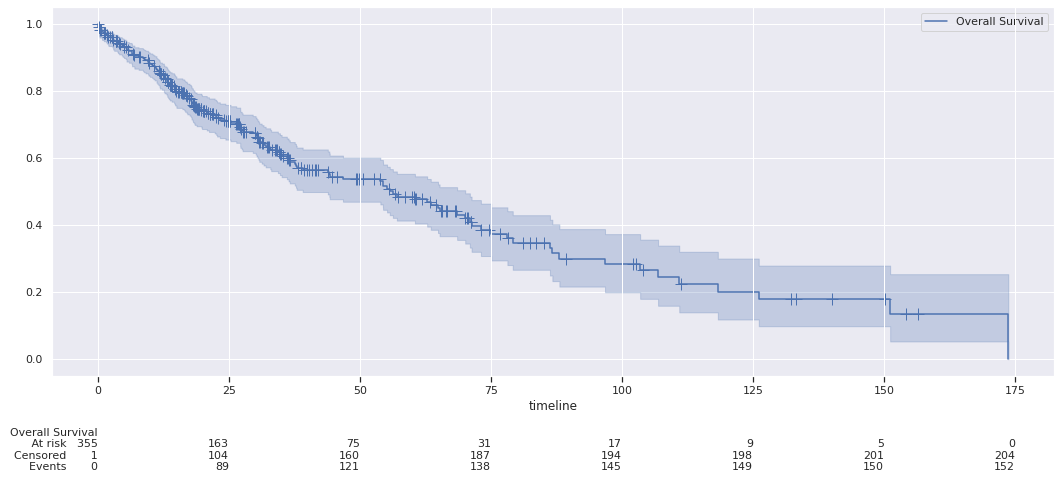

In [8]:
kmf = lifelines.KaplanMeierFitter(label="Overall Survival")
kmf.fit(durations=survival["duration"],
        event_observed=survival["observed"])
plt.figure(figsize=(15,7))
kmf.plot(show_censors=1, ci_show=1, at_risk_counts=True)

In [9]:
rnaseq = pd.read_csv(os.path.join(data_directory, "rnaseq.csv"), index_col=0).T
linearcna = pd.read_csv(os.path.join(data_directory, "linearcna.csv"), index_col=0).T
methylation = pd.read_csv(os.path.join(data_directory, "methylation.csv"), index_col=0).T
mirna = pd.read_csv(os.path.join(data_directory, "mirna.csv"), index_col=0).T

survival.shape, rnaseq.shape, linearcna.shape, methylation.shape, mirna.shape


((356, 2), (356, 20531), (356, 24776), (356, 15868), (356, 1881))

In [10]:
linear_cna_duplicate_columns = ['ACTRT2', 'AGRN', 'ANKRD65', 'ATAD3A', 'ATAD3B', 'ATAD3C', 'AURKAIP1', 'B3GALT6', 'C1orf159', 'C1orf170', 'C1orf222', 'C1orf233', 'C1orf86', 'CALML6', 'CCNL2', 'CDK11A', 'CDK11B', 'CPSF3L', 'DDX11L1', 'DVL1', 'FAM132A', 'FAM138A', 'FAM213B', 'FAM41C', 'FAM87B', 'GABRD', 'GLTPD1', 'GNB1', 'HES4', 'HES5', 'ISG15', 'KLHL17', 'LINC00115', 'LINC00982', 'MIB2', 'MIR200A', 'MIR200B', 'MIR429', 'MMEL1', 'MMP23B', 'MORN1', 'MRPL20', 'MXRA8', 'NADK', 'NOC2L', 'OR4F16', 'OR4F29', 'OR4F5', 'PANK4', 'PEX10', 'PLCH2', 'PLEKHN1', 'PRDM16', 'PRKCZ', 'PUSL1', 'RER1', 'RN7SL657P', 'RNF223', 'SAMD11', 'SCNN1D', 'SDF4', 'SKI', 'SLC35E2B', 'SLC35E2', 'SSU72', 'TAS1R3', 'TMEM240', 'TMEM52', 'TMEM88B', 'TNFRSF14', 'TNFRSF18', 'TNFRSF4', 'TTC34', 'TTLL10', 'UBE2J2', 'VWA1', 'SMIM1', 'LRRC47', 'RN7SL574P', 'RNF207', 'ICMT', 'GPR153', 'HES3', 'ACOT7', 'PLEKHG5', 'TNFRSF25', 'KLHL21', 'THAP3', 'PER3', 'UTS2', 'ERRFI1', 'RN7SL451P', 'SLC2A7', 'GPR157', 'H6PD', 'TMEM201', 'C1orf200', 'NMNAT1', 'RN7SKP269', 'MIR5697', 'RN7SL731P', 'APITD1', 'DFFA', 'TARDBP', 'MASP2', 'SRM', 'EXOSC10', 'MTOR', 'snoU13|ENSG00000271794.1', 'ANGPTL7', 'PTCHD2', 'FBXO44', 'FBXO6', 'MAD2L2', 'DRAXIN', 'MTHFR', 'CLCN6', 'KIAA2013', 'PLOD1', 'MIIP', 'RN7SL649P', 'MIR4632', 'SNORA70|ENSG00000252969.1', 'snoU13|ENSG00000238771.1', 'PRAMEF10', 'PRAMEF11', 'PRAMEF12', 'PRAMEF13', 'PRAMEF14', 'PRAMEF15', 'PRAMEF16', 'PRAMEF17', 'PRAMEF18', 'PRAMEF19', 'PRAMEF1', 'PRAMEF21', 'PRAMEF22', 'PRAMEF2', 'PRAMEF3', 'PRAMEF4', 'PRAMEF5', 'PRAMEF6', 'PRAMEF7', 'PRAMEF8', 'PRAMEF9', 'PRAMEF20', 'LRRC38', 'C1orf195', 'FHAD1', 'CELA2A', 'CELA2B', 'CASP9', 'SCARNA21|ENSG00000251866.1', 'AGMAT', 'RSC1A1', 'PLEKHM2', 'FBLIM1', 'SLC25A34', 'TMEM82', 'SPEN', 'snoU13|ENSG00000238818.1', 'ZBTB17', 'CLCNKA', 'CLCNKB', 'FAM131C', 'C1ORF134', 'RSG1', 'SZRD1', 'CROCCP2', 'CROCC', 'ESPNP', 'MFAP2', 'MIR3675', 'MST1L', 'NBPF1', 'U1|ENSG00000228549.2', 'U1|ENSG00000233421.3', 'PADI2', 'MIR3972', 'PADI6', 'snoU13|ENSG00000239020.1', 'ALDH4A1', 'MIR4695', 'MIR1290', 'MRTO4', 'AKR7A3', 'AKR7L', 'PQLC2', 'RN7SL85P', 'RN7SL277P', 'MINOS1', 'NBL1', 'HTR6', 'OTUD3', 'PLA2G2A', 'RN7SL304P', 'PLA2G2D', 'PLA2G2C', 'UBXN10', 'VWA5B1', 'MUL1', 'FAM43B', 'CDA', 'PINK1', 'DDOST', 'SH2D5', 'NBPF3', 'HSPG2', 'CELA3A', 'CELA3B', 'LINC00339', 'RN7SL186P', 'RN7SL386P', 'RN7SL421P', 'RN7SL768P', 'WNT4', 'EPHA8', 'C1QA', 'C1QC', 'C1QB', 'MIR4253', 'C1orf234', 'MIR4419A', 'ZNF436', 'C1orf213', 'TCEA3', 'E2F2', 'ID3', 'RN7SL532P', 'TCEB3', 'PITHD1', 'LYPLA2', 'FUCA1', 'CNR2', 'RN7SL24P', 'snoU13|ENSG00000238538.1', 'MIR378F', 'PNRC2', 'SRSF10', 'IFNLR1', 'STPG1', 'NIPAL3', 'RN7SL857P', 'NCMAP', 'snoU13|ENSG00000238986.1', 'RHCE', 'RHD', 'SYF2', 'TMEM50A', 'snoU13|ENSG00000238889.1', 'LDLRAP1', 'MTFR1L', 'AUNIP', 'PAQR7', 'STMN1', 'MIR3917', 'SCARNA17|ENSG00000252190.1', 'SCARNA18|ENSG00000252691.1', 'EXTL1', 'SLC30A2', 'TRIM63', 'FAM110D', 'ZNF593', 'CATSPER4', 'CEP85', 'SH3BGRL3', 'UBXN11', 'CD52', 'RN7SL490P', 'ZNF683', 'LIN28A', 'HMGN2', 'RPS6KA1', 'MIR1976', 'RN7SL501P', 'RN7SL165P', 'ZDHHC18', 'GPATCH3', 'NR0B2', 'TRNP1', 'FAM46B', 'SYTL1', 'MAP3K6', 'FCN3', 'CD164L2', 'GPR3', 'IFI6', 'FAM76A', 'SCARNA1', 'THEMIS2', 'SMPDL3B', 'EYA3', 'RN7SL559P', 'SESN2', 'RCC1', 'SNHG3', 'SNORA73B', 'snoU13|ENSG00000238821.1', 'TRNAU1AP', 'SNHG12', 'SNORD99', 'RAB42', 'RNU11', 'GMEB1', 'SCARNA24|ENSG00000252777.1', 'YTHDF2', 'TMEM200B', 'SRSF4', 'MATN1', 'MIR4420', 'SNORD85', 'PEF1', 'MIR4254', 'PTP4A2', 'MIR5585', 'CCDC28B', 'IQCC', 'DCDC2B', 'TMEM234', 'EIF3I', 'MTMR9LP', 'FAM167B', 'HDAC1', 'BSDC1', 'FAM229A', 'ZBTB8B', 'S100PBP', 'FNDC5', 'HPCA', 'TMEM54', 'RNF19B', 'FKSG48', 'A3GALT2', 'MIR3605', 'RN7SKP16', 'GJB5', 'GJB4', 'GJB3', 'GJA4', 'ZMYM6', 'RN7SL503P', 'SNORA62|ENSG00000201542.1', 'RNY5P1', 'KIAA0319L', 'NCDN', 'TFAP2E', 'RN7SL281P', 'CLSPN', 'ADPRHL2', 'COL8A2', 'MAP7D1', 'RN7SL131P', 'SH3D21', 'MRPS15', 'CSF3R', 'MIR5581', 'SNIP1', 'GNL2', 'RSPO1', 'C1orf109', 'CDCA8', 'EPHA10', 'MANEAL', 'YRDC', 'C1orf122', 'SF3A3', 'FHL3', 'UTP11L', 'POU3F1', 'MYCBP', 'GJA9', 'SNORA55', 'HEYL', 'HPCAL4', 'NT5C1A', 'PPT1', 'ZMPSTE24', 'COL9A2', 'EXO5', 'NFYC', 'MIR30C1', 'RN7SL326P', 'CITED4', 'SLFNL1', 'EDN2', 'GUCA2A', 'ZMYND12', 'PPCS', 'PPIH', 'LEPRE1', 'CCDC23', 'ERMAP', 'ZNF691', 'WDR65', 'RNA5SP46', 'TMEM125', 'C1orf210', 'MPL', 'ELOVL1', 'SZT2', 'IPO13', 'DPH2', 'ATP6V0B', 'B4GALT2', 'CCDC24', 'SLC6A9', 'RN7SL479P', 'ERI3', 'TMEM53', 'BTBD19', 'PLK3', 'RPS8', 'SNORD38A', 'SNORD38B', 'SNORD46|ENSG00000200913.1', 'SNORD55', 'TCTEX1D4', 'EIF2B3', 'RNA5SP47', 'HECTD3', 'UROD', 'TESK2', 'TOE1', 'snoU13|ENSG00000238945.1', 'MMACHC', 'PRDX1', 'AKR1A1', 'NASP', 'TMEM69', 'PIK3R3', 'TSPAN1', 'POMGNT1', 'LURAP1', 'LRRC41', 'UQCRH', 'DMBX1', 'MKNK1', 'MOB3C', 'EFCAB14', 'TEX38', 'CYP4A11', 'CYP4X1', 'TAL1', 'FOXD2', 'C1orf185', 'RNF11', 'RN7SL290P', 'KTI12', 'BTF3L4', 'RN7SL788P', 'ORC1', 'PRPF38A', 'ZCCHC11', 'snoU13|ENSG00000239063.1', 'GPX7', 'SELRC1', 'ZYG11B', 'ZYG11A', 'ECHDC2', 'MIR1273F', 'MIR1273G', 'SLC1A7', 'C1orf123', 'MAGOH', 'LRP8', 'DMRTB1', 'SNORA58|ENSG00000201003.1', 'HSPB11', 'LRRC42', 'TMEM59', 'CYB5RL', 'MRPL37', 'C1orf191', 'TTC4', 'C1orf177', 'PARS2', 'TTC22', 'BSND', 'USP24', 'RN7SL713P', 'TACSTD2', 'KANK4', 'DOCK7', 'ANGPTL3', 'RNA5SP49', 'RN7SL488P', 'DLEU2L', 'RN7SL130P', 'MIR4794', 'DNAJC6', 'LEPROT', 'LEPR', 'MIR3117', 'INSL5', 'C1orf141', 'SNORA31|ENSG00000252433.1', 'IL23R', 'RNU4ATAC4P', 'IL12RB2', 'GADD45A', 'GNG12', 'WLS', 'RPE65', 'DEPDC1', 'PIN1P1', 'RN7SL242P', 'SRSF11', 'MIR186', 'CRYZ', 'SNORD45C', 'SNORD45A', 'SNORD45B', 'ASB17', 'RNA5SP20', 'RN7SL370P', 'USP33', 'FUBP1', 'IFI44', 'PRKACB', 'SNORA2|ENSG00000199959.1', 'UOX', 'RPF1', 'GNG5', 'SPATA1', 'C1orf180', 'SSX2IP', 'MCOLN2', 'MCOLN3', 'MIR4423', 'SYDE2', 'BCL10', 'SNORD81|ENSG00000199934.1', 'CLCA3P', 'RBMXL1', 'GBP1', 'GBP2', 'GBP7', 'GBP1P1', 'ZNF326', 'BARHL2', 'RN7SL235P', 'BRDT', 'ACTBP12', 'GLMN', 'RPAP2', 'RN7SL824P', 'EVI5', 'SNORD21', 'SNORA66|ENSG00000251795.1', 'SNORA66|ENSG00000207523.1', 'FAM69A', 'SNORA51|ENSG00000207022.1', 'RN7SL692P', 'CCDC18', 'RNA5SP53', 'DNTTIP2', 'RN7SL440P', 'snoU13|ENSG00000238389.1', 'F3', 'RN7SKP270', 'SLC35A3', 'SASS6', 'LRRC39', 'RTCA', 'MIR553', 'GPR88', 'VCAM1', 'DPH5', 'S1PR1', 'AMY1B', 'AMY1C', 'AMY2A', 'AMY2B', 'RNPC3', 'NBPF4', 'NBPF6', 'HENMT1', 'PRPF38B', 'GPSM2', 'TAF13', 'C1orf194', 'SCARNA2', 'TMEM167B', 'CELSR2', 'PSRC1', 'MYBPHL', 'SORT1', 'ATXN7L2', 'CYB561D1', 'AMIGO1', 'GNAI3', 'RNU6V', 'GNAT2', 'AMPD2', 'GSTM2', 'GSTM4', 'GSTM3', 'EPS8L3', 'AHCYL1', 'STRIP1', 'ALX3', 'UBL4B', 'SLC6A17', 'SNORA25|ENSG00000200536.1', 'LAMTOR5', 'CYMP', 'KCNA10', 'KCNA3', 'CEPT1', 'DENND2D', 'PGCP1', 'OVGP1', 'ATP5F1', 'ADORA3', 'FAM212B', 'CTTNBP2NL', 'WNT2B', 'RHOC', 'FAM19A3', 'PTPN22', 'BCL2L15', 'AP4B1', 'DCLRE1B', 'HIPK1', 'RN7SL432P', 'NRAS', 'SIKE1', 'TSPAN2', 'SNORA42|ENSG00000207502.1', 'ATP1A1OS', 'MIR548AC', 'IGSF3', 'ANKRD20A12P', 'ANKRD34A', 'ANKRD35', 'BCL9', 'BOLA1', 'CD160', 'CHD1L', 'FAM72B', 'FAM72C', 'FAM72D', 'FCGR1A', 'FCGR1B', 'FCGR1C', 'FMO5', 'GJA5', 'GJA8', 'GNRHR2', 'GPR89A', 'GPR89B', 'GPR89C', 'HFE2', 'HIST2H2AA3', 'HIST2H2AA4', 'HIST2H2AB', 'HIST2H2AC', 'HIST2H2BA', 'HIST2H2BE', 'HIST2H2BF', 'HIST2H3A', 'HIST2H3C', 'HIST2H3D', 'HIST2H4A', 'HIST2H4B', 'HYDIN2', 'ITGA10', 'LINC00623', 'LINC00624', 'LIX1L', 'NBPF10', 'NBPF11', 'NBPF12', 'NBPF14', 'NBPF15', 'NBPF16', 'NBPF20', 'NBPF24', 'NBPF8', 'NBPF9', 'NOTCH2NL', 'NUDT17', 'PDE4DIP', 'PDZK1P1', 'PDZK1', 'PEX11B', 'PIAS3', 'POLR3C', 'POLR3GL', 'PPIAL4A', 'PPIAL4B', 'PPIAL4C', 'PPIAL4D', 'PPIAL4G', 'PRKAB2', 'RBM8A', 'RN7SKP88', 'RN7SL261P', 'RNA5SP57', 'RNA5SP58', 'RNA5SP59', 'RNF115', 'SEC22B', 'SRGAP2B', 'TXNIP', 'MTMR11', 'PLEKHO1', 'CA14', 'snoU13|ENSG00000238526.1', 'APH1A', 'C1orf54', 'C1orf51', 'MRPS21', 'PRPF3', 'LINC00568', 'ADAMTSL4', 'MIR4257', 'C1orf138', 'RN7SL473P', 'RN7SL600P', 'MCL1', 'SNORA40|ENSG00000253047.1', 'SETDB1', 'ANXA9', 'FAM63A', 'PRUNE', 'BNIPL', 'C1orf56', 'CDC42SE1', 'MLLT11', 'GABPB2', 'SEMA6C', 'LYSMD1', 'SCNM1', 'TNFAIP8L2', 'TMOD4', 'VPS72', 'PIP5K1A', 'PI4KB', 'RN7SL444P', 'RFX5', 'PSMB4', 'SELENBP1', 'CGN', 'SNORA44', 'MIR554', 'SNX27', 'RIIAD1', 'MRPL9', 'OAZ3', 'TDRKH', 'LINGO4', 'RORC', 'C2CD4D', 'THEM5', 'THEM4', 'TCHHL1', 'HRNR', 'FLG', 'CRCT1', 'LCE3B', 'LCE3C', 'LCE3D', 'LCE3E', 'LCE3A', 'LCE2D', 'LINC00302', 'LCE2C', 'LCE2A', 'C1orf68', 'LCE1F', 'LCE1C', 'LCE1D', 'LCE1E', 'LCE6A', 'SPRR4', 'SPRR1A', 'SPRR3', 'SNORA31|ENSG00000252920.1', 'SPRR1B', 'SPRR2D', 'SPRR2A', 'SPRR2E', 'SPRR2G', 'LOR', 'PGLYRP3', 'S100A8', 'S100A9', 'S100A7L2', 'S100A7', 'RN7SL44P', 'S100A4', 'S100A5', 'S100A6', 'S100A2', 'S100A14', 'S100A13', 'S100A1', 'CHTOP', 'ILF2', 'INTS3', 'RN7SL372P', 'snoU13|ENSG00000238511.1', 'SLC27A3', 'GATAD2B', 'CRTC2', 'SLC39A1', 'CREB3L4', 'JTB', 'RAB13', 'NUP210L', 'RPS27', 'U3|ENSG00000252669.1', 'TPM3', 'RN7SL431P', 'MIR190B', 'C1orf189', 'C1orf43', 'SNORA58|ENSG00000201129.1', 'HAX1', 'SNORD59|ENSG00000252682.1', 'SHE', 'TDRD10', 'UBE2Q1', 'CHRNB2', 'ADAR', 'PBXIP1', 'PYGO2', 'SHC1', 'CKS1B|ENSG00000173207.8', 'MIR4258', 'FLAD1', 'ZBTB7B', 'DCST2', 'DCST1', 'ADAM15', 'EFNA4', 'DPM3', 'SLC50A1', 'KRTCAP2', 'TRIM46', 'MIR92B', 'MUC1', 'THBS3', 'GBAP1', 'GBA', 'FAM189B', 'SCAMP3', 'HCN3', 'FDPS', 'RUSC1', 'DAP3', 'KIAA0907', 'SNORA42|ENSG00000207475.1', 'SCARNA4|ENSG00000252808.1', 'RXFP4', 'ARHGEF2', 'LAMTOR2', 'RAB25', 'LMNA', 'SNORA26|ENSG00000252236.1', 'SLC25A44', 'BGLAP', 'PAQR6', 'SMG5', 'C1orf85', 'TMEM79', 'VHLL', 'CCT3', 'TSACC', 'RHBG', 'C1orf61', 'snoU13|ENSG00000238843.1', 'TTC24', 'APOA1BP', 'GPATCH4', 'BCAN', 'CRABP2', 'ISG20L2', 'RRNAD1', 'MRPL24', 'PRCC', 'NTRK1', 'LRRC71', 'MIR765', 'RN7SL612P', 'ETV3L', 'CD5L', 'CD1C', 'OR10T2', 'OR10K2', 'OR10K1', 'OR10R2', 'OR6P1', 'OR6Y1', 'OR6K3', 'OR6K6', 'OR6N1', 'OR6N2', 'RNA5SP60', 'DARC', 'OR10J1', 'OR10J5', 'APCS', 'SLAMF8', 'C1orf204', 'VSIG8', 'CCDC19', 'IGSF9', 'SLAMF9', 'IGSF8', 'NCSTN', 'NHLH1', 'SLAMF1', 'ITLN2', 'USF1', 'ARHGAP30', 'PVRL4', 'KLHDC9', 'PFDN2', 'DEDD', 'ACA64|ENSG00000238934.1', 'UFC1', 'USP21', 'B4GALT3', 'PPOX', 'ADAMTS4', 'NDUFS2', 'APOA2', 'MIR5187', 'NR1I3', 'TOMM40L', 'PCP4L1', 'SDHC', 'C1orf192', 'FCGR2B', 'FCGR2C', 'FCGR3A', 'FCGR3B', 'HSPA6', 'RPL31P11', 'FCRLA', 'FCRLB', 'DUSP12', 'C1orf111', 'SH2D1B', 'UAP1', 'DDR2', 'RN7SL861P', 'HSD17B7', 'RNA5SP62', 'RNA5SP63', 'FAM78B', 'TADA1', 'MAEL', 'RNA5SP65', 'snoU13|ENSG00000238325.1', 'GPA33', 'MPZL1', 'ADCY10', 'MPC2', 'DCAF6', 'MIR1255B2', 'TIPRL', 'ANKRD36BP1', 'MIR557', 'LINC00626', 'ATP1B1', 'CCDC181', 'F5', 'SELL', 'SELE', 'RN7SL269P', 'MIR1295A', 'FMO6P', 'PRRC2C', 'RN7SL425P', 'VAMP4', 'METTL13', 'MIR214', 'MIR199A2', 'FASLG', 'CENPL', 'DARS2', 'GAS5', 'SNORD78|ENSG00000208317.1', 'RNA5SP67', 'TEX35', 'RNA5SP69', 'FAM20B', 'TOR3A', 'SNORA67|ENSG00000212338.1', 'RN7SL374P', 'IFRG15', 'TOR1AIP1', 'RN7SL230P', 'RN7SKP229', 'TEDDM1', 'LINC00272', 'RGS8', 'DHX9', 'RNA5SP71', 'NCF2', 'ARPC5', 'APOBEC4', 'TSEN15', 'C1orf21', 'EDEM3', 'RNF2', 'TRMT1L', 'IVNS1ABP', 'TPR', 'RGS13', 'snoU109|ENSG00000238754.1', 'CFH', 'CFHR1', 'CFHR2', 'CFHR3', 'CFHR4', 'CFHR5', 'F13B', 'ASPM', 'LHX9', 'MIR181A1', 'MIR181B1', 'ZNF281', 'CAMSAP2', 'GPR25', 'C1orf106', 'ASCL5', 'LAD1', 'TNNI1', 'PHLDA3', 'IPO9', 'LMOD1', 'SNORA70|ENSG00000206637.1', 'RNPEP', 'ARL8A', 'PTPN7', 'LGR6', 'snoU13|ENSG00000238571.1', 'snoU13|ENSG00000239046.1', 'UBE2T', 'SNORA70|ENSG00000253042.1', 'KDM5B', 'PCAT6', 'RABIF', 'KLHL12', 'ADIPOR1', 'CYB5R1', 'TMEM183A', 'MYOG', 'ADORA1', 'CHIT1', 'FMOD', 'PRELP', 'OPTC', 'SNORA77|ENSG00000221643.1', 'LAX1', 'ZBED6', 'LINC00303', 'ETNK2', 'REN', 'GOLT1A', 'SCARNA20|ENSG00000251861.1', 'SNORD112|ENSG00000252946.1', 'TMEM81', 'RBBP5', 'DSTYK', 'MFSD4', 'ELK4', 'SLC45A3', 'NUCKS1', 'SNORA72|ENSG00000201944.1', 'SLC41A1', 'PM20D1', 'SLC26A9', 'FAM72A', 'SNORD60|ENSG00000252692.1', 'IKBKE', 'RASSF5', 'DYRK3', 'SNORD112|ENSG00000252853.1', 'IL10', 'IL20', 'IL24', 'FAIM3', 'PIGR', 'FCAMR', 'snoU13|ENSG00000238401.1', 'YOD1', 'PFKFB2', 'C4BPB', 'C4BPA', 'CD46', 'MIR29B2', 'MIR29C', 'C1orf132', 'LAMB3', 'MIR4260', 'RD3', 'SLC30A1', 'RN7SL344P', 'DTL', 'MIR3122', 'RN7SKP98', 'SNORA16B', 'TMEM206', 'NENF', 'ATF3', 'RN7SL512P', 'FAM71A', 'BATF3', 'TATDN3', 'C1orf227', 'FLVCR1', 'ANGEL2', 'USH2A', 'SNORD116|ENSG00000202498.1', 'C1orf143', 'U3|ENSG00000212610.1', 'EPRS', 'snoU13|ENSG00000238798.1', 'IARS2', 'MIR215', 'snoU13|ENSG00000238576.1', 'C1orf115', 'TAF1A', 'AIDA', 'BROX', 'RN7SL276P', 'FAM177B', 'CAPN8', 'SNORA72|ENSG00000201898.1', 'MIR320B2', 'snoU13|ENSG00000238856.1', 'CNIH4', 'MIR4742', 'TMEM63A', 'LEFTY1', 'PYCR2', 'SDE2', 'MIXL1', 'snoU13|ENSG00000238545.1', 'snoU13|ENSG00000239094.1', 'RN7SKP165', 'SNAP47', 'MIR5008', 'WNT3A', 'ARF1', 'MIR3620', 'C1orf35', 'MRPL55', 'GJC2', 'GUK1', 'C1orf148', 'IBA57', 'C1orf145', 'BTNL10', 'HIST3H2A', 'HIST3H2BB', 'HIST3H3', 'MIR4666A', 'RNA5S10', 'RNA5S11', 'RNA5S12', 'RNA5S13', 'RNA5S14', 'RNA5S15', 'RNA5S16', 'RNA5S17', 'RNA5S1', 'RNA5S2', 'RNA5S3', 'RNA5S4', 'RNA5S5', 'RNA5S6', 'RNA5S7', 'RNA5S8', 'RNA5S9', 'RNA5SP18', 'RNA5SP19', 'RNF187', 'SNORA51|ENSG00000206878.1', 'TRIM11', 'TRIM17', 'RAB4A', 'SPHAR', 'CCSAP', 'RN7SKP276', 'ACTA1', 'ABCB10', 'RNA5SP78', 'URB2', 'CAPN9', 'RNA5SP79', 'C1orf198', 'snoU13|ENSG00000238985.1', 'ARV1', 'FAM89A', 'MIR1182', 'C1orf131', 'GNPAT', 'RNA5SP80', 'EXOC8', 'SPRTN', 'EGLN1', 'TSNAX', 'LINC00582', 'MIR4427', 'COA6', 'IRF2BP2', 'RN7SL668P', 'RBM34', 'SNORA14B', 'MIR4753', 'TBCE', 'OPN3', 'WDR64', 'MAP1LC3C', 'RN7SKP12', 'MIR4677', 'RN7SL148P', 'ADSS', 'C1orf101', 'HNRNPU', 'SCCPDH', 'SNORA25|ENSG00000252011.1', 'SNORD112|ENSG00000252495.1', 'TFB2M', 'C1orf229', 'RNA5SP82', 'OR2B11', 'OR2C3', 'MIR3124', 'OR11L1', 'OR13G1', 'OR14A16', 'OR14A2', 'OR14C36', 'OR14I1', 'OR14K1', 'OR1C1', 'OR2AJ1', 'OR2AK2', 'OR2G6', 'OR2L13', 'OR2L2', 'OR2L3', 'OR2L5', 'OR2L8', 'OR2M2', 'OR2M3', 'OR2M4', 'OR2M5', 'OR2M7', 'OR2T10', 'OR2T11', 'OR2T12', 'OR2T1', 'OR2T27', 'OR2T29', 'OR2T2', 'OR2T33', 'OR2T34', 'OR2T35', 'OR2T3', 'OR2T4', 'OR2T5', 'OR2T6', 'OR2T7', 'OR2T8', 'OR2W3', 'OR6F1', 'PGBD2', 'SH3BP5L', 'TRIM58', 'ZNF672', 'ZNF692', 'FAM110C', 'FAM150B', 'SH3YL1', 'SNTG2', 'TPO', 'RPS7', 'SNORA73|ENSG00000252531.1', 'COLEC11', 'CPSF3', 'IAH1', 'ADAM17', 'snoU13|ENSG00000238462.1', 'KLF11', 'CYS1', 'RRM2', 'C2orf48', 'SNORA2|ENSG00000206647.1', 'MIR4261', 'SNORA80B', 'PDIA6', 'KCNF1', 'PQLC3', 'ROCK2', 'E2F6', 'RNA5SP84', 'GREB1', 'MIR4429', 'RNA5SP85', 'RN7SL674P', 'LPIN1', 'MIR4262', 'MIR3681', 'MIR3125', 'MYCNOS', 'MYCN', 'RN7SL104P', 'GEN1', 'OSR1', 'TTC32', 'RHOB', 'GDF7', 'C2orf43', 'TDRD15', 'C2orf44', 'FKBP1B', 'SF3B6', 'FAM228B', 'TP53I3', 'PFN4', 'FAM228A', 'SCARNA21|ENSG00000251805.1', 'DNAJC27', 'SNORD14', 'ASXL2', 'RAB10', 'HADHA', 'GPR113', 'DRC1', 'C2orf70', 'CIB4', 'KCNK3', 'SLC35F6', 'MAPRE3', 'TMEM214', 'AGBL5', 'OST4', 'EMILIN1', 'KHK', 'CGREF1', 'ABHD1', 'PREB', 'C2orf53', 'SLC5A6', 'ATRAID', 'CAD', 'SLC30A3', 'DNAJC5G', 'TRIM54', 'MPV17', 'UCN', 'GTF3C2', 'EIF2B4', 'SNX17', 'ZNF513', 'PPM1G', 'NRBP1', 'IFT172', 'KRTCAP3', 'FNDC4', 'GCKR', 'C2orf16', 'ZNF512', 'CCDC121', 'SNORA36|ENSG00000206731.1', 'SUPT7L', 'SLC4A1AP', 'SNORD53', 'SNORD92', 'SPDYA', 'TRMT61B', 'WDR43', 'CLIP4', 'SNORA64|ENSG00000207187.1', 'LBH', 'RNA5SP90', 'EHD3', 'MEMO1', 'SPAST', 'NLRC4', 'LTBP1', 'MIR4765', 'MIR558', 'SNORD112|ENSG00000252502.1', 'TTC27', 'RNA5SP92', 'FAM98A', 'EIF2AK2', 'CEBPZ', 'NDUFAF7', 'CDC42EP3', 'LINC00211', 'RMDN2', 'CYP1B1', 'SRSF7', 'MORN2', 'RN7SL96P', 'SNORA67|ENSG00000252473.1', 'SNORD75|ENSG00000221300.1', 'RN7SKP66', 'DYNC2LI1', 'snoU13|ENSG00000239052.1', 'PREPL', 'RN7SL817P', 'TTC7A', 'CALM2', 'C2orf61', 'RN7SKP119', 'MIR559', 'FOXN2', 'PPP1R21', 'GPR75', 'C2orf73', 'TSPYL6', 'CLHC1', 'PRORSD1P', 'CCDC88A', 'SMEK2', 'SNORA12|ENSG00000212175.1', 'MIR217', 'MIR216B', 'PEX13', 'MIR5192', 'snoU13|ENSG00000238809.1', 'VPS54', 'snoU13|ENSG00000238696.1', 'Vault|ENSG00000251900.1', 'PNO1', 'ARHGAP25', 'FBXO48', 'PROKR1', 'MIR3126', 'RNA5SP96', 'AAK1', 'SNORA36C', 'SNRNP27', 'MXD1', 'ASPRV1', 'RN7SL470P', 'PCYOX1', 'SNRPG', 'CD207', 'ATP6V1B1', 'snoU13|ENSG00000239064.1', 'RN7SL160P', 'ANKRD53', 'TEX261', 'PAIP2B', 'EMX1', 'SMYD5', 'CCT7', 'PRADC1', 'FBXO41', 'EGR4', 'ALMS1P', 'NAT8', 'TPRKB', 'DUSP11', 'C2orf78', 'MGC10955', 'MOB1A', 'C2orf81', 'WDR54', 'RTKN', 'INO80B', 'WBP1', 'MOGS', 'MRPL53', 'TTC31', 'PCGF1', 'TLX2', 'DQX1', 'AUP1', 'HTRA2', 'LOXL3', 'DOK1', 'M1AP', 'EVA1A', 'snoU109|ENSG00000238410.1', 'U3|ENSG00000221638.1', 'snoU13|ENSG00000239018.1', 'REG1B', 'REG1P', 'REG3A', 'REG3G', 'TMSB10', 'KCMF1', 'RETSAT', 'ELMOD3', 'RN7SL113P', 'CAPG', 'SH2D6', 'RN7SL251P', 'MAT2A', 'GGCX', 'VAMP8', 'RN7SL126P', 'RNF181', 'C2orf68', 'TMEM150A', 'USP39', 'GNLY', 'RN7SKP83', 'IMMT', 'MIR4779', 'MRPL35', 'PTCD3', 'REEP1', 'SNORD94', 'CHMP3', 'RMND5A', 'CD8A', 'CD8B', 'PLGLB1', 'PLGLB2', 'RGPD1', 'KRCC1', 'SMYD1', 'MIR4780', 'FABP1', 'THNSL2', 'RNY4P15', 'TEX37', 'EIF2AK3', 'RPIA', 'IGKJ1', 'IGKJ2', 'IGKJ3', 'IGKJ4', 'IGKJ5', 'RNA5SP100', 'SLC9B1P2', 'ZNF514', 'FLJ14082', 'LINC00342', 'TRIM43', 'FAHD2CP', 'RN7SL210P', 'GPAT2', 'ADRA2B', 'ASTL', 'CIAO1', 'SNRNP200', 'ITPRIPL1', 'ARID5A', 'LMAN2L', 'CNNM4', 'MIR3127', 'CNNM3', 'ANKRD39', 'SEMA4C', 'FAM178B', 'snoU13|ENSG00000238760.1', 'ANKRD36B', 'ANKRD36', 'COX5B', 'FAHD2B', 'RN7SL313P', 'UNC50', 'MRPL30', 'MITD1', 'LYG2', 'PDCL3', 'snoU13|ENSG00000238328.1', 'RNF149', 'SNORD89', 'MIR5696', 'CREG2', 'IL1RL1', 'MIR4772', 'SLC9A4', 'TMEM182', 'GPR45', 'TGFBRAP1', 'UXS1', 'RGPD3', 'CD8BP', 'RGPD4', 'SULT1C2', 'CCDC138', 'SOWAHC', 'LIMS3|ENSG00000256977.6', 'LIMS3|ENSG00000257207.4', 'LINC00116', 'MALL', 'MIR4267', 'MIR4436B1', 'MIR4436B2', 'NPHP1', 'RGPD5', 'RGPD6', 'snoU13|ENSG00000238951.1', 'TTL', 'POLR1B', 'SLC20A1', 'NT5DC4', 'CKAP2L', 'IL1A', 'IL36A', 'IL36RN', 'IL1F10', 'FOXD4L1', 'RABL2A', 'RPL23AP7', 'WASH2P', 'SLC35F5', 'MIR4782', 'snoU13|ENSG00000239077.1', 'CCDC93', 'RN7SL468P', 'DBI', 'TMEM177', 'RALB', 'MKI67IP', 'TSN', 'MAP3K2', 'MIR4783', 'PROC', 'IWS1', 'GPR17', 'AMMECR1L', 'SAP130', 'RN7SL206P', 'CCDC74B', 'CYP4F43P', 'IMP4', 'MZT2B', 'POTEF', 'PTPN18', 'SMPD4', 'TUBA3E', 'CFC1', 'CYP4F30P', 'POTEI', 'POTEJ', 'MIR4784', 'MZT2A', 'POTEE', 'TUBA3D', 'C2orf27B', 'RN7SL701P', 'MIR663B', 'RN7SKP103', 'CCNT2', 'MCM6', 'NMI', 'TNFAIP6', 'RN7SL124P', 'ARL6IP6', 'snoU13|ENSG00000238481.1', 'RN7SKP281', 'ERMN', 'snoZ5', 'LY75', 'MIR4785', 'FAP', 'IFIH1', 'SCN7A', 'RN7SL813P', 'SPC25', 'LRP2', 'KLHL41', 'FASTKD1', 'CCDC173', 'KLHL23', 'PHOSPHO2', 'METTL5', 'U3|ENSG00000252981.1', 'ERICH2', 'GAD1', 'DCAF17', 'DLX1', 'DLX2', 'RN7SL65P', 'CIR1', 'SCRN3', 'GPR155', 'ATP5G3', 'HOXD13', 'HOXD12', 'HOXD10', 'HOXD11', 'HOXD8', 'HOXD3', 'HOXD4', 'MIR10B', 'HOXD1', 'OSBPL6', 'PRKRA', 'DFNB59', 'FKBP7', 'PLEKHA3', 'CWC22', 'SSFA2', 'RNA5SP113', 'SNORA77|ENSG00000221498.1', 'DUSP19', 'U8|ENSG00000212581.1', 'MIR561', 'MIR3129', 'OSGEPL1', 'TMEM194B', 'RN7SKP179', 'snoU13|ENSG00000239161.1', 'SCARNA16|ENSG00000252923.1', 'GTF3C3', 'C2orf66', 'SNORA4|ENSG00000202434.1', 'HSPD1', 'HSPE1', 'MOB4', 'TYW5', 'RNA5SP115', 'CLK1', 'NIF3L1', 'RN7SL694P', 'FAM126B', 'MPP4', 'SNORD70|ENSG00000212534.1', 'SNORD70|ENSG00000212309.1', 'SNORD11B', 'SNORD11|ENSG00000238317.1', 'RN7SL753P', 'CARF', 'ABI2', 'Vault|ENSG00000252485.1', 'EEF1B2', 'SNORA41|ENSG00000207406.1', 'SNORD51|ENSG00000207047.2', 'RN7SKP200', 'RN7SKP260', 'FASTKD2', 'METTL21A', 'FZD5', 'CRYGD', 'CRYGC', 'CRYGB', 'CRYGA', 'C2orf80', 'RPE', 'ACADL', 'ATIC', 'TMEM169', 'XRCC5', 'IGFBP2', 'IGFBP5', 'CXCR1', 'snoU13|ENSG00000238428.1', 'ARPC2', 'AAMP', 'GPBAR1', 'TMBIM1', 'snoU13|ENSG00000238736.1', 'CTDSP1', 'MIR26B', 'VIL1', 'PLCD4', 'U3|ENSG00000252805.1', 'ZNF142', 'BCS1L', 'RNF25', 'STK36', 'TTLL4', 'CYP27A1', 'PRKAG3', 'WNT10A', 'LINC00608', 'CRYBA2', 'FEV', 'CCDC108', 'MIR375', 'IHH', 'MIR3131', 'NHEJ1', 'SLC23A3', 'RN7SL764P', 'CNPPD1', 'FAM134A', 'ABCB6', 'ATG9A', 'ANKZF1', 'GLB1L', 'STK16', 'TUBA4A', 'TUBA4B', 'DNAJB2', 'PTPRN', 'DES', 'GMPPA', 'ASIC4', 'CHPF', 'TMEM198', 'MIR3132', 'OBSL1', 'INHA', 'STK11IP', 'SLC4A3', 'MOGAT1', 'MRPL44', 'RHBDD1', 'SNORA48|ENSG00000212391.1', 'TM4SF20', 'DAW1', 'SPHKAP', 'TRIP12', 'GPR55', 'SPATA3', 'C2orf72', 'PSMD1', 'HTR2B', 'B3GNT7', 'NCL', 'SNORA75|ENSG00000206885.1', 'SNORD20', 'SNORD82', 'C2orf57', 'LINC00471', 'NMUR1', 'RN7SL499P', 'MGC4771', 'PTMA', 'COPS7B', 'MIR1471', 'MIR562', 'ALPP', 'ECEL1P2', 'ALPI', 'ECEL1', 'CHRND', 'TIGD1', 'EIF4E2', 'MIR5001', 'snoU13|ENSG00000239170.1', 'KCNJ13', 'NEU2', 'DGKD', 'UGT1A10', 'UGT1A8', 'UGT1A9', 'UGT1A7', 'UGT1A4', 'UGT1A3', 'DNAJB3', 'UGT1A1', 'MSL3P1', 'PRLH', 'RAB17', 'RAMP1', 'SNORD39|ENSG00000263723.1', 'ESPNL', 'FAM132B', 'ILKAP', 'PER2', 'ASB1', 'MIR4441', 'TWIST2', 'PRR21', 'OR6B3', 'OTOS', 'MIR149', 'RNPEPL1', 'CAPN10', 'AQP12A', 'AQP12B', 'KIF1A', 'SEPT2', 'STK25', 'BOK', 'CXXC11', 'D2HGDH', 'DTYMK', 'GAL3ST2', 'ING5', 'NEU4', 'PDCD1', 'RNA5SP122', 'THAP4', 'CNTN6', 'RN7SKP144', 'RN7SL120P', 'SNORA43|ENSG00000253049.1', 'TRNT1', 'CRBN', 'RN7SL553P', 'OXTR', 'BRPF1', 'OGG1', 'CAMK1', 'TADA3', 'ARPC4', 'TTLL3', 'RPUSD3', 'IL17RE', 'CRELD1', 'PRRT3', 'CIDECP', 'FANCD2', 'FANCD2OS', 'BRK1', 'snoU13|ENSG00000238642.1', 'IRAK2', 'GHRLOS', 'GHRL', 'SEC13', 'TSEN2', 'C3orf83', 'MKRN2', 'snoU13|ENSG00000239140.1', 'SNORA7A', 'TPRXL', 'TMEM43', 'XPC', 'LSM3', 'MRPS25', 'ZFYVE20', 'SH3BP5', 'snoU13|ENSG00000238891.1', 'METTL6', 'EAF1', 'COLQ', 'MIR4270', 'RN7SL110P', 'MIR3134', 'RN7SL4P', 'DPH3', 'OXNAD1', 'RFTN1', 'SGOL1', 'NKIRAS1', 'RPL15', 'NR1D2', 'RNA5SP125', 'MIR4442', 'LINC00692', 'RN7SL859P', 'AZI2', 'snoU13|ENSG00000238646.1', 'CMTM6', 'DYNC1LI1', 'CCR4', 'TMPPE', 'RN7SL296P', 'CRTAP', 'CLASP2', 'DCLK3', 'HSPD1P6', 'RNU6ATAC4P', 'GOLGA4', 'RNA5SP129', 'C3orf35', 'VILL', 'PLCD1', 'DLEC1', 'XYLB', 'ACVR2B', 'TTC21A', 'CSRNP1', 'XIRP1', 'CCR8', 'SLC25A38', 'RPSA', 'SNORA62|ENSG00000202363.1', 'SNORA6', 'RN7SL411P', 'SNORA64|ENSG00000202517.1', 'ZNF619', 'ZNF621', 'RN7SKP58', 'CCK', 'SEC22C', 'SS18L2', 'ZBTB47', 'RN7SL567P', 'CCDC13', 'HHATL', 'HIGD1A', 'KRBOX1', 'CYP8B1', 'ZNF662', 'FAM198A', 'GTDC2', 'TCAIM', 'LINC00694', 'ZNF445', 'ZNF660', 'ZNF35', 'ZNF501', 'KIAA1143', 'TMEM42', 'TGM4', 'CLEC3B', 'CDCP1', 'U3|ENSG00000202268.1', 'RN7SL145P', 'SLC6A20', 'LZTFL1', 'CCR9', 'CXCR6', 'CCR1', 'CCR2', 'CCR5', 'RTP3', 'LRRC2', 'LUZPP1', 'ALS2CL', 'TMIE', 'PRSS46', 'PRSS42', 'PRSS44', 'PRSS45', 'PTH1R', 'CCDC12', 'snoU13|ENSG00000251938.1', 'KIF9', 'snoU13|ENSG00000239128.1', 'KLHL18', 'SCAP', 'snoU13|ENSG00000238350.1', 'CSPG5', 'MIR1226', 'CAMP', 'NME6', 'SPINK8', 'FBXW12', 'RN7SL321P', 'CCDC51', 'SHISA5', 'TREX1', 'PFKFB4', 'UCN2', 'MIR711', 'TMEM89', 'SLC26A6', 'CELSR3', 'PRKAR2A', 'SLC25A20', 'ARIH2', 'P4HTM', 'WDR6', 'DALRD3', 'MIR191', 'MIR425', 'NDUFAF3', 'IMPDH2', 'QRICH1', 'RN7SL182P', 'QARS1', 'USP19', 'LAMB2', 'CCDC71', 'KLHDC8B', 'C3orf84', 'C3orf62', 'MIR4271', 'USP4', 'AMT', 'NICN1', 'DAG1', 'RNA5SP130', 'BSN', 'APEH', 'MST1', 'RNF123', 'AMIGO3', 'GMPPB', 'FAM212A', 'MIR5193', 'UBA7', 'TRAIP', 'RN7SL217P', 'MST1R', 'MIR566', 'SLC38A3', 'GNAI2', 'SEMA3B', 'LSMEM2', 'IFRD2', 'HYAL3', 'HYAL1', 'NAT6', 'HYAL2', 'TUSC2', 'RASSF1', 'ZMYND10', 'NPRL2', 'CYB561D2', 'TMEM115', 'RNA5SP131', 'C3orf18', 'HEMK1', 'CISH', 'VPRBP', 'TEX264', 'GRM2', 'IQCF3', 'IQCF2', 'RN7SL504P', 'IQCF5', 'IQCF1', 'RRP9', 'PARP3', 'GPR62', 'PCBP4', 'ABHD14B', 'ABHD14A', 'ACY1', 'RPL29', 'LINC00696', 'POC1A', 'TLR9', 'TWF2', 'PPM1M', 'WDR82', 'GLYCTK', 'MIR135A1', 'DNAH1', 'BAP1', 'SEMA3G', 'STAB1', 'NT5DC2', 'SNORD19B|ENSG00000238862.1', 'SNORD19B|ENSG00000252787.1', 'SNORD19|ENSG00000212493.1', 'SNORD19|ENSG00000222345.1', 'SNORD69', 'GLT8D1', 'SPCS1', 'NEK4', 'ITIH1', 'MUSTN1', 'PRKCD', 'RN7SL821P', 'SNORD38|ENSG00000207109.1', 'SNORA26|ENSG00000212608.1', 'IL17RB', 'ACTR8', 'FAM208A', 'IL17RD', 'APPL1', 'ASB14', 'DNAH12', 'snoU13|ENSG00000238905.1', 'PDE12', 'ARF4', 'ABHD6', 'RPP14', 'PDHB', 'KCTD6', 'ACOX2', 'U3|ENSG00000212211.1', 'THOC7', 'ATXN7', 'U3|ENSG00000200222.1', 'TMF1', 'MIR3136', 'UBA3', 'ARL6IP5', 'LMOD3', 'RN7SL418P', 'PROK2', 'RN7SL271P', 'LINC00870', 'SHQ1', 'GXYLT2', 'EBLN2', 'FRG2C', 'LINC00960', 'MIR1324', 'MIR4273', 'RN7SL92P', 'ZNF717', 'RN7SKP61', 'MIR4795', 'C3orf38', 'OR5AC2', 'OR5H14', 'OR5H15', 'OR5H2', 'OR5K4', 'OR5K1', 'OR5K2', 'CPOX', 'GPR15', 'SNORD61|ENSG00000238377.1', 'TBC1D23', 'NIT2', 'SNORA31|ENSG00000252989.1', 'TFG', 'IMPG2', 'RPL24', 'NFKBIZ', 'LINC00636', 'IFT57', 'DZIP3', 'GUCA1C', 'LINC00488', 'MORC1', 'U3|ENSG00000221633.1', 'TAGLN3', 'GCSAM', 'BTLA', 'GTPBP8', 'C3orf17', 'SIDT1', 'KIAA2018', 'ATP6V1A', 'GRAMD1C', 'QTRTD1', 'MIR568', 'UPK1B', 'ADPRH', 'PLA1A', 'COX17', 'RN7SL762P', 'RN7SL397P', 'HGD', 'FBXO40', 'GOLGB1', 'HCLS1', 'RN7SL172P', 'snoU13|ENSG00000238670.1', 'EAF2', 'SLC15A2', 'SNORD112|ENSG00000252170.1', 'WDR5B', 'KPNA1', 'PARP9', 'DTX3L', 'PARP15', 'snoU13|ENSG00000238480.1', 'DIRC2', 'SNORA5', 'CCDC14', 'ROPN1', 'MIR544B', 'MUC13', 'HEG1', 'RNA5SP137', 'SNX4', 'snoU13|ENSG00000238992.1', 'UROC1', 'CHST13', 'TXNRD3NB', 'TXNRD3', 'NUP210P1', 'ABTB1', 'SEC61A1', 'GATA2', 'RPN1', 'RN7SL698P', 'KIAA1257', 'EFCC1', 'GP9', 'snoU13|ENSG00000252435.1', 'snoU13|ENSG00000238874.1', 'RAB43', 'ISY1', 'CNBP', 'C3orf37', 'H1FX', 'SNORA7B', 'EFCAB12', 'H1FOO', 'RN7SL752P', 'FAM86HP', 'SNORA58|ENSG00000249020.1', 'ACAD11', 'SNORA33|ENSG00000201827.1', 'CDV3', 'TOPBP1', 'TFP1', 'RNA5SP140', 'TF', 'SLCO2A1', 'AMOTL2', 'RNA5SP141', 'DZIP1L', 'MRAS', 'ESYT3', 'PIK3CB', 'FOXL2', 'PRR23A', 'PRR23B', 'BPESC1', 'COPB2', 'NMNAT3', 'RN7SKP124', 'RNA5SP143', 'PCOLCE2', 'U2SURP', 'PBX2P1', 'PLSCR2', 'CPA3', 'snoU13|ENSG00000243321.2', 'EIF2A', 'SELT', 'FAM194A', 'SIAH2', 'FAM188B2', 'CLRN1', 'GPR171', 'AADAC', 'SUCNR1', 'snoU13|ENSG00000271922.1', 'SLC33A1', 'LXN', 'MFSD1', 'MIR15B', 'SCARNA7', 'TERC', 'MYNN', 'LRRC34', 'SKIL', 'RPL22L1', 'EIF5A2', 'SLC2A2', 'PP13439', 'TMEM212', 'snoU13|ENSG00000238359.1', 'snoU13|ENSG00000271842.1', 'GNB4', 'MRPL47', 'NDUFB5', 'snoU13|ENSG00000239096.1', 'RNA5SP150', 'RNA5SP151', 'AP2M1', 'CYP2AB1P', 'DVL3', 'HTR3C', 'HTR3D', 'HTR3E', 'KLHL24', 'KLHL6', 'LINC00888', 'MAP6D1', 'MIR4448', 'PARL', 'SNORA4|ENSG00000251730.1', 'SNORA63|ENSG00000199363.1', 'SNORA63|ENSG00000201229.1', 'SNORA81|ENSG00000253092.1', 'YEATS2', 'ALG3', 'ECE2', 'MIR1224', 'CAMK2N2', 'EIF4G1', 'SNORD66|ENSG00000212158.1', 'FAM131A', 'CLCN2', 'THPO', 'CHRD', 'IGF2BP2', 'TBCCD1', 'FETUB', 'SNORD2|ENSG00000238942.1', 'RFC4', 'SNORA4|ENSG00000263776.1', 'SNORA63|ENSG00000200320.1', 'SNORA63|ENSG00000200418.1', 'SNORA81|ENSG00000221420.2', 'RTP2', 'RN7SL215P', 'CPN2', 'LRRC15', 'GP5', 'TMEM44', 'LSG1', 'RN7SL36P', 'APOD', 'LINC00969', 'MIR570', 'MUC20', 'MUC4', 'PPP1R2', 'RN7SL773P', 'RNU6ATAC24P', 'SDHAP1', 'TNK2', 'PCYT1A', 'TM4SF19', 'RN7SL738P', 'SMCO1', 'FBXO45', 'PIGX', 'CEP19', 'DLG1', 'MFI2', 'NCBP2', 'PAK2', 'PIGZ', 'SENP5', 'U4|ENSG00000272359.1', 'snoU13|ENSG00000238491.1', 'MIR922', 'FAM157A', 'IQCG', 'LMLN', 'RPL35A', 'ATP5I', 'CPLX1', 'DGKQ', 'FGFRL1', 'GAK', 'IDUA', 'MFSD7', 'MIR571', 'MYL5', 'PCGF3', 'PDE6B', 'PIGG', 'RN7SL358P', 'RNF212', 'SLC26A1', 'TMEM175', 'ZNF141', 'ZNF595', 'ZNF718', 'ZNF721', 'ZNF732', 'ZNF876P', 'SNORA48|ENSG00000212458.1', 'UVSSA', 'TMEM129', 'TACC3', 'NELFA', 'NAT8L', 'MXD4', 'MIR4800', 'RN7SL589P', 'MFSD10', 'NOP14', 'GRK4', 'DOK7', 'LRPAP1', 'TMEM128', 'LYAR', 'ZBTB49', 'NSG1', 'CRMP1', 'MRFAP1L1', 'BLOC1S4', 'RN7SKP292', 'CCDC96', 'TADA2B', 'PSAPL1', 'RNA5SP152', 'CPZ', 'FAM90A26', 'HMX1', 'MIR548I2', 'RNA5SP153', 'USP17L10', 'USP17L11', 'USP17L12', 'USP17L13', 'USP17L15', 'USP17L17', 'USP17L18', 'USP17L19', 'USP17L20', 'USP17L21', 'USP17L22', 'USP17L23', 'USP17L24', 'USP17L25', 'USP17L26', 'USP17L27', 'USP17L28', 'USP17L29', 'USP17L30', 'USP17L5', 'RNA5SP154', 'MIR3138', 'RNA5SP155', 'CLNK', 'RNA5SP156', 'RAB28', 'FBXL5', 'BST1', 'CD38', 'FGFBP2', 'snoU13|ENSG00000238536.1', 'RN7SL315P', 'MED28', 'RN7SL16P', 'PI4K2B', 'SNORD74|ENSG00000200999.1', 'MIR4801', 'TLR10', 'TLR1', 'TLR6', 'FAM114A1', 'MIR574', 'MIR5591', 'LIAS', 'SNORA51|ENSG00000201863.1', 'TMEM33', 'SLC30A9', 'GNPDA2', 'ATP10D', 'FRYL', 'OCIAD1', 'OCIAD2', 'SLAIN2', 'SLC10A4', 'TEC', 'ZAR1', 'SPATA18', 'SNORA26|ENSG00000212588.1', 'snoU13|ENSG00000238753.1', 'NMU', 'AASDH', 'SRP72', 'SPINK2', 'snoU13|ENSG00000238541.1', 'UBA6', 'SNORA62|ENSG00000202374.1', 'TMPRSS11GP', 'TMPRSS11BNL', 'TMPRSS11B', 'UGT2A3', 'UGT2B10', 'UGT2B11', 'UGT2B15', 'UGT2B17', 'UGT2B28', 'UGT2B7', 'UGT2A2', 'SULT1E1', 'CSN2', 'HTN3', 'CSN1S2AP', 'C4orf40', 'ODAM', 'FDCSP', 'CSN3', 'SMR3A', 'SMR3B', 'AMTN', 'ENAM', 'IGJ', 'RUFY3', 'snoU13|ENSG00000238318.1', 'GRSF1', 'DCK', 'RNA5SP163', 'SNORA3|ENSG00000221639.1', 'PF4V1', 'CXCL1', 'PPBP', 'CXCL5', 'RN7SL218P', 'CXCL3', 'PPBPP2', 'EREG', 'THAP6', 'CDKL2', 'USO1', 'SDAD1', 'CXCL10', 'CXCL11', 'FAM47E', 'MIR548AH', 'MIR5096', 'SNORA75|ENSG00000212620.1', 'FGF5', 'SNORD42|ENSG00000202440.1', 'SEC31A', 'THAP9', 'LIN54', 'HELQ', 'FAM175A', 'C4orf36', 'HSD17B13', 'NUDT9', 'SPARCL1', 'DMP1', 'PPM1K', 'HERC5', 'HERC3', 'PIGY', 'PYURF', 'RN7SKP244', 'NAP1L5', 'FAM13A', 'MIR3684', 'ADH5', 'PCNAP1', 'ADH1B', 'MTTP', 'MIR1255A', 'RN7SL728P', 'snoU13|ENSG00000238948.1', 'SLC9B1', 'BDH2', 'TET2', 'RN7SL89P', 'GSTCD', 'RN7SL55P', 'MIR576', 'CCDC109B', 'PLA2G12A', 'GAR1', 'LRIT3', 'AP1AR', 'TIFA', 'LARP7', 'MIR302A', 'MIR302B', 'MIR302C', 'MIR302D', 'MIR367', 'CAMK2D', 'MIR577', 'RN7SL808P', 'FABP2', 'SNORA11|ENSG00000221245.1', 'RN7SKP137', 'QRFPR', 'SMIM43', 'EXOSC9', 'CCNA2', 'BBS7', 'BBS12', 'NUDT6', 'SLC25A31', 'PLK4', 'C4orf33', 'SNORA70|ENSG00000252014.1', 'LINC00499', 'MGARP', 'NDUFC1', 'RN7SKP237', 'SNORD112|ENSG00000252300.1', 'CLGN', 'ELMOD2', 'UCP1', 'ZNF330', 'snoU13|ENSG00000238695.1', 'MIR3139', 'GYPB', 'GYPE', 'RN7SKP235', 'ABCE1', 'C4orf51', 'SLC10A7', 'EDNRA', 'PRMT10', 'RNA5SP165', 'MIR4799', 'RN7SL254P', 'SNORD73A', 'SNORD73', 'PET112', 'SFRP2', 'PLRG1', 'FGB', 'FGA', 'MAP9', 'ASIC5', 'TDO2', 'CTSO', 'TMEM144', 'ETFDH', 'U3|ENSG00000271817.1', 'PPID', 'FNIP2', 'TKTL2', 'TRIM61', 'TRIM60', 'KLHL2', 'CPE', 'MIR578', 'snoU13|ENSG00000238744.1', 'AADAT', 'SCRG1', 'RNA5SP172', 'SNORD65|ENSG00000212191.1', 'FAM92A1P2', 'RN7SKP67', 'U3|ENSG00000252048.1', 'snoU13|ENSG00000238319.1', 'CLDN24', 'snoU13|ENSG00000238596.1', 'CDKN2AIP', 'ING2', 'snoU13|ENSG00000239116.1', 'STOX2', 'TRAPPC11', 'CCDC111', 'MLF1IP', 'KIAA1430', 'LRP2BP', 'MIR3945', 'MIR4455', 'SLC25A4', 'SNX25', 'UFSP2', 'C4orf47', 'SNORA31|ENSG00000253013.1', 'DUX4L3', 'DUX4L4', 'DUX4L5', 'DUX4L6', 'DUX4L7', 'DUX4', 'FRG1', 'FRG2', 'HSP90AA4P', 'RNA5SP174', 'RNA5SP175', 'TRIML1', 'TRIML2', 'ZFP42', 'BRD9', 'C5orf55', 'CCDC127', 'CEP72', 'EXOC3', 'LRRC14B', 'MIR4456', 'PDCD6', 'PLEKHG4B', 'SDHA', 'SLC9A3', 'TPPP', 'TRIP13', 'ZDHHC11B', 'ZDHHC11', 'SLC12A7', 'SLC6A18', 'SLC6A19', 'CLPTM1L', 'LPCAT1', 'MIR4277', 'MRPL36', 'NDUFS6', 'SDHAP3', 'IRX2', 'UBE2QL1', 'SRD5A1', 'MTRR', 'FASTKD3', 'CCT5', 'ROPN1L', 'DAP', 'MIR887', 'RNA5SP178', 'RN7SKP133', 'C5orf22', 'MTMR12', 'MIR579', 'AMACR', 'C1QTNF3', 'SLC45A2', 'BRIX1', 'DNAJC21', 'MIR580', 'SKP2', 'FYB', 'PTGER4', 'SNORD72', 'FBXO4', 'C5orf34', 'PAIP1', 'CDC20B', 'MIR449B', 'MIR449C', 'DHX29', 'RNA5SP183', 'IL6ST', 'RNA5SP184', 'GAPT', 'RGS7BP', 'RN7SL169P', 'CENPK', 'PPWD1', 'TRAPPC13', 'SLC30A5', 'SNORA50|ENSG00000220986.1', 'CCNB1', 'snoU13|ENSG00000238334.1', 'CENPH', 'CDK7', 'CCDC125', 'TAF9', 'RAD17', 'MARVELD2', 'GTF2H2C', 'GTF2H2', 'GUSBP3', 'NAIP', 'OCLN', 'RN7SL476P', 'RN7SL616P', 'RN7SL9P', 'SERF1A', 'SERF1B', 'SMN1', 'SMN2', 'snoU13|ENSG00000238451.1', 'snoU13|ENSG00000238740.1', 'MIR4803', 'RN7SL153P', 'PTCD2', 'MIR4804', 'FCHO2', 'TMEM171', 'FAM169A', 'SNORA40|ENSG00000212363.1', 'GCNT4', 'ANKRD31', 'HMGCR', 'F2RL1', 'RN7SL208P', 'snoU13|ENSG00000238688.1', 'S100Z', 'CRHBP', 'AGGF1', 'ZBED3', 'SNORA47', 'WDR41', 'TBCA', 'BHMT2', 'RNY3P1', 'SNORA18|ENSG00000206592.1', 'JMY', 'CMYA5', 'SNORA31|ENSG00000251828.1', 'SPZ1', 'ZFYVE16', 'FAM151B', 'ANKRD34B', 'MTRNR2L2', 'ZCCHC9', 'ACOT12', 'SCARNA18|ENSG00000238835.1', 'XRCC4', 'MIR3607', 'MIR4280', 'RNA5SP187', 'MEF2C', 'MBLAC2', 'POLR3G', 'LYSMD3', 'GPR150', 'C5orf27', 'RN7SKP62', 'ST8SIA4', 'MIR548P', 'SLCO4C1', 'RN7SKP68', 'LINC00491', 'PPIP5K2', 'NUDT12', 'RN7SKP230', 'SLC25A46', 'WDR36', 'SNORA13', 'FLJ11235', 'YTHDC2', 'TICAM2', 'TMED7', 'ATG12', 'AP3S1', 'ARL14EPL', 'snoU13|ENSG00000239011.1', 'MIR5706', 'snoU13|ENSG00000239084.1', 'FAM170A', 'LOX', 'snoU13|ENSG00000252295.1', 'SNX24', 'snoU13|ENSG00000239103.1', 'PPIC', 'RN7SL689P', 'RN7SL711P', 'PRDM6', 'PHAX', 'C5orf48', 'CTXN3', 'MIR4633', 'RNU6ATAC10P', 'RNA5SP191', 'LYRM7', 'IL3', 'CSF2', 'snoZ6|ENSG00000253067.1', 'PDLIM4', 'SLC22A4', 'MIR3936', 'SLC22A5', 'C5orf56', 'IRF1', 'RAD50', 'IL13', 'IL4', 'KIF3A', 'CCNI2', 'SEPT8', 'SOWAHA', 'SHROOM1', 'RNA5SP192', 'GDF9', 'UQCRQ', 'LEAP2', 'AFF4', 'ZCCHC10', 'HSPA4', 'VDAC1', 'SKP1', 'PPP2CA', 'CDKL3', 'MIR3661', 'UBE2B', 'CDKN2AIPNL', 'PHF15', 'SEC24A', 'DDX46', 'C5orf24', 'TXNDC15', 'PCBD2', 'MIR4461', 'CATSPER3', 'TIFAB', 'IL9', 'LECT2', 'FBXL21', 'HNRNPA0', 'NPY6R', 'PKD2L2', 'WNT8A', 'NME5', 'snoU13|ENSG00000238605.1', 'BRD8', 'KIF20A', 'CDC23', 'GFRA3', 'RN7SL682P', 'CDC25C', 'FAM53C', 'EGR1', 'ETF1', 'SNORD63|ENSG00000222937.1', 'SNORD63|ENSG00000206989.1', 'SNORA74A', 'RN7SKP64', 'PAIP2', 'SLC23A1', 'MZB1', 'PROB1', 'SPATA24', 'DNAJC18', 'ECSCR', 'TMEM173', 'NRG2', 'IGIP', 'CYSTM1', 'PFDN1', 'HBEGF', 'SLC4A9', 'ANKHD1', 'SNORD45|ENSG00000200051.1', 'SRA1', 'EIF4EBP3', 'APBB3', 'SLC35A4', 'SNORA27|ENSG00000200235.1', 'CD14', 'NDUFA2', 'TMCO6', 'IK', 'MIR3655', 'DND1', 'HARS', 'HARS2', 'ZMAT2', 'PCDHA2', 'PCDHA3', 'PCDHA4', 'PCDHA10', 'PCDHA11', 'PCDHA5', 'PCDHA6', 'PCDHA7', 'PCDHA8', 'PCDHA9', 'PCDHA13', 'PCDHAC1', 'PCDHB1', 'PCDHB2', 'PCDHB3', 'PCDHB4', 'PCDHB5', 'PCDHB6', 'PCDHB7', 'PCDHB16', 'PCDHB8', 'PCDHB10', 'PCDHB11', 'PCDHB12', 'PCDHB13', 'PCDHB14', 'PCDHB18', 'PCDHB15', 'SLC25A2', 'TAF7', 'PCDHGA2', 'PCDHGA3', 'PCDHGB1', 'PCDHGA4', 'PCDHGB2', 'PCDHGA5', 'PCDHGB3', 'PCDHGA6', 'PCDHGA7', 'PCDHGB4', 'PCDHGA8', 'PCDHGA9', 'PCDHGA10', 'PCDHGA11', 'PCDHGB6', 'PCDHGB7', 'PCDHGA12', 'PCDHGC4', 'PCDHGC5', 'RELL2', 'FCHSD1', 'ARAP3', 'PCDH12', 'RNF14', 'GNPDA1', 'YIPF5', 'KCTD16', 'RN7SKP246', 'PLAC8L1', 'LARS', 'POU4F3', 'GPR151', 'RNA5SP196', 'RN7SL791P', 'SCGB3A2', 'C5orf46', 'SPINK6', 'SPINK13', 'SPINK7', 'SPINK9', 'FBXO38', 'HTR4', 'SH3TC2', 'MIR584', 'RN7SKP145', 'ABLIM3', 'AFAP1L1', 'PCYOX1L', 'IL17B', 'RN7SL868P', 'MIR378A', 'PPARGC1B', 'PDE6A', 'SLC26A2', 'TIGD6', 'HMGXB3', 'CSF1R', 'PDGFRB', 'CDX1', 'CD74', 'RPS14', 'RBM22', 'IRGM', 'ZNF300', 'ZNF300P1', 'SLC36A2', 'G3BP1', 'RN7SL655P', 'RN7SL439P', 'MIR378H', 'CNOT8', 'MRPL22', 'KIF4B', 'HAVCR1', 'MED7', 'ITK', 'FAM71B', 'FNDC9', 'NIPAL4', 'LSM11', 'CLINT1', 'SNORA68|ENSG00000252458.1', 'RNU4ATAC2P', 'CCNJL', 'RN7SL295P', 'C5orf54', 'SLU7', 'MIR146A', 'MIR3142', 'GABRG2', 'HMMR', 'PANK3', 'MIR103A1', 'C5orf58', 'LCP2', 'GABRP', 'TLX3', 'RN7SL339P', 'SNORA70|ENSG00000206909.1', 'MIR3912', 'NPM1', 'FGF18', 'EFCAB9', 'STK10', 'SNORA57|ENSG00000212529.1', 'MIR5003', 'DUSP1', 'RPL26L1', 'ATP6V0E1', 'SNORA74B', 'MSX2', 'snoU13|ENSG00000239026.1', 'ARL10', 'MIR1271', 'NOP16', 'HIGD2A', 'CLTB', 'RNF44', 'RN7SL684P', 'GPRIN1', 'HK3', 'MIR4281', 'TSPAN17', 'UNC5A', 'RAB24', 'PRELID1', 'LMAN2', 'RN7SL562P', 'RGS14', 'SLC34A1', 'F12', 'GRK6', 'PFN3', 'PRR7', 'DBN1', 'PDLIM7', 'DDX41', 'FAM193B', 'FAM153C', 'N4BP3', 'RMND5B', 'NHP2', 'RN7SKP70', 'ZNF454', 'ZNF879', 'ZNF354C', 'CBY3', 'MGAT4B', 'MIR1229', 'SQSTM1', 'TBC1D9B', 'GFPT2', 'SCGB3A1', 'OR2Y1', 'ZFP62', 'BTNL9', 'GNB2L1', 'MIR4638', 'OR2V1', 'OR2V2', 'OR4F3', 'SNORD95|ENSG00000264549.1', 'SNORD96A', 'TRIM41', 'TRIM52', 'TRIM7', 'EXOC2', 'HUS1B', 'IRF4', 'RNA5SP201', 'TUBB2A', 'TUBB2B', 'FAM50B', 'PRPF4B', 'FAM217A', 'C6orf201', 'RMRPP2', 'MIR5683', 'snoU13|ENSG00000251762.1', 'RIOK1', 'TXNDC5', 'EEF1E1', 'LINC00518', 'MIR5689', 'GCNT6', 'PAK1IP1', 'TMEM14C', 'MAK', 'ADTRP', 'SIRT5', 'NOL7', 'RANBP9', 'RNF182', 'JARID2', 'MIR4639', 'U3|ENSG00000251793.1', 'RNA5SP204', 'SNORD46|ENSG00000251830.1', 'MRS2', 'ALDH5A1', 'ACOT13', 'C6orf62', 'GMNN', 'HIST1H2BA', 'SCGN', 'SLC17A1', 'HIST1H3A', 'HIST1H4A', 'HIST1H4B', 'HIST1H2AB', 'HIST1H3B', 'HIST1H1C', 'HIST1H2BB', 'HIST1H3C', 'HIST1H4C', 'HIST1H2AC', 'HIST1H2BD', 'HIST1H4D', 'HIST1H3D', 'HIST1H2AD', 'HIST1H2BF', 'HIST1H4E', 'HIST1H2AE', 'HIST1H1D', 'HIST1H4G', 'HIST1H3F', 'HIST1H2BH', 'HIST1H3G', 'HIST1H4H', 'BTN2A2', 'BTN3A1', 'BTN2A1', 'BTN2A3P', 'BTN3A3', 'HMGN4', 'HIST1H2BK', 'HIST1H4I', 'HIST1H2AH', 'MIR3143', 'PRSS16', 'ZNF391', 'HIST1H2AJ', 'HIST1H2BL', 'HIST1H2BM', 'HIST1H3H', 'HIST1H4J', 'HIST1H4K', 'HIST1H2AK', 'HIST1H2BN', 'HIST1H2AL', 'HIST1H1B', 'HIST1H4L', 'HIST1H3J', 'HIST1H2AM', 'HIST1H2BO', 'ZSCAN12P1', 'ZSCAN16', 'ZKSCAN8', 'ZNF192P1', 'NKAPL', 'PGBD1', 'ZSCAN31', 'ZSCAN12', 'GPX5', 'TRIM27', 'RN7SL471P', 'HCG15', 'HCG16', 'OR2B3', 'OR2J1', 'OR2J2', 'OR2J3', 'OR12D3', 'OR12D2', 'GABBR1', 'UBD', 'OR2H2', 'SNORD32B', 'ZFP57', 'PPP1R11', 'RNF39', 'TRIM31', 'TRIM40', 'TRIM10', 'TRIM26', 'HCG17', 'HCG18', 'TRIM39', 'PRR3', 'ABCF1', 'MIR877', 'PPP1R10', 'MRPS18B', 'C6orf136', 'DHX16', 'NRM', 'PPP1R18', 'MDC1', 'TUBB', 'IER3', 'RN7SL353P', 'LINC00243', 'DDR1', 'RN7SKP186', 'GTF2H4', 'RN7SL175P', 'VARS2', 'SFTA2', 'HCG21', 'MUC21', 'HCG22', 'PSORS1C1', 'CCHCR1', 'TCF19', 'POU5F1', 'PSORS1C3', 'HCG27', 'AGER', 'AGPAT1', 'AIF1', 'APOM', 'ATF6B', 'ATP6V1G2', 'BAG6', 'BTNL2', 'C2', 'C4A', 'C4B', 'C6orf10', 'C6orf25', 'C6orf47', 'C6orf48', 'CFB', 'CLIC1', 'CSNK2B', 'CYP21A1P', 'CYP21A2', 'DDAH2', 'DDX39B', 'DOM3Z', 'EGFL8', 'EHMT2', 'FKBPL', 'GPANK1', 'GPSM3', 'HCG23', 'HCP5', 'HSPA1A', 'HSPA1B', 'HSPA1L', 'LSM2', 'LST1', 'LTA', 'LTB', 'LY6G5B', 'LY6G5C', 'LY6G6C', 'LY6G6D', 'LY6G6E', 'LY6G6F', 'MCCD1', 'MEGT1', 'MICA', 'MICB', 'MIR1236', 'MIR3135B', 'MIR4646', 'MSH5', 'NCR3', 'NELFE', 'NEU1', 'NFKBIL1', 'NOTCH4', 'PBX2', 'PPP1R2P1', 'PPT2', 'PRRC2A', 'PRRT1', 'PSMB8', 'PSMB9', 'RNA5SP206', 'RNF5', 'SAPCD1', 'SKIV2L', 'SLC44A4', 'SNORA38|ENSG00000200816.1', 'SNORD117', 'SNORD48', 'SNORD52', 'SNORD84', 'STK19', 'TAP1', 'TAP2', 'TNF', 'TNXB', 'VARS', 'VWA7', 'ZBTB12', 'RXRB', 'HSD17B8', 'RNY4P10', 'SLC39A7', 'RING1', 'RPS18', 'B3GALT4', 'WDR46', 'PFDN6', 'RGL2', 'TAPBP', 'ZBTB22', 'CUTA', 'PHF1', 'MIR5004', 'GGNBP1', 'LINC00336', 'SBP1', 'MIR3934', 'IP6K3', 'MLN', 'GRM4', 'HMGA1', 'C6orf1', 'PACSIN1', 'SPDEF', 'snoU13|ENSG00000239059.1', 'snoU13|ENSG00000238484.1', 'TAF11', 'UHRF1BP1', 'ZNF76', 'DEF6', 'PPARD', 'FANCE', 'RPL10A', 'TEAD3', 'TULP1', 'MIR5690', 'CLPSL2', 'CLPS', 'LHFPL5', 'C6orf222', 'ETV7', 'PXT1', 'RN7SL502P', 'RN7SL748P', 'MIR3925', 'RAB44', 'PPIL1', 'MTCH1', 'COX6A1P2', 'SNORD112|ENSG00000252687.1', 'TMEM217', 'snoU13|ENSG00000238375.1', 'TBC1D22B', 'KCNK16', 'NFYA', 'TREML1', 'TREM2', 'TREML3P', 'TREML4', 'TREM1', 'FRS3', 'PRICKLE4', 'TOMM6', 'TBCC', 'C6orf226', 'PTCRA', 'CNPY3', 'GNMT', 'PEX6', 'PPP2R5D', 'MEA1', 'RRP36', 'RN7SL403P', 'CUL7', 'MRPL2', 'PTK7', 'DNPH1', 'TTBK1', 'SLC22A7', 'CRIP3', 'TJAP1', 'LRRC73', 'POLR1C', 'YIPF3', 'XPO5', 'SCARNA15|ENSG00000252218.1', 'GTPBP2', 'MIR4647', 'SLC35B2', 'TCTE1', 'AARS2', 'SPATS1', 'CDC5L', 'MIR4642', 'ENPP5', 'PLA2G7', 'MEP1A', 'RN7SKP116', 'CENPQ', 'C6orf141', 'RHAG', 'CRISP3', 'DEFB133', 'DEFB112', 'MIR133B', 'MCM3', 'U3|ENSG00000251930.1', 'MIR548U', 'C6orf57', 'MIR30C2', 'MIR30A', 'KHDC1', 'OOEP', 'DDX43', 'snoU13|ENSG00000238464.1', 'MTO1', 'EEF1A1', 'COX7A2', 'FILIP1', 'U3|ENSG00000221332.1', 'MIR4463', 'snoU13|ENSG00000239132.1', 'PHIP', 'CYB5R4', 'MRAP2', 'KIAA1009', 'SNHG5', 'CGA', 'CFAP206', 'C6orf165', 'SLC35A1', 'ORC3', 'RN7SL183P', 'SNORA73|ENSG00000222145.1', 'RN7SL336P', 'SRSF12', 'PM20D2', 'RRAGD', 'LYRM2', 'snoU13|ENSG00000238747.1', 'RN7SL509P', 'FBXL4', 'USP45', 'CCNC', 'PRDM13', 'LINC00577', 'POPDC3', 'RN7SL47P', 'RTN4IP1', 'NR2E1', 'SNX3', 'snoU13|ENSG00000238974.1', 'RNA5SP212', 'ZNF259P1', 'CEP57L1', 'CCDC162P', 'snoU13|ENSG00000238474.1', 'CD164', 'PPIL6', 'MICAL1', 'FIG4', 'CDC40', 'SLC22A16', 'RN7SL617P', 'AMD1', 'snoU13|ENSG00000238775.1', 'RPF2', 'C6orf3', 'snoU13|ENSG00000239015.1', 'TUBE1', 'FAM229B', 'MARCKS', 'HDAC2', 'RNA5SP213', 'TSPYL1', 'TRAPPC3L', 'FAM26E', 'FAM26D', 'RSPH4A', 'ZUFSP', 'KPNA5', 'FAM162B', 'GPRC6A', 'RFX6', 'RN7SKP51', 'DCBLD1', 'CEP85L', 'PLN', 'ASF1A', 'GJA1', 'FABP7', 'SMPDL3A', 'RNA5SP216', 'RNF146', 'ECHDC1', 'RNA5SP217', 'SOGA3', 'KIAA0408', 'C6orf58', 'ENPP3', 'OR2A4', 'CTAGE9', 'MIR548H5', 'ENPP1', 'RN7SKP245', 'TAAR9', 'TAAR8', 'TAAR5', 'TAAR2', 'TAAR1', 'VNN3', 'RPS12', 'SNORA33|ENSG00000200534.1', 'SNORD100', 'SNORD101', 'TBPL1', 'MTFR2', 'BCLAF1', 'SNORA27|ENSG00000201807.1', 'IL20RA', 'SNORD112|ENSG00000252476.1', 'MIR3145', 'REPS1', 'MIR3668', 'GJE1', 'VTA1', 'GPR126', 'PEX3', 'RNA5SP221', 'PHACTR2', 'PLAGL1', 'FBXO30', 'SHPRH', 'SUMO4', 'PPIL4', 'KATNA1', 'NUP43', 'RAET1E', 'RAET1K', 'RAET1L', 'RN7SKP268', 'snoU13|ENSG00000238939.1', 'ZBTB2', 'RMND1', 'C6orf211', 'VIP', 'U8|ENSG00000238963.1', 'CLDN20', 'MIR3692', 'GTF2H5', 'DYNLT1', 'EZR', 'MIR3918', 'C6orf99', 'TAGAP', 'RNU4ATAC18P', 'WTAP', 'TCP1', 'SNORA20|ENSG00000207392.1', 'SNORA29', 'MRPL18', 'MAS1', 'IGF2R', 'AIRN', 'SLC22A2', 'LPA', 'SFT2D1', 'FGFR1OP', 'MIR3939', 'CCR6', 'C6orf123', 'GPR31', 'TCP10', 'TTLL2', 'UNC93A', 'FRMD1', 'KIF25', 'PHF10', 'TCTE3', 'LINC00242', 'LINC00574', 'TBP', 'PDGFA', 'ADAP1', 'C7orf50', 'COX19', 'CYP2W1', 'GPER', 'GPR146', 'MIR339', 'ZFAND2A', 'INTS1', 'MAFK', 'TMEM184A', 'PSMG3', 'MIR4655', 'NUDT1', 'SNX8', 'GRIFIN', 'MIR4648', 'BRAT1', 'snoU13|ENSG00000238857.1', 'IQCE', 'MIR4656', 'RADIL', 'PAPOLB', 'RBAK', 'RNF216P1', 'TNRC18', 'snoU13|ENSG00000238394.1', 'OCM', 'PMS2', 'RN7SL556P', 'RSPH10B', 'ZNF815P', 'AIMP2', 'SNORA42|ENSG00000207217.1', 'ANKRD61', 'RN7SL851P', 'FLJ20306', 'GRID2IP', 'ZDHHC4', 'C7orf26', 'ZNF853', 'PMS2CL', 'MIR3683', 'MIOS', 'RPA3', 'SNORA64|ENSG00000199470.1', 'SNORA63|ENSG00000199473.1', 'MIR3146', 'TMEM196', 'TWIST1', 'TWISTNB', 'SNORD56|ENSG00000200753.1', 'SNORD93', 'GPNMB', 'STK31', 'NPVF', 'U3|ENSG00000202233.1', 'CBX3', 'HOTAIRM1', 'HOXA2', 'HOXA3', 'HOXA4', 'HOXA6', 'HOXA9', 'HOXA10', 'MIR196B', 'HOXA11', 'HOXA13', 'HOTTIP', 'RN7SL365P', 'MIR550A3', 'snoU13|ENSG00000238906.1', 'FKBP14', 'PLEKHA8', 'C7orf41', 'ZNRF2', 'CRHR2', 'INMT', 'FAM188B', 'AQP1', 'GHRHR', 'snoU13|ENSG00000252706.1', 'MIR548N', 'GPR141', 'SFRP4', 'TRGC1', 'TRGC2', 'TRGJ1', 'TRGJ2', 'TRGJP1', 'TRGJP2', 'TRGJP', 'TRGV10', 'TRGV11', 'TRGV1', 'TRGV2', 'TRGV3', 'TRGV4', 'TRGV5', 'TRGV8', 'TRGV9', 'MIR3943', 'MRPL32', 'PSMA2', 'LINC00957', 'PGAM2', 'POLM', 'AEBP1', 'MIR4649', 'POLD2', 'RNA5SP230', 'MYL7', 'GCK', 'YKT6', 'TMED4', 'ZMIZ2', 'PPIA', 'PURB', 'MIR4657', 'MYO1G', 'SNHG15', 'NACAD', 'TBRG4', 'SNORA5A', 'SNORA5B', 'SNORA5C', 'RAMP3', 'IGFBP3', 'LINC00525', 'PKD1L1', 'C7orf69', 'SUN3', 'C7orf57', 'DDC', 'ZNF713', 'RN7SL64P', 'PSPH', 'SNORA15|ENSG00000207168.1', 'SNORA22|ENSG00000206603.1', 'SUMF2', 'CHCHD2', 'snoU13|ENSG00000238673.1', 'NUPR1L', 'ZNF716', 'ZNF733P', 'INTS4L1', 'INTS4L2', 'SNORA15|ENSG00000207062.1', 'SNORA22|ENSG00000207344.1', 'SNORA63|ENSG00000200130.1', 'SNORA63|ENSG00000252102.1', 'ZNF92', 'SNORA15|ENSG00000206785.1', 'SNORA22|ENSG00000206634.1', 'GTF2IRD1P1', 'SBDS', 'TYW1', 'STAG3L4', 'RN7SL625P', 'TYW1B', 'NCF1B', 'NSUN5P2', 'NSUN5', 'STAG3L3', 'TRIM50', 'TRIM74', 'FKBP6', 'VPS37D', 'DNAJC30', 'WBSCR22', 'MIR4284', 'LINC00035', 'RN7SL265P', 'CLDN3', 'WBSCR27', 'MIR590', 'CLIP2', 'STAG3L2', 'NCF1', 'GTF2IRD2B', 'NSUN5P1', 'PMS2P3', 'MIR4651', 'SNORA14A', 'snoU13|ENSG00000238935.1', 'RN7SL212P', 'HSPB1', 'DTX2', 'POMZP3', 'UPK3B', 'RN7SL35P', 'TMEM243', 'CROT', 'STEAP4', 'DPY19L2P4', 'STEAP1', 'STEAP2', 'ZNF804B', 'LRRD1', 'SAMD9L', 'HEPACAM2', 'CCDC132', 'MIR653', 'BET1', 'DLX5', 'ASNS', 'MIR5692C2', 'OCM2', 'RN7SL478P', 'RN7SL13P', 'TECPR1', 'SMURF1', 'TMEM130', 'TRRAP', 'snoU13|ENSG00000238459.1', 'ARPC1B', 'BUD31', 'snoU13|ENSG00000239133.1', 'CPSF4', 'ATP5J2', 'ZNF789', 'ZNF394', 'ZKSCAN5', 'FAM200A', 'ZNF655', 'ZSCAN25', 'CYP3A5', 'CYP3A4', 'CYP3A43', 'OR2AE1', 'GJC3', 'AZGP1', 'ZKSCAN1', 'COPS6', 'MCM7', 'MIR106B', 'MIR25', 'MIR93', 'AP4M1', 'TAF6', 'CNPY4', 'MBLAC1', 'LAMTOR4', 'C7orf43', 'GAL3ST4', 'MIR4658', 'GPC2', 'PVRIG', 'PILRB', 'STAG3L5P', 'PILRA', 'ZCWPW1', 'MEPCE', 'PPP1R35', 'C7orf61', 'RN7SL161P', 'TSC22D4', 'NYAP1', 'AGFG2', 'LRCH4', 'SAP25', 'FBXO24', 'MOSPD3', 'PCOLCE', 'TFR2', 'ACTL6B', 'GNB2', 'RN7SL750P', 'SLC12A9', 'TRIP6', 'SRRT', 'ACHE', 'UFSP1', 'RN7SL549P', 'RN7SKP54', 'TRIM56', 'AP1S1', 'MIR4653', 'VGF', 'NAT16', 'MOGAT3', 'PLOD3', 'ZNHIT1', 'FIS1', 'RABL5', 'SH2B2', 'MIR548O', 'LRWD1', 'MIR4467', 'MIR5090', 'POLR2J2', 'POLR2J3', 'POLR2J', 'RASA4B', 'RASA4', 'SPDYE2B', 'SPDYE2', 'UPK3BL', 'DNAJC2', 'PSMC2', 'RINT1', 'DUS4L', 'snoU109|ENSG00000238832.1', 'U3|ENSG00000238297.1', 'DNAJB9', 'LSMEM1', 'snoZ185', 'ASZ1', 'RNA5SP240', 'RNA5SP241', 'AASS', 'RNF148', 'ASB15', 'LMOD2', 'HYAL4', 'ARF5', 'FSCN3', 'PAX4', 'RBM28', 'PRRT4', 'FAM71F2', 'HILPDA', 'METTL2B', 'RNA5SP242', 'RNA5SP243', 'CALU', 'RN7SL81P', 'CCDC136', 'FLNC', 'KCP', 'ATP6V1F', 'RN7SL306P', 'snoU13|ENSG00000238733.1', 'SMO', 'SMKR1', 'MIR182', 'MIR183', 'MIR96', 'TMEM209', 'SSMEM1', 'CPA2', 'snoU13|ENSG00000238336.1', 'CPA5', 'CPA1', 'CEP41', 'MEST', 'MIR335', 'RNA5SP246', 'TSGA13', 'MIR29B1', 'SNORD46|ENSG00000201009.1', 'SLC35B4', 'AKR1B15', 'BPGM', 'C7orf49', 'TMEM140', 'STRA8', 'SLC13A4', 'FAM180A', 'MIR490', 'RN7SKP223', 'snoU13|ENSG00000239145.1', 'MIR4468', 'SNORA51|ENSG00000201465.1', 'snoU13|ENSG00000238984.1', 'snoU13|ENSG00000239123.1', 'SNORA40|ENSG00000252188.1', 'TMEM213', 'KIAA1549', 'UBN2', 'KLRG2', 'CLEC2L', 'JHDM1D', 'RAB19', 'RNA5SP247', 'RNA5SP248', 'snoU13|ENSG00000238868.1', 'RN7SL771P', 'ADCK2', 'NDUFB2', 'WEE2', 'TAS2R3', 'TAS2R4', 'TAS2R5', 'OR9A3P', 'OR9A4', 'CLEC5A', 'TAS2R38', 'MOXD2P', 'PRSS58', 'PRSS1', 'PRSS3P2', 'PRSS3P3', 'TRBC2', 'TRBV19', 'TRBV27', 'TRBV28', 'TRBV2', 'TRBV9', 'TRPV6', 'C7orf34', 'OR9A2', 'OR6W1P', 'TAS2R39', 'TAS2R40', 'GSTK1', 'TMEM139', 'RN7SL535P', 'RN7SL481P', 'CLCN1', 'TAS2R60', 'TAS2R41', 'CTAGE6', 'FAM115A', 'FAM115C', 'OR2A25', 'OR2A2', 'ARHGEF5', 'CTAGE4', 'CTAGE8', 'NOBOX', 'OR2A1', 'OR2A20P', 'OR2A42', 'OR2A7', 'OR2A9P', 'RN7SL72P', 'RNY1', 'RNY3', 'RNY4', 'ZNF425', 'ZNF786', 'RN7SL521P', 'ZNF398', 'ZNF783', 'SNORD112|ENSG00000252557.1', 'ZNF746', 'ATP6V0E2', 'ZNF862', 'ZBED6CL', 'RARRES2', 'ZNF775', 'GIMAP7', 'GIMAP1', 'TMEM176A', 'AOC1', 'NOS3', 'ATG9B', 'ASIC3', 'CDK5', 'SLC4A2', 'FASTK', 'TMUB1', 'AGAP3', 'ASB10', 'IQCA1P1', 'ABCF2', 'CHPF2', 'MIR671', 'MIR3907', 'RN7SL76P', 'snoU13|ENSG00000238557.1', 'SNORA26|ENSG00000212590.1', 'RN7SL811P', 'BLACE', 'SHH', 'LINC00689', 'MIR5707', 'NCAPG2', 'VIPR2', 'WDR60', 'OR4F21', 'RPL23AP53', 'TDRP', 'ZNF596', 'MIR596', 'RN7SL318P', 'MIR4659A', 'DEFB1', 'DEFA4', 'DEFA1B', 'DEFA1', 'DEFA3', 'DEFA5', 'DEFB103A', 'DEFB103B', 'DEFB104A', 'DEFB104B', 'DEFB105A', 'DEFB105B', 'DEFB106A', 'DEFB106B', 'DEFB107A', 'DEFB107B', 'DEFB4A', 'DEFB4B', 'FAM66B', 'FAM66E', 'FAM85B', 'FAM86B3P', 'FAM90A24P', 'LRLE1', 'MIR548I3', 'PRAG1', 'SPAG11A', 'SPAG11B', 'ZNF705B', 'ZNF705G', 'MIR4660', 'PPP1R3B', 'U3|ENSG00000252543.1', 'MIR4286', 'C8orf74', 'RNA5SP252', 'PINX1', 'SNORD112|ENSG00000252565.1', 'MIR598', 'TDH', 'RN7SL293P', 'FAM167A', 'LINC00208', 'NEIL2', 'DEFB130|ENSG00000232948.1', 'DEFB130|ENSG00000233050.1', 'DEFB134', 'DEFB135', 'DEFB136', 'FAM66A', 'FAM66D', 'FAM86B1', 'FAM86B2', 'FDFT1', 'RNA5SP253', 'RNA5SP254', 'USP17L2', 'ZNF705D', 'C8orf48', 'CNOT7', 'VPS37A', 'LPL', 'LZTS1', 'XPO7', 'NPM2', 'snoU13|ENSG00000238466.1', 'DMTN', 'FAM160B2', 'NUDT18', 'HR', 'REEP4', 'LGI3', 'SFTPC', 'MIR320A', 'POLR3D', 'PPP3CC', 'SLC39A14', 'SORBS3', 'PDLIM2', 'C8orf58', 'KIAA1967', 'RHOBTB2', 'TNFRSF10C', 'R3HCC1', 'FP15737', 'KCTD9', 'CDCA2', 'RNA5SP258', 'SDAD1P1', 'PTK2B', 'EPHX2', 'CLU', 'SCARA3', 'MIR3622B', 'snoU13|ENSG00000238624.1', 'ESCO2', 'PBK', 'ZNF395', 'MIR4288', 'RNA5SP259', 'MIR3148', 'TMEM66', 'MAK16', 'SNORD13', 'RNF122', 'DUSP26', 'TM2D2', 'MIR548AO', 'RN7SL806P', 'POTEA', 'RN7SKP41', 'POMK', 'U3|ENSG00000201329.1', 'LYPLA1', 'RNU6ATAC32P', 'SNORA1|ENSG00000199405.1', 'RN7SL323P', 'SNORD54', 'SNORA3|ENSG00000221093.1', 'PLAG1', 'SDR16C6P', 'PENK', 'LINC00968', 'NSMAF', 'snoU13|ENSG00000238433.1', 'YTHDF3', 'RN7SL135P', 'PDE7A', 'LINC00967', 'RRS1', 'C8orf46', 'VCPIP1', 'C8orf44', 'SNORD87', 'COPS5', 'RNA5SP268', 'ARFGEF1', 'CPA6', 'RN7SKP29', 'RNA5SP270', 'snoU13|ENSG00000238450.1', 'XKR9', 'MSC', 'SBSPON', 'RDH10', 'TMEM70', 'LY96', 'PI15', 'FABP9', 'FABP4', 'SLC10A5', 'ZFAND1', 'CA13', 'REXO1L10P|ENSG00000270416.1', 'REXO1L11P', 'REXO1L1', 'RMDN1', 'CPNE3', 'CALB1', 'NECAB1', 'OTUD6B', 'RN7SL777P', 'MIR4661', 'RBM12B', 'TMEM67', 'PDP1', 'MIR378D2', 'GEM', 'RAD54B', 'CCNE2', 'snoU13|ENSG00000238791.1', 'PLEKHF2', 'MTERFD1', 'UQCRB', 'C8orf47', 'POP1', 'MIR875', 'MIR1273A', 'POLR2K', 'RNU6ATAC41P', 'RN7SL685P', 'ZNF706', 'RN7SL563P', 'UBR5', 'RNU6ATAC8P', 'KLF10', 'BAALC', 'MIR3151', 'DCAF13', 'SNORD112|ENSG00000252559.1', 'UTP23', 'MIR3610', 'AARD', 'MED30', 'RN7SKP153', 'TAF2', 'DSCC1', 'RN7SL396P', 'RNA5SP277', 'MTBP', 'SNTB1', 'RNY4P5', 'U3|ENSG00000221461.1', 'MIR4663', 'C8orf76', 'snoU13|ENSG00000238422.1', 'TATDN1', 'NDUFB9', 'SQLE', 'NSMCE2', 'RN7SL590P', 'LRRC6', 'PTK2', 'RNA5SP278', 'LINC00051', 'MROH5', 'PTP4A3', 'SNORD5|ENSG00000238854.1', 'TSNARE1', 'PSCA', 'THEM6', 'SLURP1', 'LYPD2', 'LYNX1', 'GML', 'CYP11B1', 'CYP11B2', 'C8orf31', 'LY6H', 'GLI4', 'GSDMD', 'MROH6', 'EEF1D', 'NAPRT1', 'TIGD5', 'PYCRL', 'ZNF623', 'CCDC166', 'FAM83H', 'MAPK15', 'MIR4664', 'ZNF707', 'SCRIB', 'MIR937', 'NRBP2', 'PLEC', 'MIR661', 'PARP10', 'GRINA', 'SPATC1', 'OPLAH', 'EXOSC4', 'SHARPIN', 'KIAA1875', 'MAF1', 'MROH1', 'ARHGAP39', 'BOP1', 'C8orf33', 'C8orf82', 'COMMD5', 'CPSF1', 'CYHR1', 'DGAT1', 'FAM203B', 'FBXL6', 'FOXH1', 'GPT', 'HSF1', 'KIFC2', 'LRRC14', 'LRRC24', 'MFSD3', 'MIR1234', 'MIR939', 'PPP1R16A', 'RECQL4', 'RN7SL395P', 'RPL8', 'SCRT1', 'SCXA', 'SCXB', 'SLC39A4', 'SLC52A2', 'TMEM249', 'TONSL', 'VPS28', 'ZNF16', 'ZNF250', 'ZNF251', 'ZNF252P', 'ZNF34', 'ZNF517', 'ZNF7', 'CBWD1', 'DOCK8', 'FAM138C', 'FOXD4', 'KANK1', 'RN7SL412P', 'DMRT3', 'RNA5SP279', 'INSL6', 'RLN1', 'PDCD1LG2', 'snoU13|ENSG00000238654.1', 'MIR4665', 'RANBP6', 'GLDC', 'RN7SL123P', 'RN7SL25P', 'TPD52L3', 'UHRF2', 'snoU13|ENSG00000252110.1', 'LURAP1L', 'RN7SL98P', 'HAUS6', 'SCARNA8', 'RN7SL158P', 'PLIN2', 'ACER2', 'IFNA21', 'IFNA16', 'IFNA7', 'IFNA17', 'KLHL9', 'IFNA6', 'MIR876', 'CHMP5', 'SNORD121A', 'KIAA1161', 'C9orf24', 'DNAI1', 'RN7SKP24', 'ENHO', 'RPP25L', 'DCTN3', 'GALT', 'SIGMAR1', 'IL11RA', 'CCL21', 'FAM205A', 'DNAJB5', 'FLJ00273', 'PIGO', 'STOML2', 'MIR4667', 'TESK1', 'CCDC107', 'RMRP', 'RN7SL22P', 'TPM2', 'TLN1', 'CREB3', 'GBA2', 'RGP1', 'MSMP', 'SPAG8', 'FAM221B', 'HINT2', 'OR13J1', 'LINC00961', 'GNE', 'RN7SL463P', 'ANKRD20A2', 'ANKRD20A3', 'ANKRD20A4', 'CBWD3', 'CBWD5', 'CBWD6', 'CBWD7', 'CNTNAP3B', 'CNTNAP3', 'FAM27A', 'FAM27B', 'FAM27C', 'FAM27D1', 'FAM27E1', 'FAM27E2', 'FAM27E3', 'FAM74A1', 'FAM74A2', 'FAM74A3', 'FAM74A4', 'FAM74A5', 'FAM74A6', 'FAM95B1', 'FOXD4L4', 'FOXD4L5', 'FOXD4L6', 'MIR1299', 'MIR4477A', 'PGM5P2', 'RN7SL343P', 'RN7SL422P', 'RN7SL462P', 'RN7SL544P', 'RN7SL565P', 'RN7SL640P', 'RN7SL722P', 'RN7SL763P', 'RN7SL787P', 'RNA5SP283', 'RNA5SP284', 'SNORA70|ENSG00000252133.1', 'SNORA70|ENSG00000252617.1', 'SNORA70|ENSG00000252724.1', 'SNORA70|ENSG00000252878.1', 'SPATA31A1', 'SPATA31A2', 'SPATA31A3', 'SPATA31A4', 'SPATA31A5', 'SPATA31A6', 'SPATA31A7', 'ZNF658', 'C9orf40', 'C9orf41', 'NMRK1', 'OSTF1', 'GCNT1', 'PSAT1', 'SNORD95|ENSG00000200969.1', 'SPATA31D5P', 'SPATA31D4', 'SPATA31D3', 'HNRNPK', 'RMI1', 'ISCA1', 'ZCCHC6', 'SNORA26|ENSG00000212421.1', 'SPATA31C1', 'U6|ENSG00000271923.1', 'MIR4289', 'S1PR3', 'MIR3153', 'AUH', 'snoU13|ENSG00000238996.1', 'SNORA84', 'CENPP', 'ECM2', 'MIR4670', 'OGN', 'OMD', 'C9orf89', 'NINJ1', 'MIRLET7DHG', 'MIRLET7F1', 'MIRLET7D', 'snoU13|ENSG00000238792.1', 'PCAT7', 'FBP1', 'MIR27B', 'MIR3074', 'DKFZP434H0512', 'LINC00092', 'ZNF367', 'ZNF510', 'CTSV', 'TMOD1', 'NCBP1', 'C9orf156', 'HEMGN', 'CORO2A', 'RN7SL794P', 'ALG2', 'SEC61B', 'RN7SL75P', 'MURC', 'RN7SKP87', 'BAAT', 'ZNF189', 'PPP3R2', 'OR13C4', 'OR13C3', 'OR13C5', 'OR13D1', 'NIPSNAP3A', 'NIPSNAP3B', 'TAL2', 'RNA5SP292', 'ZNF462', 'ACTL7A', 'CTNNAL1', 'TMEM245', 'MIR32', 'EPB41L4B', 'MIR3927', 'TXNDC8', 'TXN', 'DNAJC25', 'GNG10', 'C9orf84', 'MIR4668', 'RNA5SP295', 'RN7SL430P', 'C9orf147', 'INIP', 'SNX30', 'FAM225B', 'ZFP37', 'ZNF883', 'SLC31A2', 'FKBP15', 'CDC26', 'RNF183', 'WDR31', 'BSPRY', 'HDHD3', 'ALAD', 'POLE3', 'KIF12', 'ORM1', 'ORM2', 'C9orf91', 'PHF19', 'TRAF1', 'RN7SL187P', 'DAB2IP', 'NDUFA8', 'MORN5', 'LHX6', 'RBM18', 'OR1J2', 'OR1J4', 'OR1N1', 'OR1N2', 'OR1L8', 'OR1L6', 'OR5C1', 'OR1K1', 'PDCL', 'SNORD90', 'ZBTB6', 'ZBTB26', 'RABGAP1', 'MIR601', 'PSMB7', 'NR6A1', 'RN7SL302P', 'MIR181A2HG', 'MIR181A2', 'OLFML2A', 'RPL35', 'ARPC5L', 'HSPA5', 'GAPVD1', 'NRON', 'ZNF79', 'RPL12', 'SNORA65', 'LRSAM1', 'FAM129B', 'STXBP1', 'PTRH1', 'C9orf117', 'TTC16', 'TOR2A', 'MIR3960', 'FPGS', 'RNA5SP296', 'AK1', 'MIR4672', 'ST6GALNAC4', 'PIP5KL1', 'DPM2', 'FAM102A', 'SLC25A25', 'PTGES2', 'LCN2', 'C9orf16', 'MIR3154', 'GOLGA2', 'SWI5', 'TRUB2', 'COQ4', 'SLC27A4', 'CERCAM', 'ODF2', 'SPTAN1', 'SET', 'PKN3', 'ZDHHC12', 'ZER1', 'snoU13|ENSG00000239055.1', 'TBC1D13', 'C9orf114', 'ENDOG', 'CCBL1', 'LRRC8A', 'PHYHD1', 'DOLK', 'NUP188', 'SH3GLB2', 'FAM73B', 'PPP2R4', 'NTMT1', 'PTGES', 'TOR1A', 'C9orf78', 'HMCN2', 'ASS1', 'snoU13|ENSG00000238298.1', 'EXOSC2', 'FIBCD1', 'AIF1L', 'NUP214', 'FAM78A', 'PPAPDC3', 'SNORD62B', 'UCK1', 'SETX', 'TTF1', 'C9orf171', 'GTF3C4', 'CELP', 'CEL', 'snoU13|ENSG00000238657.1', 'GBGT1', 'MED22', 'RPL7A', 'SNORD24', 'SNORD36A', 'SNORD36B', 'SNORD36C', 'SURF1', 'SURF2', 'SURF4', 'REXO4', 'CACFD1', 'SLC2A6', 'TMEM8C', 'FAM163B', 'BRD3', 'MIR3689B', 'MIR3689C', 'MIR3689D1', 'MIR3689D2', 'MIR3689E', 'MIR3689F', 'FCN2', 'C9orf116', 'MRPS2', 'PAEP', 'LCN9', 'KCNT1', 'DKFZP434A062', 'DNLZ', 'GPSM1', 'LHX3', 'QSOX2', 'SNAPC4', 'PMPCA', 'INPP5E', 'MIR126', 'SNHG7', 'LCN10', 'LCN6', 'LCN15', 'RABL6', 'C9orf172', 'EDF1', 'MAMDC4', 'MIR4292', 'PHPT1', 'FBXW5', 'LCN12', 'LCNL1', 'PTGDS', 'C9orf142', 'CLIC3', 'C9orf139', 'FUT7', 'NPDC1', 'ENTPD2', 'SAPCD2', 'UAP1L1', 'MAN1B1', 'SNORD62', 'DPP7', 'snoU13|ENSG00000238824.1', 'GRIN1', 'LRRC26', 'MIR3621', 'SSNA1', 'TMEM210', 'C9orf169', 'FAM166A', 'NDOR1', 'RNF208', 'RNF224', 'SLC34A3', 'TMEM203', 'TPRN', 'TUBB4B', 'C9orf173', 'NELFB', 'NRARP', 'TOR4A', 'snoU13|ENSG00000272272.1', 'ENTPD8', 'NSMF', 'MRPL41', 'ARRDC1', 'C9orf37', 'FAM157B', 'TUBBP5', 'RNA5SP298', 'TUBB8', 'ZMYND11', 'PRR26', 'IDI1', 'IDI2', 'LINC00200', 'WDR37', 'LINC00705', 'TUBAL3', 'RN7SL445P', 'GDI2', 'FBXO18', 'MIR3155A', 'KIN', 'ATP5C1', 'LINC00710', 'UPF2', 'MIR548AK', 'U6|ENSG00000272507.1', 'NUDT5', 'RN7SL232P', 'RNU6ATAC39P', 'MCM10', 'PHYH', 'SEPHS1', 'PRPF18', 'HSPA14', 'SUV39H2', 'DCLRE1C', 'MEIG1', 'OLAH', 'ACBD7', 'C10orf111', 'RPP38', 'snoU13|ENSG00000239130.1', 'C1QL3', 'snoR442|ENSG00000251959.1', 'MRC1L1', 'MRC1', 'SLC39A12', 'TMEM236|ENSG00000148483.7', 'TMEM236|ENSG00000184040.7', 'CASC10', 'MIR1915', 'SKIDA1', 'BMI1', 'COMMD3', 'MSRB2', 'PTF1A', 'C10orf115', 'THNSL1', 'LINC00264', 'ABI1', 'SNORA57|ENSG00000223027.1', 'snoU13|ENSG00000238414.1', 'ACBD5', 'LRRC37A6P', 'PTCHD3', 'RAB18', 'RN7SKP132', 'RN7SKP39', 'WAC', 'RNU4ATAC6P', 'BAMBI', 'RNA5SP308', 'MIR604', 'SNORD115|ENSG00000212411.1', 'MIR938', 'RN7SL241P', 'MAP3K8', 'SVILP1', 'ARHGAP12', 'KIF5B', 'C10orf68', 'RN7SL847P', 'MIR4683', 'ZNF33A', 'ZNF33B', 'snoU13|ENSG00000238732.1', 'FXYD4', 'HNRNPF', 'C10orf25', 'ZNF22', 'AGAP10', 'AGAP4', 'AGAP9', 'ANTXRLP1', 'ANTXRL', 'ANXA8L1', 'ANXA8L2', 'ANXA8', 'ASAH2C', 'BMS1P1', 'BMS1P2', 'C10orf43', 'FAM21B', 'FAM21C', 'FAM25B', 'FAM25E', 'FAM25G', 'FAM35BP', 'GPRIN2', 'LINC00842', 'NPY4R', 'PTPN20A', 'RBP3', 'RN7SL248P', 'RN7SL453P', 'RNA5SP310', 'RNA5SP311', 'RNA5SP312', 'RNA5SP313', 'SYT15', 'ZNF488', 'FAM25C', 'FRMPD2', 'GLUD1P2', 'PTPN20B', 'RN7SL527P', 'RNA5SP314', 'RNA5SP315', 'FAM170B', 'PGBD3', 'SLC18A3', 'C10orf53', 'AGAP8', 'FAM21D', 'FAM25D', 'RNA5SP316', 'SNORA74|ENSG00000223182.1', 'TIMM23B', 'ASAH2', 'FAM21A', 'LINC00843', 'RMRPP4', 'RNA5SP317', 'SGMS1', 'SNORA74|ENSG00000223111.1', 'TIMM23', 'TFAM', 'C10orf40', 'MIR1296', 'snoU13|ENSG00000239000.1', 'RN7SL394P', 'SIRT1', 'ATOH7', 'PBLD', 'HNRNPH3', 'RNA5SP319', 'SLC25A16', 'SNORD98', 'DDX21', 'RN7SL373P', 'SRGN', 'VPS26A', 'SUPV3L1', 'HKDC1', 'TACR2', 'AIFM2', 'PPA1', 'NPFFR1', 'NODAL', 'ADAMTS14', 'TBATA', 'PCBD1', 'PSAP', 'ASCC1', 'SNORA36|ENSG00000200294.1', 'ANAPC16', 'DDIT4', 'DNAJB12', 'NUDT13', 'SNORA11|ENSG00000221164.1', 'ECD', 'DNAJC9', 'MRPS16', 'MSS51', 'USP54', 'SYNPO2L', 'AGAP5', 'BMS1P4', 'GLUD1P3', 'SEC24C', 'FUT11', 'RMRPP1', 'CHCHD1', 'ZSWIM8', 'CAMK2G', 'PLAU', 'DUSP13', 'COMTD1', 'EIF5AL1', 'LINC00857', 'MBL1P', 'NUTM2B', 'NUTM2E', 'PLAC9', 'SFTPA1', 'SFTPA2', 'SFTPD', 'TMEM254', 'DYDC2', 'CDHR1', 'LRIT2', 'LRIT1', 'RGR', 'CCSER2', 'OPN4', 'SNCG', 'ADIRF', 'AGAP11', 'FAM25A', 'FAM35A', 'LINC00863', 'NUTM2A', 'NUTM2D', 'RN7SL733P', 'LIPK', 'LIPM', 'ACTA2', 'FAS', 'IFIT3', 'IFIT1', 'RPP30', 'ANKRD1', 'TNKS2', 'FGFBP3', 'CPEB3', 'SNORA25|ENSG00000252993.1', 'HHEX', 'IDE', 'KIF11', 'RN7SL644P', 'CYP26A1', 'CEP55', 'RNA5SP323', 'RBP4', 'PIPSL', 'RNY4P26', 'CYP2C19', 'TCTN3', 'C10orf131', 'CC2D2B', 'CCNJ', 'MIR3157', 'BLNK', 'DNTT', 'OPALIN', 'TLL2', 'RNA5SP324', 'FRAT1', 'FRAT2', 'EXOSC1', 'ZDHHC16', 'MMS19', 'UBTD1', 'ANKRD2', 'HOGA1', 'PI4K2A', 'C10orf62', 'MORN4', 'AVPI1', 'MARVELD1', 'ZFYVE27', 'SFRP5', 'GOLGA7B', 'MIR1287', 'HPS1', 'MIR4685', 'GOT1', 'COX15', 'CHUK', 'CWF19L1', 'SNORA12|ENSG00000212464.1', 'BLOC1S2', 'PKD2L1', 'SCD', 'LINC00263', 'WNT8B', 'SEC31B', 'NDUFB8', 'HIF1AN', 'MIR608', 'MRPL43', 'SEMA4G', 'C10orf2', 'LZTS2', 'PDZD7', 'SFXN3', 'KAZALD1', 'TLX1NB', 'HUG1', 'TLX1', 'LBX1', 'SNORD112|ENSG00000252844.1', 'snoU13|ENSG00000239091.1', 'POLL', 'FBXW4', 'MGEA5', 'NPM3', 'KCNIP2', 'C10orf76', 'HPS6', 'LDB1', 'PPRC1', 'NOLC1', 'PITX3', 'PSD', 'CUEDC2', 'FBXL15', 'MIR146B', 'TMEM180', 'ACTR1A', 'RN7SL21P', 'WBP1L', 'CYP17A1', 'BORCS7', 'C10orf32', 'AS3MT', 'PCGF6', 'TAF5', 'CALHM1', 'CALHM2', 'MIR1307', 'PDCD11', 'USMG5', 'CALHM3', 'NEURL', 'RN7SL524P', 'MIR936', 'MIR609', 'GSTO2', 'snoU13|ENSG00000238620.1', 'RN7SL450P', 'SMC3', 'snoU13|ENSG00000239125.1', 'RN7SKP288', 'RNA5SP327', 'BBIP1', 'MIR4680', 'SHOC2', 'MIR548E', 'ADRA2A', 'TECTB', 'GUCY2GP', 'ACSL5', 'CASP7', 'PLEKHS1', 'SNORA17|ENSG00000212589.1', 'DCLRE1A', 'NHLRC2', 'ADRB1', 'VWA2', 'ABLIM1', 'snoU13|ENSG00000238577.1', 'FAM160B1', 'PNLIPRP1', 'PNLIPRP2', 'C10orf82', 'HSPA12A', 'MIR3663', 'KCNK18', 'EMX2', 'NANOS1', 'SNORA19|ENSG00000222588.1', 'FAM45A', 'SFXN4', 'PRDX3', 'MCMBP', 'SEC23IP', 'MIR4682', 'C10orf85', 'BTBD16', 'ARMS2', 'HTRA1', 'FAM24B', 'FAM24A', 'C10orf88', 'PSTK', 'IKZF5', 'HMX3', 'BUB3', 'METTL10', 'FAM175B', 'MMP21', 'UROS', 'MIR4484', 'C10orf90', 'PTPRE', 'BNIP3', 'STK32C', 'PWWP2B', 'VENTX', 'ADAM8', 'CALY', 'FUOM', 'ECHS1', 'PAOX', 'CYP2E1', 'FRG2B', 'SPRN', 'SYCE1', 'ATHL1', 'B4GALNT4', 'BET1L', 'IFITM1', 'IFITM2', 'IFITM3', 'IFITM5', 'NLRP6', 'ODF3', 'PKP3', 'PSMD13', 'PTDSS2', 'RIC8A', 'RN7SL838P', 'SCGB1C1', 'SIGIRR', 'SIRT3', 'LRRC56', 'C11orf35', 'RASSF7', 'MIR210HG', 'MIR210', 'PHRF1', 'CDHR5', 'IRF7', 'SCT', 'DEAF1', 'EPS8L2', 'TMEM80', 'TALDO1', 'PDDC1', 'CEND1', 'SLC25A22', 'PIDD', 'RPLP2', 'SNORA52', 'CD151', 'EFCAB4A', 'POLR2L', 'CHID1', 'MUC5B', 'FAM99A', 'FAM99B', 'IFITM10', 'MIR4298', 'SYT8', 'TNNI2', 'C11orf89', 'H19', 'IGF2', 'MIR483', 'INS', 'MIR4686', 'TH', 'C11orf21', 'TSPAN32', 'CD81', 'TRPM5', 'TSSC4', 'CDKN1C', 'SLC22A18AS', 'SLC22A18', 'PHLDA2', 'SNORA54', 'CARS', 'MRGPRG', 'ZNF195', 'TSSC2', 'ART5', 'CHRNA10', 'OR52I2', 'OR52I1', 'TRIM68', 'OR51E2', 'OR51C1P', 'OR51F1', 'OR52R1', 'OR51F2', 'OR51S1', 'OR51H1P', 'OR51T1', 'OR51A7', 'OR51G2', 'OR51G1', 'OR51A4', 'OR51L1', 'OR52J3', 'OR52E2', 'OR52A5', 'OR52A1', 'OR51V1', 'HBB', 'HBD', 'HBBP1', 'HBG1', 'OR51B2', 'OR51B5', 'OR51B6', 'OR51I1', 'UBQLNL', 'TRIM6', 'TRIM34', 'OR56B1', 'OR52N4', 'OR52N1', 'OR52N5', 'OR52N2', 'OR52E8', 'OR56A3', 'OR56A1', 'OR56A4', 'OR56B4', 'RNA5SP329', 'C11orf42', 'FAM160A2', 'CNGA4', 'APBB1', 'SMPD1', 'HPX', 'TIMM10B', 'RRP8', 'ILK', 'TAF10', 'TPP1', 'DCHS1', 'OR2AG1', 'OR6A2', 'OR10A5', 'OR2D2', 'OR2D3', 'NLRP14', 'MIR302E', 'OVCH2', 'OR5P3', 'OR10A3', 'NLRP10', 'EIF3F', 'TRIM66', 'RPL27A', 'SNORA3|ENSG00000200983.1', 'SNORA45', 'RNA5SP330', 'C11orf16', 'ASCL3', 'TMEM9B', 'TMEM41B', 'ZNF143', 'WEE1', 'snoU13|ENSG00000238387.1', 'LYVE1', 'EIF4G2', 'SNORD97', 'RN7SKP151', 'CALCA', 'C11orf58', 'RPS13', 'SNORD14A', 'SNORD14B', 'OTOG', 'SAAL1', 'SAA3P', 'MRGPRX3', 'MRGPRX4', 'SAA4', 'SAA2', 'RNA5SP333', 'RNA5SP334', 'SAA1', 'HPS5', 'LDHA', 'LDHC', 'LDHAL6A', 'TSG101', 'UEVLD', 'SPTY2D1', 'IGSF22', 'PTPN5', 'E2F8', 'SNORA1|ENSG00000207407.1', 'PRMT3', 'CCDC179', 'RNA5SP339', 'MIR610', 'RN7SKP158', 'DEPDC7', 'FBXO3', 'ELF5', 'C11orf74', 'ALX4', 'C11orf94', 'PEX16', 'CHRM4', 'MDK', 'MIR4688', 'ATG13', 'F2', 'MIR5582', 'SNORD67|ENSG00000252427.1', 'SNORD67|ENSG00000212135.1', 'PACSIN3', 'RN7SL772P', 'ACP2', 'PTPMT1', 'KBTBD4', 'C1QTNF4', 'FAM180B', 'snoU13|ENSG00000252447.1', 'OR4C5', 'OR4A15', 'OR4A16', 'OR4A5', 'OR4C11', 'OR4C15', 'OR4C16', 'OR4C46', 'OR4C6', 'OR4P4', 'OR4S2', 'OR5AS1', 'OR5D13', 'OR5D14', 'OR5D16', 'OR5D18', 'OR5F1', 'OR5I1', 'OR5J2', 'OR5L1', 'OR5L2', 'OR5T2', 'OR5W2', 'OR8H2', 'OR8H3', 'OR8I2', 'OR8J3', 'OR8K5', 'TRIM48', 'TRIM51HP', 'TRIM51', 'OR8H1', 'OR8J1', 'OR8U1', 'OR5R1', 'OR5M3', 'OR5M11', 'OR5M10', 'APLNR', 'SSRP1', 'snoU13|ENSG00000238692.1', 'P2RX3', 'PRG3', 'PRG2', 'SLC43A3', 'RN7SKP259', 'RTN4RL2', 'SLC43A1', 'SMTNL1', 'UBE2L6', 'YPEL4', 'CLP1', 'C11orf31', 'OR1S2', 'OR1S1', 'OR5B3', 'OR5B2', 'OR5B12', 'LPXN', 'DTX4', 'MPEG1', 'RN7SL42P', 'OR5AN1', 'OR5A1', 'OR4D6', 'OR4D11', 'OR4D9', 'MIR3162', 'RN7SKP192', 'OR10V1', 'GIF', 'TCN1', 'MS4A3', 'MS4A14', 'MS4A7', 'MS4A1', 'MS4A13', 'MS4A15', 'PTGDR2', 'ZP1', 'PRPF19', 'TMEM109', 'TMEM132A', 'SLC15A3', 'CD6', 'CD5', 'VPS37C', 'PGA4', 'PGA5', 'VWCE', 'CYB561A3', 'TMEM138', 'CPSF7', 'RN7SL23P', 'PPP1R32', 'MIR4488', 'SYT7', 'MYRF', 'TMEM258', 'FEN1', 'MIR611', 'FADS1', 'MIR1908', 'FADS3', 'RAB3IL1', 'BEST1', 'FTH1', 'SCGB2A1', 'SCGB1D2', 'SCGB2A2', 'SCGB1D4', 'MIR3654', 'EML3', 'B3GAT3', 'INTS5', 'C11orf98', 'C11orf83', 'METTL12', 'SNORA57|ENSG00000206597.1', 'UBXN1', 'LRRN4CL', 'GNG3', 'HNRNPUL2', 'POLR2G', 'ZBTB3', 'TMEM223', 'NXF1', 'RN7SL119P', 'WDR74', 'SNHG1', 'SLC22A6', 'SLC22A8', 'LGALS12', 'PLA2G16', 'C11orf95', 'COX8A', 'OTUB1', 'TRPT1', 'NUDT22', 'DNAJC4', 'VEGFB', 'FKBP2', 'PLCB3', 'PPP1R14B', 'BAD', 'GPR137', 'TEX40', 'ESRRA', 'PRDX5', 'TRMT112', 'RPS6KA4', 'MIR1237', 'PYGM', 'SF1', 'MAP4K2', 'MEN1', 'AP5B1', 'ARL2', 'ATG2A', 'BATF2', 'C11orf85', 'CAPN1', 'CCDC85B', 'CDC42EP2', 'CDCA5', 'CFL1', 'CTSW', 'DPF2', 'EFEMP2', 'EHBP1L1', 'EHD1', 'FAM89B', 'FAU', 'FIBP', 'FOSL1', 'FRMD8', 'GPHA2', 'KAT5', 'KCNK7', 'LTBP3', 'MALAT1', 'MAP3K11', 'MIR192', 'MIR4489', 'MIR4690', 'MRPL49', 'MUS81', 'NAALADL1', 'NEAT1', 'OVOL1', 'PCNXL3', 'POLA2', 'PPP2R5B', 'RELA', 'RN7SL114P', 'RN7SL309P', 'RNASEH2C', 'SAC3D1', 'SCYL1', 'SIPA1', 'SLC22A20', 'SLC25A45', 'SNX15', 'SNX32', 'SPDYC', 'SSSCA1', 'SYVN1', 'TIGD3', 'TM7SF2', 'VPS51', 'ZFPL1', 'ZNHIT2', 'DRAP1', 'SART1', 'EIF1AD', 'BANF1', 'CATSPER1', 'SF3B2', 'snoU13|ENSG00000238752.1', 'RAB1B', 'CNIH2', 'BRMS1', 'B3GNT1', 'SNORA43|ENSG00000201733.1', 'ZDHHC24', 'CTSF', 'RBM4', 'RN7SL12P', 'LRFN4', 'MIR3163', 'U3|ENSG00000252709.1', 'SYT12', 'ANKRD13D', 'SSH3', 'CLCF1', 'RAD9A', 'PPP1CA', 'CARNS1', 'CORO1B', 'PTPRCAP', 'CABP4', 'GPR152', 'TMEM134', 'AIP', 'PITPNM1', 'CDK2AP2', 'ALDH3B2', 'C11orf72', 'DOC2GP', 'FAM86C2P', 'GSTP1', 'NDUFV1', 'NUDT8', 'RN7SL59P', 'TBX10', 'MIR4691', 'TCIRG1', 'C11orf24', 'ORAOV1', 'FGF19', 'MIR548K', 'DEFB108B', 'RNA5SP342', 'LAMTOR1', 'snoU13|ENSG00000238768.1', 'ANAPC15', 'FOLR3', 'FOLR1', 'PHOX2A', 'ARAP1', 'MIR4692', 'UCP2', 'UCP3', 'P4HA3', 'SNORA7|ENSG00000206913.1', 'MIR548AL', 'CHRDL2', 'SNORD43|ENSG00000212277.1', 'MIR4696', 'MIR326', 'SNORD15A', 'SNORD15B', 'KLHL35', 'MAP6', 'PRKRIR', 'GUCY2EP', 'CAPN5', 'OMP', 'DKFZP434E1119', 'CLNS1A', 'THRSP', 'NDUFC2', 'KCTD21', 'USP35', 'MIR5579', 'snoU13|ENSG00000238995.1', 'C11orf82', 'ANKRD42', 'CCDC90B', 'TMEM126A', 'CCDC89', 'snoU13|ENSG00000238666.1', 'C11orf73', 'RN7SL225P', 'MIR3166', 'TRIM49D1', 'TRIM49', 'TRIM64B', 'TRIM77', 'SLC36A4', 'SNORA25|ENSG00000207112.1', 'SNORA1|ENSG00000206834.1', 'SNORA32|ENSG00000206799.1', 'SNORA8|ENSG00000207304.1', 'SNORD6', 'MIR1304', 'SNORA18|ENSG00000207145.1', 'SNORD5|ENSG00000239195.1', 'SNORA40|ENSG00000210825.1', 'C11orf54', 'MED17', 'snoU13|ENSG00000238437.1', 'VSTM5', 'PANX1', 'GPR83', 'MRE11A', 'MIR548L', 'ANKRD49', 'PIWIL4', 'KDM4E', 'ENDOD1', 'CCDC82', 'RNA5SP346', 'snoU13|ENSG00000238388.1', 'C11orf70', 'snoU13|ENSG00000252679.1', 'snoU13|ENSG00000239154.1', 'BIRC3', 'MMP8', 'MMP10', 'CASP4', 'CARD16', 'CARD17', 'CARD18', 'MSANTD4', 'AASDHPPT', 'SLN', 'RAB39A', 'NPAT', 'C11orf65', 'KDELC2', 'EXPH5', 'SNORD39|ENSG00000264997.1', 'C11orf87', 'FDX1', 'C11orf93', 'MIR34C', 'LAYN', 'FDXACB1', 'C11orf1', 'CRYAB', 'HSPB2', 'C11orf52', 'DIXDC1', 'RNA5SP351', 'PIH1D2', 'C11orf57', 'TIMM8B', 'SDHD', 'IL18', 'TEX12', 'BCO2', 'C11orf34', 'ANKK1', 'MIR4301', 'CLDN25', 'ATF4P4', 'HTR3B', 'HTR3A', 'RBM7', 'REXO2', 'snoU13|ENSG00000238724.1', 'NXPE4', 'ZNF259', 'APOA5', 'APOC3', 'APOA1', 'TAGLN', 'PCSK7', 'RNF214', 'SCARNA11|ENSG00000252992.1', 'BACE1', 'IL10RA', 'AMICA1', 'MPZL3', 'MPZL2', 'CD3D', 'CD3G', 'UBE4A', 'ATP5L', 'RN7SL86P', 'TTC36', 'IFT46', 'DDX6', 'BCL9L', 'MIR4492', 'UPK2', 'RN7SL688P', 'FOXR1', 'RN7SL529P', 'CCDC84', 'RPS25', 'MIR3656', 'TRAPPC4', 'SLC37A4', 'HYOU1', 'VPS11', 'HMBS', 'DPAGT1', 'H2AFX', 'C2CD2L', 'HINFP', 'ABCG4', 'NLRX1', 'CCDC153', 'MCAM', 'RNF26', 'C1QTNF5', 'MFRP', 'OAF', 'TMEM136', 'TECTA', 'BLID', 'MIR100', 'RNU4ATAC5P', 'SNORD14E', 'SNORD14C', 'SNORD14D', 'SCN3B', 'ZNF202', 'OR6X1', 'OR4D5', 'OR6T1', 'OR10G4', 'OR10G9', 'OR10G7', 'OR8D2', 'OR8B3', 'OR8B8', 'OR8A1', 'TBRG1', 'SIAE', 'RNA5SP352', 'SPA17', 'VSIG2', 'ESAM', 'MSANTD2', 'HEPACAM', 'HEPN1', 'KRT18P59', 'STT3A', 'CHEK1', 'ACRV1', 'PATE2', 'PATE3', 'PUS3', 'DDX25', 'CDON', 'FAM118B', 'RN7SL351P', 'FOXRED1', 'TIRAP', 'snoU13|ENSG00000238855.1', 'DCPS', 'RN7SKP279', 'KCNJ5', 'C11orf45', 'TP53AIP1', 'PRDM10', 'ADAMTS15', 'THYN1', 'ACAD8', 'B3GAT1', 'GLB1L2', 'GLB1L3', 'CCDC77', 'FAM138D', 'IQSEC3', 'KDM5A', 'NINJ2', 'RNU4ATAC16P', 'SLC6A12', 'SLC6A13', 'LINC00942', 'MIR3649', 'WNT5B', 'FKBP4', 'NRIP2', 'RHNO1', 'RN7SL69P', 'TNFRSF1A', 'TAPBPL', 'VAMP1', 'MRPL51', 'NCAPD2', 'SCARNA10', 'IFFO1', 'NOP2', 'CHD4', 'SCARNA11|ENSG00000251898.1', 'ING4', 'ZNF384', 'COPS7A', 'PTMS', 'LAG3', 'RN7SL380P', 'LEPREL2', 'GNB3', 'CDCA3', 'USP5', 'TPI1', 'LRRC23', 'RPL13P5', 'C12orf57', 'PTPN6', 'MIR141', 'MIR200C', 'PHB2', 'SCARNA12', 'LPCAT3', 'C1RL', 'RBP5', 'CLSTN3', 'GDF3', 'CLEC4C', 'NANOGNB', 'NANOG', 'SLC2A14', 'SLC2A3', 'C3AR1', 'NECAP1', 'CLEC4A', 'FAM66C', 'FAM86FP', 'FAM90A1', 'LINC00937', 'CLEC6A', 'CLEC4E', 'SCARNA11|ENSG00000252727.1', 'AICDA', 'RIMKLB', 'M6PR', 'KLRG1', 'A2M', 'A2MP1', 'LINC00987', 'SNORA75|ENSG00000212432.1', 'SNORA75|ENSG00000212440.1', 'KLRF1', 'CLEC2B', 'KLRF2', 'CLEC2A', 'CLEC1B', 'CLEC9A', 'TMEM52B', 'KLRC4', 'KLRC1', 'KLRC2', 'KLRC3', 'EIF2S3L', 'MAGOHB', 'STYK1', 'TAS2R8', 'TAS2R9', 'TAS2R50', 'TAS2R20', 'TAS2R19', 'TAS2R30', 'TAS2R31', 'TAS2R42', 'TAS2R43', 'TAS2R46', 'TAS2R64P', 'PRB4', 'PRB1', 'PRB2', 'LRP6', 'LOH12CR2', 'CREBL2', 'GPR19', 'CDKN1B', 'MIR613', 'GPRC5D', 'GSG1', 'HEBP1', 'HTR7P1', 'KIAA1467', 'MIR614', 'SNORD88', 'EMP1', 'RN7SL676P', 'PLBD1', 'HIST4H4', 'SMCO3', 'ART4', 'LMO3', 'IAPP', 'GOLT1B', 'GYS2', 'KCNJ8', 'C12orf77', 'MED21', 'C12orf71', 'ARNTL2', 'MRPS35', 'MANSC4', 'RN7SKP15', 'SNORA75|ENSG00000212533.1', 'snoU13|ENSG00000239033.1', 'STMN1P1', 'H3F3C', 'SNORA25|ENSG00000252204.1', 'ALG10', 'RNA5SP358', 'RNA5SP359', 'SYT10', 'IRAK4', 'SLC38A2', 'MIR4494', 'RAPGEF3', 'SLC48A1', 'HDAC7', 'COL2A1', 'ASB8', 'DKFZP779L1853', 'OR10AD1', 'ZNF641', 'ANP32D', 'C12orf54', 'SNORA2B', 'MIR4701', 'CACNB3', 'RND1', 'FKBP11', 'snoU13|ENSG00000238395.1', 'WNT1', 'DDN', 'PRKAG1', 'KMT2D', 'DHH', 'TUBA1B', 'TUBA1A', 'TUBA1C', 'PRPH', 'C1QL4', 'TROAP', 'DNAJC22', 'SPATS2', 'MCRS1', 'PRPF40B', 'FMNL3', 'BCDIN3D', 'AQP5', 'AQP6', 'RACGAP1', 'ASIC1', 'SMARCD1', 'COX14', 'GPD1', 'CERS5', 'LIMA1', 'MIR1293', 'TMPRSS12', 'METTL7A', 'HIGD1C', 'LETMD1', 'POU6F1', 'DAZAP2', 'SMAGP', 'BIN2', 'CELA1', 'ANKRD33', 'GRASP', 'C12orf44', 'OR7E47P', 'LINC00592', 'KRT7', 'KRT121P', 'KRT81', 'KRT83', 'KRT84', 'KRT85', 'KRT6C', 'KRT75', 'KRT5', 'KRT74', 'KRT72', 'KRT2', 'KRT1', 'KRT77', 'KRT3', 'KRT4', 'KRT79', 'IGFBP6', 'SOAT2', 'SPRYD3', 'TENC1', 'ZNF740', 'ITGB7', 'RARG', 'MFSD5', 'ESPL1', 'PFDN5', 'C12orf10', 'AAAS', 'SP7', 'AMHR2', 'PRR13', 'MAP3K12', 'TARBP2', 'NPFF', 'RN7SKP289', 'HOXC12', 'HOTAIR', 'HOXC10', 'HOXC5', 'HOXC6', 'MIR196A2', 'HOXC9', 'HOXC8', 'HOXC4', 'MIR615', 'SMUG1', 'RN7SL390P', 'HNRNPA1', 'NFE2', 'COPZ1', 'MIR148B', 'RN7SL744P', 'ZNF385A', 'PDE1B', 'PPP1R1A', 'DCD', 'OR10A7', 'OR6C6', 'OR6C3', 'OR6C65', 'OR6C2', 'OR6C70', 'OR6C68', 'OR10P1', 'ITGA7', 'BLOC1S1', 'RDH5', 'CD63', 'GDF11', 'DNAJC14', 'ORMDL2', 'TMEM198B', 'MMP19', 'DGKA', 'PMEL', 'CDK2', 'RAB5B', 'SUOX', 'RPS26', 'PA2G4', 'ESYT1', 'ZC3H10', 'MYL6B', 'MYL6', 'SMARCC2', 'RN7SL770P', 'RNF41', 'NABP2', 'SLC39A5', 'ANKRD52', 'COQ10A', 'CS', 'PAN2', 'STAT2', 'APOF', 'MIP', 'SPRYD4', 'ATP5B', 'SNORD59A', 'PTGES3', 'RN7SL809P', 'NACA', 'PRIM1', 'HSD17B6', 'RDH16', 'HBCBP', 'ZBTB39', 'TAC3', 'MYO1A', 'NAB2', 'STAT6', 'LRP1', 'MIR1228', 'NXPH4', 'SHMT2', 'NDUFA4L2', 'STAC3', 'INHBE', 'GLI1', 'ARHGAP9', 'MARS', 'RN7SL312P', 'DDIT3', 'MBD6', 'MIR616', 'KIF5A', 'DTX3', 'ARHGEF25', 'B4GALNT1', 'SLC26A10', 'snoU13|ENSG00000238436.1', 'TSPAN31', 'MARCH9', 'CYP27B1', 'METTL1', 'METTL21B', 'TSFM', 'AVIL', 'MIR26A2', 'MIRLET7I', 'C12orf56', 'MIR548C', 'snoU13|ENSG00000238592.1', 'HMGA2', 'LLPH', 'TMBIM4', 'IL22', 'YEATS4', 'MYRFL', 'THAP2', 'TMEM19', 'GLIPR1L1', 'GLIPR1L2', 'GLIPR1', 'KRR1', 'NAP1L1', 'BBS10', 'MYF5', 'TSPAN19', 'C12orf29', 'CEP290', 'RNA5SP364', 'TMTC3', 'GALNT4', 'LINC00936', 'RNA5SP365', 'CLLU1', 'PLEKHG7', 'snoU13|ENSG00000238361.1', 'NUDT4', 'UBE2N', 'RN7SL737P', 'SOCS2', 'RN7SL630P', 'PLXNC1', 'CCDC41', 'MIR5700', 'TMCC3', 'KRT19P2', 'MIR492', 'NDUFA12', 'MIR331', 'MIR3685', 'USP44', 'NTN4', 'CCDC38', 'AMDHD1', 'LTA4H', 'RN7SL88P', 'CDK17', 'MIR4303', 'RN7SL179P', 'SNORA53', 'RN7SL176P', 'ACTR6', 'DEPDC4', 'snoU13|ENSG00000238748.1', 'NR1H4', 'GAS2L3', 'RNA5SP367', 'SPIC', 'SYCP3', 'GNPTAB', 'RNA5SP368', 'snoU13|ENSG00000238940.1', 'RNA5SP369', 'CCDC53', 'NUP37', 'PARPBP', 'PMCH', 'RN7SL793P', 'IGF1', 'ASCL1', 'MIR3652', 'C12orf73', 'TDG', 'HCFC2', 'RNA5SP370', 'MIR3922', 'ALDH1L2', 'TCP11L2', 'C12orf23', 'MTERFD3', 'PRDM4', 'ASCL4', 'SART3', 'SELPLG', 'CORO1C', 'SNORA40|ENSG00000264043.2', 'MIR619', 'DAO', 'SVOP', 'USP30', 'ALKBH2', 'UNG', 'ACACB', 'MYO1H', 'KCTD10', 'UBE3B', 'MMAB', 'MVK', 'TRPV4', 'MIR4497', 'GLTP', 'RN7SL441P', 'TCHP', 'GIT2', 'C12orf76', 'ANAPC7', 'GPN3', 'VPS29', 'SNORD50|ENSG00000202335.1', 'RAD9B', 'TCTN1', 'RN7SL387P', 'FAM109A', 'ALDH2', 'MAPKAPK5', 'RASAL1', 'CCDC42B', 'DDX54', 'C12orf52', 'IQCD', 'TPCN1', 'PLBD2', 'SDS', 'SDSL', 'LHX5', 'RN7SKP216', 'MAP1LC3B2', 'C12orf49', 'TESC', 'FBXO21', 'WSB2', 'PEBP1', 'snoU13|ENSG00000272464.1', 'MIR4498', 'RPLP0', 'SIRT4', 'PLA2G1B', 'MSI1', 'GATC', 'TRIAP1', 'SRSF9', 'DYNLL1', 'COQ5', 'POP5', 'MLEC', 'UNC119B', 'ANAPC5', 'RNF34', 'ORAI1', 'TMEM120B', 'RHOF', 'HPD', 'WDR66', 'BCL7A', 'MLXIP', 'IL31', 'B3GNT4', 'DIABLO', 'VPS33A', 'CLIP1', 'SNORA9|ENSG00000252192.1', 'RSRC2', 'HCAR1', 'HCAR3', 'DENR', 'HIP1R', 'VPS37B', 'OGFOD2', 'RN7SL133P', 'C12orf65', 'SBNO1', 'RILPL2', 'SNRNP35', 'RILPL1', 'MIR3908', 'TMED2', 'SNORA9|ENSG00000206897.1', 'TCTN2', 'CCDC92', 'DNAH10OS', 'ZNF664', 'MIR5188', 'LINC00508', 'MIR3612', 'snoU13|ENSG00000238895.1', 'PIWIL1', 'RN7SL534P', 'snoU13|ENSG00000238822.1', 'RNA5SP378', 'MMP17', 'PUS1', 'SNORA49', 'GALNT9', 'NOC4L', 'ANKLE2', 'CHFR', 'GOLGA3', 'LRCOL1', 'P2RX2', 'PGAM5', 'POLE', 'PXMP2', 'RNA5SP379', 'RNU4ATAC12P', 'ZNF10', 'ZNF140', 'ZNF268', 'ZNF26', 'ZNF605', 'ZNF84', 'ZNF891', 'LINC00387', 'LINC00388', 'LINC00350', 'MPHOSPH8', 'PSPC1', 'RN7SL166P', 'ZMYM5', 'snoU13|ENSG00000238665.1', 'GJB2', 'GJB6', 'MIR4499', 'N6AMT2', 'snoU13|ENSG00000238893.1', 'SAP18', 'SNORD27|ENSG00000252128.1', 'SKA3', 'MRP63', 'MIPEPP3', 'ZDHHC20', 'snoU13|ENSG00000238878.1', 'SNORD36|ENSG00000253094.1', 'C1QTNF9B', 'MIPEP', 'TNFRSF19', 'LINC00566', 'RNY1P7', 'CENPJ', 'TPTE2P1', 'NUPL1', 'RNY1P3', 'LINC00415', 'RPL21', 'SNORD102', 'SNORA27|ENSG00000207051.1', 'RASL11A', 'GTF3A', 'MTIF3', 'CDX2', 'LINC00543', 'PDX1', 'RN7SL272P', 'LINC00297', 'LINC00572', 'LINC00544', 'LINC00426', 'MEDAG', 'B3GALTL', 'CCDC169', 'SPG20', 'CCNA1', 'ARL2BPP3', 'EXOSC8', 'RN7SKP1', 'NHLRC3', 'MIR4305', 'SNORD116|ENSG00000212553.1', 'RNY3P9', 'LINC00598', 'SLC25A15', 'MIR621', 'MIR3168', 'RN7SL597P', 'KBTBD6', 'DNAJC15', 'EPSTI1', 'LINC00400', 'LACC1', 'LINC00284', 'snoU13|ENSG00000238932.1', 'KIAA1704', 'RN7SL49P', 'GTF2F2', '7SK|ENSG00000271818.1', 'SNORA31|ENSG00000253051.1', 'TPT1', 'SNORA31|ENSG00000199477.1', 'SLC25A30', 'COG3', 'FAM194B', 'RNA5SP27', 'SPERT', 'SIAH3', 'snoU13|ENSG00000238483.1', 'RN7SKP5', 'LINC00563', 'NUDT15', 'MLNR', 'CDADC1', 'PHF11', 'ARL11', 'EBPL', 'KPNA3', 'RNY4P9', 'DLEU2', 'DLEU7', 'GUCY1B2', 'KCNRG', 'MIR3613', 'RNA5SP28', 'RNA5SP29', 'RNASEH2B', 'TRIM13', 'MIR5693', 'INTS6', 'RPS4XP16', 'RN7SL320P', 'RN7SL413P', 'ALG11', 'UTP14C', 'NEK5', 'RNY4P24', 'VPS36', 'LINC00345', 'PRR20B', 'PRR20C', 'PRR20D', 'PRR20E', 'RNY3P5', 'RNY4P31', 'SNORA68|ENSG00000251715.1', 'BORA', 'DIS3', 'RNY1P5', 'LINC00561', 'IRG1', 'FBXL3', 'RNY3P7', 'SLAIN1', 'RN7SL810P', 'LINC00446', 'RNF219', 'RNA5SP34', 'TGDS', 'RNA5SP36', 'RN7SL585P', 'LINC00391', 'SOX21', 'RNY4P27', 'DNAJC3', 'snR65|ENSG00000251901.1', 'RN7SKP7', 'SNORD112|ENSG00000252154.1', 'OXGR1', 'MIR3170', 'SLC15A1', 'GPR18', 'MIR623', 'RNY3P6', 'MIR4306', 'snoU13|ENSG00000238305.1', 'ZIC2', 'LINC00554', 'RNY1P2', 'MIR4705', 'TPP2', 'CCDC168', 'LINC00283', 'TEX30', 'RNY5P8', 'METTL21EP', 'LINC00343', 'LINC00344', 'ARGLU1', 'ABHD13', 'TNFSF13B', 'RNA5SP39', 'CARS2', 'ING1', 'ANKRD10', 'LINC00404', 'TUBGCP3', 'F7', 'PROZ', 'PCID2', 'CUL4A', 'GRTP1', 'DCUN1D2', 'GRK1', 'LINC00454', 'TMEM255B', 'LINC00565', 'CHAMP1', 'MIR4502', 'MIR548AR', 'UPF3A', 'MED15P1', 'MED15P6', 'OR11H12', 'OR4K13', 'OR4K14', 'OR4K15', 'OR4K1', 'OR4K2', 'OR4K5', 'OR4M1', 'OR4N2', 'OR4Q2', 'OR4Q3', 'POTEG', 'POTEM', 'snoU13|ENSG00000238492.1', 'OR4L1', 'RNA5SP381', 'OR11H7', 'OR11H4', 'CCNB1IP1', 'SNORA79|ENSG00000222489.1', 'SNORD126', 'PARP2', 'KLHL33', 'OSGEP', 'APEX1', 'TMEM55B', 'PNP', 'RNASE10', 'RNASE4', 'RNASE6', 'RNASE2', 'RNASE3', 'SLC39A2', 'TPPP2', 'RNASE13', 'RNASE7', 'RNASE8', 'ARHGEF40', 'SNORD9', 'SNORD8', 'RAB2B', 'TOX4', 'OR10G2', 'DAD1', 'OR4E2', 'OR6J1', 'TRAC', 'TRAJ10', 'TRAJ11', 'TRAJ12', 'TRAJ13', 'TRAJ14', 'TRAJ16', 'TRAJ17', 'TRAJ18', 'TRAJ19', 'TRAJ1', 'TRAJ20', 'TRAJ21', 'TRAJ22', 'TRAJ23', 'TRAJ24', 'TRAJ25', 'TRAJ26', 'TRAJ27', 'TRAJ28', 'TRAJ29', 'TRAJ2', 'TRAJ30', 'TRAJ31', 'TRAJ32', 'TRAJ33', 'TRAJ34', 'TRAJ35', 'TRAJ36', 'TRAJ37', 'TRAJ38', 'TRAJ39', 'TRAJ3', 'TRAJ40', 'TRAJ41', 'TRAJ42', 'TRAJ43', 'TRAJ44', 'TRAJ45', 'TRAJ46', 'TRAJ47', 'TRAJ48', 'TRAJ49', 'TRAJ4', 'TRAJ50', 'TRAJ52', 'TRAJ53', 'TRAJ54', 'TRAJ56', 'TRAJ57', 'TRAJ58', 'TRAJ59', 'TRAJ5', 'TRAJ61', 'TRAJ6', 'TRAJ7', 'TRAJ8', 'TRAJ9', 'TRAV10', 'TRAV14DV4', 'TRAV16', 'TRAV17', 'TRAV18', 'TRAV19', 'TRAV20', 'TRAV21', 'TRAV22', 'TRAV23DV6', 'TRAV24', 'TRAV25', 'TRAV27', 'TRAV29DV5', 'TRAV2', 'TRAV30', 'TRAV34', 'TRAV35', 'TRAV36DV7', 'TRAV39', 'TRAV3', 'TRAV40', 'TRAV41', 'TRAV4', 'TRAV5', 'TRAV6', 'TRAV7', 'TRDC', 'TRDD1', 'TRDD2', 'TRDD3', 'TRDJ1', 'TRDJ2', 'TRDJ3', 'TRDJ4', 'TRDV1', 'TRDV2', 'TRDV3', 'SLC7A7', 'SNORD41|ENSG00000212302.1', 'MRPL52', 'MMP14', 'REM2', 'RBM23', 'PRMT5', 'MIR4707', 'C14orf93', 'PSMB11', 'C14orf164', 'BCL2L2', 'PABPN1', 'MIR208A', 'MIR208B', 'AP1G2', 'JPH4', 'DHRS4L2', 'LRRC16B', 'CPNE6', 'NRL', 'DCAF11', 'FITM1', 'EMC9', 'PSME1', 'PSME2', 'RNF31', 'IRF9', 'RNA5SP383', 'REC8', 'TM9SF1', 'TSSK4', 'MDP1', 'GMPR2', 'TGM1', 'RABGGTA', 'NOP9', 'CIDEB', 'LTB4R2', 'LTB4R', 'RIPK3', 'CBLN3', 'SDR39U1', 'CMA1', 'GZMH', 'GZMB', 'FOXG1', 'SCFD1', 'PPP2R3C', 'PTCSC3', 'DPPA3P2', 'PNN', 'snoU13|ENSG00000238501.1', 'SNORD127', 'FKBP3', 'MIR548Y', 'RPS29', 'RN7SL1', 'LRR1', 'MGAT2', 'RPL36AL', 'DNAAF2', 'POLE2', 'METTL21D', 'SOS2', 'RN7SL452P', 'snoU83B', 'ABHD12B', 'TMX1', 'C14orf166', 'STYX', 'GNPNAT1', 'RN7SL588P', 'BMP4', 'CNIH', 'MIR4308', 'MAPK1IP1L', 'LGALS3', 'DLGAP5', 'TBPL2', 'RPL13AP3', 'RN7SL461P', 'AP5M1', 'ACTR10', 'PSMA3', 'ARID4A', 'TOMM20L', 'TIMM9', 'KIAA0586', 'DACT1', 'L3HYPDH', 'JKAMP', 'CCDC175', 'DHRS7', 'GPHB5', 'U3|ENSG00000200693.1', 'AKAP5', 'ZBTB1', 'PPP1R36', 'GPX2', 'RAB15', 'FNTB', 'MAX', 'MIR4706', 'ATP6V1D', 'PLEK2', 'ARG2', 'VTI1B', 'RDH11', 'RN7SL369P', 'U3|ENSG00000252792.1', 'RN7SL213P', 'RN7SL224P', 'ERH', 'PLEKHD1', 'CCDC177|ENSG00000267909.1', 'KIAA0247', 'SNORA11|ENSG00000221060.1', 'SYNJ2BP', 'ADAM21', 'ADAM20P1', 'ADAM20', 'RN7SL77P', 'TTC9', 'MAP3K9', 'snoU13|ENSG00000238972.1', 'DCAF4', 'ZFYVE1', 'RN7SL586P', 'RBM25', 'ACOT2', 'ACOT4', 'MIR4505', 'ZNF410', 'FAM161B', 'ABCD4', 'VRTN', 'MIR4709', 'ISCA2', 'SNORA7|ENSG00000222604.1', 'DLST', 'RPS6KL1', 'EIF2B2', 'MLH3', 'FLVCR2', 'RNA5SP387', 'RN7SL747P', 'KIAA1737', 'TMEM63C', 'NGB', 'POMT2', 'GSTZ1', 'TMED8', 'RN7SL137P', 'SAMD15', 'NOXRED1', 'FKSG61', 'VIPAS39', 'ISM2', 'SLIRP', 'SNW1', 'C14orf178', 'SNORA79|ENSG00000221303.1', 'STON2', 'SEL1L', 'ZC3H14', 'PSMC1', 'CALM1', 'LINC00642', 'CCDC88C', 'CATSPERB', 'U3|ENSG00000200042.1', 'ATXN3', 'NDUFB1', 'TMEM251', 'BTBD7', 'COX8C', 'FAM181A', 'MIR4506', 'OTUB2', 'DDX24', 'IFI27L1', 'IFI27', 'IFI27L2', 'SERPINA1', 'SERPINA12', 'SERPINA4', 'SERPINA5', 'SERPINA3', 'MIR3173', 'SCARNA13', 'TCL1A', 'CCNK', 'HHIPL1', 'MIR342', 'DEGS2', 'SLC25A29', 'RN7SL523P', 'SLC25A47', 'WARS', 'DLK1', 'MIR2392', 'MIR770', 'MIR493', 'MIR337', 'MIR431', 'MIR433', 'MIR665', 'RTL1', 'MIR127', 'MIR136', 'MIR432', 'MEG8', 'MIR370', 'SNORD112|ENSG00000251769.1', 'SNORD112|ENSG00000252873.1', 'SNORD112|ENSG00000251949.1', 'SNORD112|ENSG00000252144.1', 'SNORD112|ENSG00000251918.1', 'SNORD113|ENSG00000200150.1', 'SNORD113|ENSG00000201500.1', 'SNORD113|ENSG00000201710.1', 'SNORD113|ENSG00000222095.1', 'SNORD112|ENSG00000252009.1', 'SNORD113|ENSG00000222185.1', 'MIR379', 'MIR411', 'MIR380', 'MIR1197', 'MIR323A', 'MIR758', 'MIR1193', 'MIR494', 'MIR495', 'MIR543', 'MIR300', 'MIR376A1', 'MIR376C', 'MIR654', 'MIR381HG', 'MIR381', 'MIR487B', 'MIR539', 'MIR889', 'MIR544A', 'MIR655', 'MIR487A', 'MIR134', 'MIR382', 'MIR485', 'MIR323B', 'MIR154', 'MIR377', 'MIR496', 'MIR369', 'MIR409', 'MIR410', 'MIR412', 'MIR541', 'MIR656', 'MEG9', 'DIO3', 'CINP', 'snoU13|ENSG00000239061.1', 'MIR4309', 'RN7SL546P', 'LINC00677', 'TNFAIP2', 'TRMT61A', 'BAG5', 'KLC1', 'APOPT1', 'ZFYVE21', 'PPP1R13B', 'LINC00637', 'MIR203', 'MIR4710', 'INF2', 'ADSSL1', 'SIVA1', 'AKT1', 'ZBTB42', 'CEP170B', 'NUDT14', 'BTBD6', 'MTA1', 'CRIP1', 'IGHA1', 'IGHA2', 'IGHD', 'IGHE', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHJ1', 'IGHJ2', 'IGHJ3', 'IGHJ4', 'IGHJ5', 'IGHJ6', 'IGHM', 'KIAA0125', 'LINC00221', 'LINC00226', 'RNA5SP389', 'TMEM121', 'CT60', 'CYFIP1', 'DKFZP547L112', 'GOLGA6L1', 'GOLGA6L2', 'GOLGA6L6', 'GOLGA8DP', 'GOLGA8EP', 'GOLGA8I', 'GOLGA8S', 'HERC2P2', 'HERC2P3', 'MIR1268A', 'NBEAP1', 'NIPA1', 'NIPA2', 'OR4M2', 'OR4N4', 'POTEB2', 'POTEB', 'RN7SL106P', 'RN7SL400P', 'RN7SL495P', 'RN7SL536P', 'RN7SL545P', 'RN7SL584P', 'RN7SL759P', 'TUBGCP5', 'WHAMMP3', 'snoU13|ENSG00000238960.1', 'snoU13|ENSG00000239083.1', 'SNORD64|ENSG00000270704.2', 'SNORD108', 'SNORD109A', 'ARHGAP11B', 'CHRFAM7A', 'FAM189A1', 'GOLGA6L7P', 'GOLGA8F', 'GOLGA8G', 'GOLGA8H', 'GOLGA8J', 'GOLGA8M', 'GOLGA8Q', 'GOLGA8R', 'GOLGA8T', 'HERC2P9', 'NDNL2', 'RN7SL196P', 'RN7SL238P', 'RN7SL469P', 'RN7SL628P', 'RN7SL673P', 'RN7SL719P', 'RN7SL796P', 'RN7SL829P', 'RN7SL82P', 'TJP1', 'U8|ENSG00000207430.1', 'U8|ENSG00000207432.1', 'U8|ENSG00000238519.1', 'U8|ENSG00000252602.1', 'ULK4P2', 'ULK4P3', 'WHAMMP2', 'snoZ278', 'CHRNA7', 'GOLGA8K', 'GOLGA8N', 'GOLGA8O', 'RN7SL185P', 'RN7SL286P', 'RN7SL539P', 'SNORA18|ENSG00000206849.1', 'U8|ENSG00000206987.1', 'ULK4P1', 'PGBD4', 'SLC12A6', 'GOLGA8A', 'GOLGA8B', 'SNORA18|ENSG00000252425.1', 'RASGRP1', 'GPR176', 'SRP14', 'C15orf56', 'PLCB2', 'ANKRD63', 'LINC00984', 'C15orf52', 'RNA5SP392', 'DISP2', 'LINC00594', 'KNSTRN', 'IVD', 'CHST14', 'RMDN3', 'C15orf62', 'ZFYVE19', 'PPP1R14D', 'SPINT1', 'RHOV', 'DLL4', 'NUSAP1', 'NDUFAF1', 'LTK', 'RPAP1', 'TYRO3', 'PLA2G4B', 'RNA5SP393', 'SPTBN5', 'MIR4310', 'MIR627', 'TMEM87A', 'SNAP23', 'LRRC57', 'snoU13|ENSG00000239025.1', 'CDAN1', 'TTBK2', 'TMEM62', 'CCNDBP1', 'TGM7', 'LCMT2', 'ADAL', 'ZSCAN29', 'RN7SL487P', 'PPIP5K1', 'CATSPER2', 'CKMT1A', 'CKMT1B', 'STRC', 'snoU13|ENSG00000238494.1', 'snoU13|ENSG00000238535.1', 'ELL3', 'SERF2', 'HYPK', 'MIR1282', 'SERINC4', 'MFAP1', 'WDR76', 'RN7SL347P', 'SORD', 'DUOX2', 'DUOXA2', 'DUOXA1', 'DUOX1', 'SHF', 'SNORA11|ENSG00000261709.2', 'SLC28A2', 'C15orf48', 'MIR147B', 'SLC30A4', 'snoU13|ENSG00000238583.1', 'HMGN2P46', 'SNORA41|ENSG00000207516.1', 'MYEF2', 'CTXN2', 'SLC12A1', 'DUT', 'FBN1', 'EID1', 'RN7SL307P', 'FGF7', 'DTWD1', 'HDC', 'RN7SL494P', 'GABPB1', 'MIR4712', 'RNA5SP395', 'USP50', 'TRPM7', 'U6|ENSG00000272337.1', 'LEO1', 'MAPK6', 'MYO5A', 'PIGB', 'CCPG1', 'MIR628', 'snoU13|ENSG00000238513.1', 'RN7SL568P', 'MYZAP', 'POLR2M', 'RNF111', 'SLTM', 'CCNB2', 'MIR2116', 'LDHAL6B', 'snoU13|ENSG00000238767.1', 'RN7SL613P', 'C2CD4A', 'LACTB', 'RPS27L', 'APH1B', 'FBXL22', 'FAM96A', 'SNX1', 'SNX22', 'PPIB', 'RN7SL595P', 'RN7SL707P', 'ZNF609', 'RBPMS2', 'MIR1272', 'PLEKHO2', 'RN7SL348P', 'ANKDD1A', 'SPG21', 'MTFMT', 'SLC51B', 'RASL12', 'KBTBD13', 'UBAP1L', 'PDCD7', 'CLPX', 'CILP', 'snoU13|ENSG00000238715.1', 'VWA9', 'SLC24A1', 'DENND4A', 'snoU13|ENSG00000238311.1', 'MIR4511', 'RAB11A', 'MIR4311', 'TIPIN', 'SCARNA14', 'MIR4512', 'RPL4', 'SNORD18C', 'SNORD16', 'SNORD18A', 'SNORD18B', 'ZWILCH', 'LCTL', 'AAGAB', 'CLN6', 'ANP32A', 'MIR4312', 'SPESP1', 'PAQR5', 'SNORA77|ENSG00000221376.1', 'RNA5SP398', 'KIF23', 'U3|ENSG00000207119.1', 'MIR629', 'THAP10', 'PKM', 'PARP6', 'CELF6', 'TMEM202', 'ARIH1', 'MIR630', 'RN7SL485P', 'RN7SL853P', 'BBS4', 'HCN4', 'NPTN', 'C15orf59', 'LOXL1', 'STOML1', 'ISLR2', 'RN7SL429P', 'ISLR', 'STRA6', 'SEMA7A', 'UBL7', 'EDC3', 'CYP1A1', 'CSK', 'MIR4513', 'CPLX3', 'ULK3', 'SCAMP2', 'FAM219B', 'COX5A', 'RPP25', 'SCARNA20|ENSG00000252722.1', 'GOLGA6C', 'GOLGA6D', 'RN7SL327P', 'RN7SL489P', 'COMMD4', 'NEIL1', 'MAN2C1', 'MIR631', 'SIN3A', 'SNX33', 'ODF3L1', 'DNM1P35', 'RN7SL319P', 'SNORD112|ENSG00000252372.1', 'UBE2Q2', 'RN7SL510P', 'NRG4', 'ISL2', 'RN7SKP217', 'RN7SL278P', 'MIR1827', 'SH2D7', 'SNORA63|ENSG00000199633.1', 'CIB2', 'IDH3A', 'ACSBG1', 'DNAJA4', 'WDR61', 'PSMA4', 'CHRNA3', 'MORF4L1', 'CTSH', 'RASGRF1', 'ANKRD34C', 'ST20', 'ST20-AS1', 'C15orf37', 'BCL2A1', 'MIR4514', 'MESDC1', 'C15orf26', 'STARD5', 'TMC3', 'GOLGA6L10|ENSG00000205281.6', 'GOLGA6L10|ENSG00000254374.2', 'GOLGA6L9|ENSG00000196648.6', 'GOLGA6L9|ENSG00000197978.8', 'RN7SL256P', 'RN7SL410P', 'RN7SL61P', 'RPS17', 'UBE2Q2P2', 'UBE2Q2P3', 'FSD2', 'WHAMM', 'FAM103A1', 'TM6SF1', 'HDGFL3', 'GOLGA6L4', 'GOLGA6L5', 'RN7SL331P', 'RN7SL417P', 'UBE2Q2P1', 'SCAND2P', 'WDR73', 'NMB', 'SEC11A', 'SLC28A1', 'RN7SL428P', 'MIR1276', 'MRPS11', 'AEN', 'ISG20', 'MFGE8', 'POLG', 'TICRR', 'KIF7', 'PEX11A', 'WDR93', 'ANPEP', 'AP3S2', 'MIR5094', 'MIR5009', 'C15orf38', 'IDH2', 'GDPGP1', 'ZNF774', 'FURIN', 'MAN2A2', 'UNC45A', 'PRC1', 'VPS33B', 'SV2B', 'C15orf32', 'MIR1469', 'DKFZP779J2370', 'LYSMD4', 'DNM1P46', 'RN7SL484P', 'SPATA41', 'ASB7', 'VIMP', 'DNM1P47', 'FAM138E', 'OR4F13P', 'OR4F15', 'OR4F4', 'OR4F6', 'RN7SL209P', 'TARSL2', 'TM2D3', 'WASH3P', 'snoU13|ENSG00000238502.1', 'AXIN1', 'C16orf11', 'CAPN15', 'DDX11L10', 'DECR2', 'HBA1', 'HBA2', 'HBM', 'HBQ1', 'HBZ', 'ITFG3', 'LUC7L', 'MIR3176', 'MIR5587', 'MPG', 'MRPL28', 'NHLRC4', 'NME4', 'NPRL3', 'PDIA2', 'PIGQ', 'POLR3K', 'RAB11FIP3', 'RGS11', 'RHBDF1', 'SNRNP25', 'TMEM8A', 'WASH4P', 'WASIR2', 'FAM195A', 'WDR90', 'WFIKKN1', 'RHOT2', 'JMJD8', 'RHBDL1', 'STUB1', 'FBXL16', 'WDR24', 'METRN', 'CCDC78', 'FAM173A', 'HAGHL', 'NARFL', 'CHTF18', 'GNG13', 'MIR662', 'MSLNL', 'MSLN', 'PRR25', 'RPUSD1', 'SSTR5', 'PRSS29P', 'TPSAB1', 'TPSB2', 'TPSD1', 'TPSG1', 'UBE2I', 'GNPTG', 'TSR3', 'C16orf91', 'CCDC154', 'PTX4', 'TELO2', 'IFT140', 'MRPS34', 'NME3', 'NUBP2', 'SPSB3', 'HAGH', 'IGFALS', 'FAHD1', 'MEIOB', 'HS3ST6', 'MSRB1', 'RPL3L', 'NDUFB10', 'RNF151', 'RPS2', 'SNHG9', 'SNORA10', 'SNORA64|ENSG00000207405.1', 'NOXO1', 'GFER', 'SYNGR3', 'NPW', 'ZNF598', 'RN7SL219P', 'NTHL1', 'MIR1225', 'PKD1', 'CASKIN1', 'MIR4516', 'RAB26', 'SNORD60|ENSG00000206630.1', 'TRAF7', 'BRICD5', 'PGP', 'E4F1', 'ECI1', 'RNPS1', 'MIR940', 'MIR3677', 'MIR4717', 'ABCA17P', 'C16orf59', 'NTN3', 'TBC1D24', 'ATP6C', 'ATP6V0C', 'AMDHD2', 'CEMP1', 'MIR3178', 'KCTD5', 'PRSS27', 'SRRM2', 'TCEB2', 'PRSS33', 'SNORA3|ENSG00000221719.1', 'PRSS21', 'ZG16B', 'PRSS30P', 'PRSS22', 'FLYWCH2', 'PAQR4', 'CLDN6', 'CLDN9', 'CCDC64B', 'HCFC1R1', 'THOC6', 'TNFRSF12A', 'IL32', 'ZNF205', 'CASP16', 'ZNF200', 'ZNF263', 'ZNF75A', 'OR2C1', 'MTRNR2L4', 'ZNF174', 'ZNF597', 'C16orf90', 'NLRC3', 'SLX4', 'TRAP1', 'PAM16', 'VASN', 'DNAJA3', 'HMOX2', 'CDIP1', 'C16orf96', 'UBALD1', 'MGRN1', 'RN7SL850P', 'ANKS3', 'C16orf71', 'ZNF500', 'SEPT12', 'SMIM22', 'ROGDI', 'ALG1', 'C16orf89', 'RN7SL743P', 'CARHSP1', 'USP7', 'RNA5SP404', 'TVP23A', 'DEXI', 'SOCS1', 'TNP2', 'PRM3', 'SNORA48|ENSG00000212228.1', 'PRM2', 'PRM1', 'snoU13|ENSG00000238409.1', 'MIR548H2', 'ZC3H7A', 'RSL1D1', 'MIR365A', 'ABCC1', 'ABCC6P1', 'ABCC6', 'C16orf45', 'FOPNL', 'KIAA0430', 'MIR484', 'MPV17L', 'MYH11', 'NDE1', 'NOMO1', 'NOMO2', 'NOMO3', 'NPIPA1', 'NPIPA2', 'NPIPA3', 'NPIPA5', 'NPIPA7', 'NPIPA8', 'NPIPP1', 'NTAN1', 'PDXDC1', 'PKD1P5', 'PKD1P6', 'PLA2G10', 'RN7SL90P', 'RPS15A', 'RRN3', 'XYLT1', 'COQ7', 'SYT17', 'GDE1', 'KNOP1', 'IQCK', 'GPRC5B', 'ACSM2B', 'ACSM3', 'ERI2', 'ZP2', 'CRYM', 'CDR2', 'EEF2K', 'IGSF6', 'METTL9', 'NPIPB3', 'NPIPB4', 'NPIPB5', 'OTOA', 'PDZD9', 'POLR3E', 'RN7SL245P', 'RRN3P1', 'RRN3P3', 'SCARNA6|ENSG00000252798.1', 'SDR42E2', 'SMG1P1', 'UQCRC2', 'VWA3A', 'snoU13|ENSG00000238712.1', 'snoU13|ENSG00000238954.1', 'snoU13|ENSG00000239172.1', 'COG7', 'RN7SKP23', 'SNORA75|ENSG00000212593.1', 'EARS2', 'UBFD1', 'NDUFAB1', 'PALB2', 'DCTN5', 'PLK1', 'ERN2', 'ZKSCAN2', 'RNA5SP405', 'SNORA25|ENSG00000200652.1', 'EIF3CL', 'NPIPB7', 'snoU13|ENSG00000238703.1', 'IL27', 'ATP2A1', 'ATXN2L', 'CD19', 'EIF3C', 'LAT', 'MIR4517', 'MIR4721', 'NFATC2IP', 'NPIPB8', 'NPIPB9', 'RABEP2', 'SH2B1', 'SNORA43|ENSG00000252461.1', 'SPNS1', 'SULT1A1', 'TUFM', 'snoU13|ENSG00000238352.1', 'snoU13|ENSG00000238684.1', 'snoU13|ENSG00000238699.1', 'ASPHD1', 'BOLA2B', 'BOLA2', 'C16orf54', 'C16orf92', 'CDIPT', 'CORO1A', 'DOC2A', 'FAM57B', 'GDPD3', 'HIRIP3', 'INO80E', 'KCTD13', 'KIF22', 'MAPK3', 'MAZ', 'MVP', 'PAGR1', 'PPP4C', 'PRRT2', 'QPRT', 'RN7SKP127', 'SEZ6L2', 'SLX1A', 'SLX1B', 'SPN', 'SULT1A3', 'SULT1A4', 'TAOK2', 'TBX6', 'TMEM219', 'YPEL3', 'ZG16', 'snoU13|ENSG00000238639.1', 'snoU13|ENSG00000239114.1', 'snoU13|ENSG00000239193.1', 'SEPT1', 'ZNF48', 'ZNF771', 'DCTPP1', 'SNORA42|ENSG00000199787.1', 'MIR4518', 'ZNF768', 'ZNF785', 'FBRS', 'PRR14', 'C16orf93', 'MIR4519', 'CTF1', 'HSD3B7', 'STX1B', 'STX4', 'ZNF668', 'ZNF646', 'KAT8', 'PRSS8', 'PRSS36', 'C16orf98', 'PYCARD', 'PYDC1', 'TRIM72', 'ITGAD', 'COX6A2', 'ZNF843', 'ARMC5', 'SLC5A2', 'C16orf58', 'AHSP', 'HERC2P4', 'HERC2P5', 'HERC2P8', 'LINC00273', 'RNA5SP406', 'RNA5SP407', 'RNA5SP408', 'RNA5SP409', 'RNA5SP410', 'RNA5SP413', 'RNA5SP415', 'RNA5SP416', 'RNA5SP417', 'RNA5SP418', 'RNA5SP419', 'RNA5SP420', 'RNA5SP421', 'RNA5SP422', 'RNA5SP423', 'SLC6A10P', 'TP53TG3B', 'TP53TG3C', 'TP53TG3D', 'TP53TG3', 'ZNF267', 'DNAJA2', 'RNA5SP425', 'SIAH1', 'RN7SL54P', 'C16orf78', 'RNY4P3', 'SNORA70|ENSG00000252526.1', 'SNX20', 'snoU13|ENSG00000238645.1', 'AKTIP', 'IRX5', 'IRX6', 'CAPNS2', 'CES1', 'OGFOD1', 'MT2A', 'MT1L', 'MT1E', 'MT1M', 'MT1JP', 'MT1A', 'MT1DP', 'MT1B', 'MT1F', 'MT1G', 'MT1H', 'MT1X', 'RSPRY1', 'ARL2BP', 'CX3CL1', 'CCL17', 'CIAPIN1', 'COQ9', 'POLR2C', 'DOK4', 'GPR114', 'GPR56', 'GPR97', 'CCDC135', 'KATNB1', 'CNGB1', 'USB1', 'ZNF319', 'MMP15', 'CSNK2A2', 'RN7SL645P', 'CCDC113', 'PRSS54', 'GINS3', 'SETD6', 'CNOT1', 'SNORA50|ENSG00000206952.2', 'snoU13|ENSG00000239121.1', 'GOT2', 'RN7SL143P', 'LINC00920', 'BEAN1', 'CKLF', 'CMTM1', 'CMTM2', 'CCDC79', 'CA7', 'PDP2', 'CDH16', 'RRAD', 'FAM96B', 'CES2', 'CES3', 'RN7SL543P', 'C16orf70', 'FBXL8', 'TRADD', 'HSF4', 'NOL3', 'KIAA0895L', 'EXOC3L1', 'E2F4', 'ELMO3', 'MIR328', 'LRRC29', 'TMEM208', 'FHOD1', 'SLC9A5', 'RN7SKP118', 'LRRC36', 'TPPP3', 'ZDHHC1', 'HSD11B2', 'AGRP', 'CTCF', 'ACD', 'C16orf86', 'ENKD1', 'PARD6A', 'RANBP10', 'TSNAXIP1', 'CENPT', 'NUTF2', 'EDC4', 'NRN1L', 'LCAT', 'SLC12A4', 'DPEP3', 'DPEP2', 'ESRP2', 'PLA2G15', 'SLC7A6', 'SLC7A6OS', 'snoU13|ENSG00000238343.1', 'snoU109|ENSG00000252640.1', 'CHTF8', 'COG8', 'PDF', 'NIP7', 'TMED6', 'MIR1538', 'snoU13|ENSG00000238683.1', 'CLEC18C', 'PDPR', 'PDXDC2P', 'snoU13|ENSG00000238734.1', 'AARS', 'EXOSC6', 'RN7SL407P', 'RN7SL279P', 'DDX19B', 'ST3GAL2', 'COG4', 'SF3B3', 'SNORD111B', 'SNORD111|ENSG00000221066.1', 'MTSS1L', 'SNORD112|ENSG00000251700.1', 'FTSJD1', 'CHST4', 'PHLPP2', 'SNORA70D', 'AP1G1', 'SNORD71', 'DHODH', 'TXNL4B', 'HPR', 'HP', 'DHX38', 'C16orf47', 'NPIPB15', 'PSMD7', 'FA2H', 'ZFP1', 'CTRB2', 'BCAR1', 'TMEM231', 'GABARAPL2', 'ADAT1', 'KARS', 'RN7SL520P', 'CENPN', 'ATMIN', 'C16orf46', 'GCSH', 'MIR4720', 'SDR42E1', 'RN7SKP190', 'OSGIN1', 'SLC38A8', 'ATP2C2', 'COTL1', 'CRISPLD2', 'KCNG4', 'KLHL36', 'RNA5SP433', 'TAF1C', 'TLDC1', 'USP10', 'WFDC1', 'FAM92B', 'MIR5093', 'GINS2', 'MIR1910', 'EMC8', 'FOXF1', 'MTHFSD', 'FOXC2', 'FOXL1', 'CA5A', 'APRT', 'CBFA2T3', 'CDH15', 'CDT1', 'CTU2', 'CYBA', 'GALNS', 'IL17C', 'LINC00304', 'MIR4722', 'MIR5189', 'MVD', 'PABPN1L', 'PIEZO1', 'RNF166', 'SLC22A31', 'SNAI3', 'TRAPPC2L', 'ZC3H18', 'ZNF778', 'AFG3L1P', 'C16orf3', 'CDK10', 'CENPBD1', 'CHMP1A', 'CPNE7', 'DBNDD1', 'DEF8', 'DPEP1', 'FAM157C', 'FANCA', 'GAS8', 'MC1R', 'PRDM7', 'RPL13', 'SNORD68', 'SPATA2L', 'SPATA33', 'SPG7', 'SPIRE2', 'TCF25', 'TUBB3', 'TUBB8P7', 'URAHP', 'VPS9D1', 'ZNF276', 'DBIL5P', 'DOC2B', 'FAM101B', 'FAM57A', 'GEMIN4', 'GLOD4', 'MIR3183', 'NXN', 'RNMTL1', 'RPH3AL', 'TIMM22', 'VPS53', 'MYO1C', 'INPP5K', 'PITPNA', 'snoU13|ENSG00000238946.1', 'SCARF1', 'RILP', 'TLCD2', 'WDR81', 'SERPINF2', 'SERPINF1', 'SMYD4', 'RPA1', 'RTN4RL1', 'HIC1', 'MIR132', 'MIR212', 'SRR', 'SNORD91A', 'SNORD91B', 'METTL16', 'PAFAH1B1', 'snoU13|ENSG00000239024.1', 'RN7SL608P', 'CLUH', 'MIR1253', 'RN7SL605P', 'RAP1GAP2', 'OR1D5', 'OR1D4', 'OR3A2', 'OR3A1', 'OR3A3', 'ASPA', 'TRPV3', 'SHPK', 'TRPV1', 'CTNS', 'EMC6', 'P2RX5', 'TAX1BP3', 'P2RX1', 'ATP2A3', 'ANKFY1', 'SPNS3', 'MYBBP1A', 'ALOX15', 'ARRB2', 'MED11', 'CXCL16', 'GLTPD2', 'TM4SF5', 'VMO1', 'PLD2', 'PSMB6', 'RN7SL171P', 'RN7SL784P', 'CHRNE', 'C17orf107', 'RNF167', 'PFN1', 'SPAG7', 'CAMTA2', 'INCA1', 'SLC52A1', 'ZFP3', 'ZNF232', 'DHX33', 'DERL2', 'NLRP1', 'FAM64A', 'KIAA0753', 'RNA5SP435', 'MED31', 'TXNDC17', 'MIR4520B', 'XAF1', 'C17orf49', 'MIR497HG', 'RNASEK', 'BCL6B', 'SLC16A11', 'SLC16A13', 'ASGR1', 'DLG4', 'ACADVL', 'DVL2', 'MIR324', 'PHF23', 'GABARAP', 'CTDNEP1', 'ELP5', 'CLDN7', 'YBX2', 'EIF5A', 'GPS2', 'NEURL4', 'TMEM95', 'TMEM256', 'SPEM1', 'FGF11', 'TMEM102', 'SLC35G6', 'SENP3', 'TNFSF13', 'EIF4A1', 'SNORA48|ENSG00000209582.1', 'SNORA67|ENSG00000264772.2', 'SNORD10', 'CD68', 'MPDU1', 'SOX15', 'snoU13|ENSG00000251860.1', 'SAT2', 'TP53', 'EFNB3', 'RPL29P2', 'TMEM88', 'SCARNA21|ENSG00000252835.1', 'KCNAB3', 'CNTROB', 'TRAPPC1', 'GUCY2D', 'snoU13|ENSG00000238676.1', 'ALOX15B', 'ALOX12B', 'MIR4314', 'ALOXE3', 'HES7', 'PER1', 'VAMP2', 'SNORD118', 'TMEM107', 'MIR3676', 'AURKB', 'LINC00324', 'CTC1', 'PFAS', 'SLC25A35', 'RANGRF', 'RPL26', 'RNF222', 'MYH10', 'RN7SL129P', 'MFSD6L', 'PIK3R6', 'MYH2', 'ADPRM', 'TMEM220', 'MAGOH2', 'LINC00675', 'PIRT', 'MAP2K4', 'MIR744', 'RN7SL550P', 'CDRT1', 'CDRT4', 'CDRT7', 'CDRT8', 'HS3ST3B1', 'MIR4731', 'PMP22', 'RN7SL792P', 'SNORA74|ENSG00000252129.1', 'TEKT3', 'TVP23C', 'snoU13|ENSG00000238806.1', 'ZNF286A', 'TTC19', 'RN7SL620P', 'KRT16P2', 'KRT17P1', 'USP32P1', 'TBC1D27', 'PLD6', 'FLCN', 'RASD1', 'PEMT', 'SREBF1', 'ATPAF2', 'GID4', 'DRG2', 'FLII', 'SMCR7', 'TOP3A', 'SMCR8', 'CCDC144B', 'FAM106A', 'KRT16P1', 'KRT17P2', 'LGALS9C', 'RN7SL639P', 'TBC1D28', 'USP32P2', 'ZNF286B', 'TRIM16L', 'TVP23B', 'FAM83G', 'GRAPL', 'GRAP', 'SNORD3A', 'SNORD3C', 'SNORD3D', 'MAPK7', 'MFAP4', 'RNF112', 'SNORA59B', 'SNORA31|ENSG00000252349.1', 'SLC47A2', 'U6|ENSG00000266839.2', 'LGALS9B', 'NOS2P3', 'C17orf103', 'FAM27L', 'MTND1P15', 'MTRNR2L1', 'UBBP4', 'SNORA70|ENSG00000202389.1', 'TMEM97', 'IFT20', 'TNFAIP1', 'SARM1', 'SEBOX', 'VTN', 'SLC46A1', 'FOXN1', 'ALDOC', 'SUPT6H', 'RAB34', 'RPL23A', 'SNORD42B', 'SNORD42A', 'SNORD4A', 'SNORD4B', 'TLCD1', 'TRAF4', 'FAM222B', 'MIR4732', 'FLOT2', 'DHRS13', 'PHF12', 'SEZ6', 'NUFIP2', 'GIT1', 'TP53I13', 'MIR3184', 'MIR423', 'SNORD63|ENSG00000252112.1', 'TMIGD1', 'LRRC37BP1', 'RN7SL316P', 'SUZ12P', 'RN7SL138P', 'MIR4724', 'RNU6ATAC7P', 'MIR365B', 'MIR4725', 'MIR632', 'ZNF207', 'CDK5R1', 'SPACA3', 'CCL11', 'CCL13', 'CCL1', 'CCL2', 'CCL7', 'CCL8', 'RNA5SP438', 'LIG3', 'Vault|ENSG00000252328.1', 'NLE1', 'SLFN12', 'SLFN12L', 'PEX12', 'SNORD7', 'GAS2L2', 'MMP28', 'C17orf50', 'TAF15', 'CCL5', 'RN7SKP274', 'LYZL6', 'CCL14', 'CCL23', 'CCL3L1', 'CCL3L3', 'CCL3', 'CCL4L1', 'CCL4L2', 'CCL4', 'GGNBP2', 'MYO19', 'PIGW', 'RN7SL301P', 'RNA5SP439', 'TBC1D3B', 'TBC1D3C', 'TBC1D3G', 'TBC1D3H', 'ZNHIT3', 'MIR2909', 'DUSP14', 'TBC1D3', 'GPR179', 'SOCS7', 'MLLT6', 'CISD3', 'MIR4726', 'RNA5SP440', 'PCGF2', 'PIP4K2B', 'CWC25', 'C17orf98', 'RPL23', 'SNORA21|ENSG00000199293.1', 'SNORA21|ENSG00000252699.1', 'LINC00672', 'FBXO47', 'CACNB1', 'NEUROD2', 'TCAP', 'PNMT', 'GSDMA', 'MED24', 'SNORD124', 'WIPF2', 'RNY4P8', 'SMARCE1', 'KRT223P', 'KRT27', 'KRT28', 'TMEM99', 'KRT40', 'KRT33B', 'KRT34', 'KRT38', 'KRT35', 'KRT36', 'KRT13', 'KRT15', 'KRT19', 'LINC00974', 'KRT9', 'KRT14', 'KRT16', 'KRT17', 'HAP1', 'RNA5SP442', 'RN7SL399P', 'FKBP10', 'KLHL10', 'RN7SL871P', 'KLHL11', 'ACLY', 'DNAJC7', 'DHX58', 'KAT2A', 'HSPB9', 'RAB5C', 'HCRT', 'GHDC', 'STAT5B', 'STAT3', 'MIR5010', 'HSD17B1', 'MLX', 'PSMC3IP', 'FAM134C', 'CCR10', 'CNTNAP1', 'PLEKHH3', 'RAMP2', 'VPS25', 'COA3', 'BECN1', 'PSME3', 'AOC3', 'AOC4P', 'G6PC', 'RNY4P2', 'SNORA40|ENSG00000212149.1', 'RUNDC1', 'RPL27', 'IFI35', 'VAT1', 'RND2', 'LINC00854', 'LINC00910', 'TMEM106A', 'DUSP3', 'C17orf105', 'MPP3', 'MPP2', 'PPY', 'TMEM101', 'U3|ENSG00000221044.1', 'HDAC5', 'ASB16', 'TMUB2', 'ATXN7L3', 'UBTF', 'RUNDC3A', 'U3|ENSG00000221496.1', 'SLC25A39', 'FAM171A2', 'ITGA2B', 'RN7SL258P', 'CCDC43', 'DBF4B', 'RN7SL819P', 'HIGD1B', 'EFTUD2', 'RN7SL405P', 'CCDC103', 'FAM187A', 'GFAP', 'NMT1', 'ACBD4', 'HEXIM1', 'ARL17B', 'CRHR1', 'FAM215B', 'KANSL1', 'LRRC37A2', 'LRRC37A4P', 'LRRC37A', 'MAPT', 'NSF', 'PLEKHM1', 'RN7SL199P', 'RN7SL656P', 'RN7SL730P', 'RN7SL739P', 'SPPL2C', 'STH', 'GOSR2', 'MIR5089', 'LRRC37A17P', 'RPRML', 'RN7SL270P', 'snoU13|ENSG00000252088.1', 'TBX21', 'MRPL10', 'SCRN2', 'SP6', 'PRR15L', 'CDK5RAP3', 'MIR152', 'NFE2L1', 'MIR1203', 'HOXB1', 'HOXB2', 'HOXB4', 'MIR10A', 'HOXB6', 'HOXB9', 'MIR196A1', 'MIR3185', 'PRAC', 'TTLL6', 'RN7SL125P', 'ATP5G1', 'snoU13|ENSG00000238804.1', 'GIP', 'ABI3', 'FAM117A', 'KAT7', 'TAC4', 'DLX4', 'SAMD14', 'PPP1R9B', 'SGCA', 'HILS1', 'COL1A1', 'snoU13|ENSG00000239135.1', 'MRPL27', 'EME1', 'CHAD', 'SPATA20', 'ANKRD40', 'TOB1', 'NME2', 'UTP18', 'COX11', 'MIR3614', 'COIL', 'SRSF1', 'OR4D1', 'OR4D2', 'EPX', 'MPO', 'MIR142', 'MIR4736', 'SUPT4H1', 'MTMR4', 'SEPT4', 'C17orf47', 'U3|ENSG00000212195.1', 'RAD51C', 'PPM1E', 'RN7SL716P', 'TRIM37', 'SKA2', 'MIR454', 'SMG8', 'MIR4737', 'SCARNA20|ENSG00000252577.1', 'C17orf64', 'C17orf82', 'METTL2A', 'KCNH6', 'DCAF7', 'FTSJ3', 'PSMC5', 'SMARCD2', 'RN7SL805P', 'TCAM1P', 'CSH1', 'CSH2', 'CSHL1', 'GH2', 'GH1', 'CD79B', 'SCN4A', 'ICAM2', 'SNORD104', 'DDX5', 'MIR3064', 'MIR5047', 'CEP95', 'RN7SL409P', 'RN7SL404P', 'AMZ2P1', 'CACNG5', 'CACNG1', 'SNORA8|ENSG00000207410.1', 'PSMD12', 'RN7SL622P', 'C17orf58', 'KPNA2', 'LINC00674', 'LRRC37A16P', 'ARSG', 'SLC16A6', 'WIPI1', 'MIR635', 'FAM20A', 'ABCA6', 'MIR4524B', 'CPSF4L', 'C17orf77', 'CD300A', 'CD300C', 'CD300E', 'CD300LB', 'CD300LD', 'DNAI2', 'GPR142', 'GPRC5C', 'KIF19', 'RNA5SP448', 'RPL38', 'TTYH2', 'SLC9A3R1', 'NAT9', 'TMEM104', 'USH1G', 'OTOP2', 'HID1', 'ICT1', 'ATP5H', 'RN7SL573P', 'ARMC7', 'HN1', 'NT5C', 'GGA3', 'MRPS7', 'SLC25A19', 'MIR3678', 'TSEN54', 'LLGL2', 'RECQL5', 'SMIM5', 'SMIM6', 'GALK1', 'MIR4738', 'WBP2', 'TRIM47', 'TRIM65', 'ACOX1', 'CDK3', 'EVPL', 'ZACN', 'QRICH2', 'UBALD2', 'SPHK1', 'RHBDF2', 'PRCD', 'SNORD1B', 'METTL23', 'MIR636', 'SRSF2', 'TNRC6C', 'TMC8', 'C17orf99', 'SYNGR2', 'RN7SL236P', 'PGS1', 'SNORA30|ENSG00000200063.1', 'CANT1', 'snoU13|ENSG00000239173.1', 'ENPP7', 'CBX8', 'EIF4A3', 'SGSH', 'MIR4730', 'NPTX1', 'MIR338', 'MIR657', 'C17orf89', 'TMEM105', 'FSCN2', 'C17orf70', 'OXLD1', 'CCDC137', 'ARL16', 'MRPL12', 'GCGR', 'PPP1R27', 'ANAPC11', 'NPB', 'PCYT2', 'SIRT7', 'MYADML2', 'PYCR1', 'STRA13', 'DCXR', 'LRRC45', 'RAC3', 'RFNG', 'DUS1L', 'FASN', 'snoU13|ENSG00000238947.1', 'SECTM1', 'TEX19', 'NARF', 'FN3K', 'THOC1', 'USP14', 'CETN1', 'CLUL1', 'ENOSF1', 'RN7SKP146', 'TYMS', 'YES1', 'NDC80', 'snoU109|ENSG00000238575.1', 'snoU13|ENSG00000238425.1', 'MYL12B', 'snoU13|ENSG00000238863.1', 'snoU13|ENSG00000238445.1', 'LINC00526', 'SNORD112|ENSG00000252572.1', 'RN7SL723P', 'RPL6P27', 'RNA5SP449', 'TXNDC2', 'RNA5SP450', 'AFG3L2', 'SLMO1', 'snoU13|ENSG00000238309.1', 'CYP4F35P', 'RN7SL662P', 'ROCK1', 'SNORA73|ENSG00000199977.1', 'snoU13|ENSG00000238907.1', 'DSC2', 'snoU13|ENSG00000238376.1', 'DSC1', 'DSG3', 'TTR', 'LRRC37A7P', 'SLC25A52', 'RNA5SP453', 'ZNF397', 'ZSCAN30', 'ZNF271', 'ZNF24', 'HAUS1', 'ST8SIA5', 'TCEB3CL2', 'TCEB3CL', 'TCEB3C', 'MIR1539', 'RPL17', 'SNORD58C', 'SNORD58A', 'SNORD58B', 'ACAA2', 'SCARNA17|ENSG00000251992.1', 'SCARNA17|ENSG00000267322.1', 'SCARNA18|ENSG00000252139.1', 'CCDC11', 'SKA1', 'MAPK4', 'SNORA37', 'POLI', 'STARD6', 'C18orf54', 'NARS', 'MALT1', 'U8|ENSG00000199713.1', 'OACYLP', 'SEC11C', 'RAX', 'CPLX4', 'LMAN1', 'RN7SL342P', 'TNFRSF11A', 'ZCCHC2', 'SERPINB13', 'SERPINB11', 'SERPINB3', 'SERPINB10', 'HMSD', 'MIR548AV', 'NETO1', 'RNA5SP460', 'TIMM21', 'CTDP1', 'HSBP1L1', 'KCNG2', 'NFATC1', 'PARD6G', 'PQLC1', 'RBFADN', 'RBFA', 'TXNL4A', 'OR4F17', 'PPAP2C', 'WASH5P', 'C2CD4C', 'SHC2', 'ODF3L2', 'MADCAM1', 'TPGS1', 'CDC34', 'GZMM', 'BSG', 'HCN2', 'FGF22', 'RNF126', 'FSTL3', 'MISP', 'MIR4745', 'LPPR3', 'MIR3187', 'CFD', 'ELANE', 'KISS1R', 'MED16', 'PRTN3', 'R3HDM4', 'TMEM259', 'ABCA7', 'POLR2E', 'GPX4', 'C19orf26', 'CIRBP', 'MIDN', 'EFNA2', 'GAMT', 'PCSK4', 'REEP6', 'ADAMTSL5', 'PLK5', 'MEX3D', 'RN7SL477P', 'UQCR11', 'KLF16', 'MIR1909', 'ONECUT3', 'REXO1', 'SCAMP4', 'RN7SL226P', 'MKNK2', 'IZUMO4', 'PLEKHJ1', 'SF3A2', 'AMH', 'JSRP1', 'MIR4321', 'OAZ1', 'LINGO3', 'LSM7', 'TMPRSS9', 'TIMM13', 'GADD45B', 'SLC39A3', 'ZNF555', 'ZNF556', 'TLE2', 'S1PR4', 'NCLN', 'DOHH', 'RN7SL866P', 'FZR1', 'MFSD12', 'GIPC3', 'HMG20B', 'CACTIN', 'MATK', 'NMRK2', 'DAPK3', 'MIR637', 'EEF2', 'SNORD37|ENSG00000206775.1', 'PIAS4', 'EBI3', 'FSD1', 'STAP2', 'SH3GL1', 'C19orf10', 'HDGFL2', 'LRG1', 'MIR4746', 'PLIN4', 'PLIN5', 'RN7SL121P', 'RN7SL528P', 'SEMA6B', 'TNFAIP8L1', 'UBXN6', 'PLIN3', 'C19orf70', 'HSD11B1L', 'PRR22', 'FUT6', 'NDUFA11', 'CAPS', 'RANBP3', 'VMAC', 'ACER1', 'ALKBH7', 'GTF2F1', 'PSPN', 'MIR3940', 'SLC25A41', 'CRB3', 'DENND1C', 'TNFSF9', 'C3', 'GPR108', 'TRIP10', 'SH2D3A', 'EMR4P', 'MBD3L2', 'MBD3L3', 'MBD3L4', 'MBD3L5', 'ZNF557', 'MCOLN1', 'PNPLA6', 'XAB2', 'PCP2', 'PET100', 'RETN', 'C19orf59', 'TRAPPC5', 'FCER2', 'MAP2K7', 'RN7SL115P', 'TGFBR3L', 'SNAPC2', 'CTXN1', 'TIMM44', 'FBN3', 'NDUFA7', 'RPS28', 'MARCH2', 'ZNF414', 'MYO1F', 'OR2Z1', 'MBD3L1', 'MUC16', 'OR7G2', 'OR7G1', 'OR7G3', 'OR7D4', 'OR7E24', 'OR7E19P', 'ZNF699', 'ZNF559', 'ZNF560', 'ZNF121', 'SNORA70|ENSG00000200237.1', 'UBL5', 'PIN1', 'MIR5589', 'C19orf66', 'ANGPTL6', 'PPAN', 'SNORD105', 'SNORD105B', 'EIF3G', 'S1PR2', 'MIR4322', 'MRPL4', 'ICAM4', 'FDX1L', 'ICAM3', 'TYK2', 'MIR1238', 'KRI1', 'CDKN2D', 'QTRT1', 'C19orf38', 'TMED1', 'YIPF2', 'SPC24', 'KANK2', 'RN7SL298P', 'C19orf80', 'CCDC159', 'TMEM205', 'DKFZP761J1410', 'EPOR', 'SWSAP1', 'PRKCSH', 'snoU13|ENSG00000238349.1', 'ELAVL3', 'RN7SL669P', 'ECSIT', 'RN7SL833P', 'ELOF1', 'ACP5', 'ZNF439', 'ZNF440', 'ZNF69', 'ZNF763', 'RNA5SP465', 'RNA5SP466', 'ZNF844', 'ZNF20', 'RNA5SP467', 'ZNF442', 'ZNF443', 'ZNF799', 'ZNF791', 'MAN2B1', 'WDR83OS', 'WDR83', 'DHPS', 'TNPO2', 'BEST2', 'MIR5684', 'JUNB', 'PRDX2', 'RNASEH2A', 'RTBDN', 'MAST1', 'KLF1', 'GCDH', 'SYCE2', 'FARSA', 'MIR5695', 'RAD23A', 'TRMT1', 'NACC1', 'STX10', 'IER2', 'C19orf53', 'RN7SL619P', 'MIR23A', 'NANOS3', 'MIR181C', 'MIR181D', 'CC2D1A', 'RLN3', 'PALM3', 'PRKACA', 'SAMD1', 'ASF1B', 'RN7SL231P', 'PTGER1', 'MIR639', 'CLEC17A', 'RN7SL337P', 'RN7SL842P', 'OR7A10', 'OR7C2', 'SLC1A6', 'ILVBL', 'RASAL3', 'CYP4F3', 'OR10H2', 'CYP4F24P', 'OR10H5', 'OR10H1', 'LINC00661', 'LINC00905', 'HSH2D', 'FAM32A', 'RN7SL844P', 'C19orf44', 'RN7SL146P', 'F2RL3', 'CPAMD8', 'RN7SL823P', 'OCEL1', 'USE1', 'NR2F6', 'USHBP1', 'ANKLE1', 'ABHD8', 'MRPL34', 'DDA1', 'ANO8', 'GTPBP3', 'MVB12A', 'TMEM221', 'PGLS', 'FAM129C', 'FCHO1', 'JAK3', 'SNORA68|ENSG00000207166.1', 'MAST3', 'PIK3R2', 'MPV17L2', 'RAB3A', 'PDE4C', 'JUND', 'MIR3188', 'GDF15', 'ISYNA1', 'CRLF1', 'UBA52', 'C19orf60', 'KLHL26', 'CERS1', 'GDF1', 'COPE', 'RN7SL70P', 'TMEM161A', 'MEF2B', 'MEF2BNB', 'RFXANK', 'NR2C2AP', 'HAPLN4', 'TM6SF2', 'SUGP1', 'NDUFA13', 'TSSK6', 'CILP2', 'GMIP', 'ATP13A1', 'ZNF430', 'ZNF486', 'ZNF626', 'ZNF66', 'ZNF682', 'ZNF737', 'ZNF826P', 'ZNF85', 'ZNF90', 'ZNF93', 'ZNF729', 'ZNF726', 'SNORA68|ENSG00000201388.1', 'RN7SKP22', 'CEP89', 'C19orf40', 'RHPN2', 'WDR88', 'LRP3', 'WTIP', 'SCN1B', 'LGI4', 'FXYD1', 'FXYD5', 'USF2', 'HAMP', 'FFAR3', 'GPR42', 'SBSN', 'GAPDHS', 'TMEM147', 'ATP4A', 'ETV2', 'COX6B1', 'RN7SL765P', 'UPK1A', 'KMT2B', 'WBP7', 'IGFLR1', 'LIN37', 'PSENEN', 'U2AF1L4', 'C19orf55', 'HSPB6', 'ARHGAP33', 'PRODH2', 'KIRREL2', 'APLP1', 'HCST', 'TYROBP', 'SDHAF1', 'SYNE4', 'ALKBH6', 'THAP8', 'POLR2I', 'TBCB', 'ZNF567', 'ZNF571', 'ZNF607', 'RN7SL663P', 'PPP1R14A', 'YIF1B', 'CATSPERG', 'PSMD8', 'SPRED3', 'FAM98C', 'EIF3K', 'LGALS7', 'LGALS7B', 'SIRT2', 'MRPS12', 'SYCN', 'IFNL4', 'IFNL2', 'IFNL1', 'LRFN1', 'GMFG', 'PAF1', 'MED29', 'PLEKHG2', 'ZFP36', 'SUPT5H', 'TIMM50', 'TTC9B', 'CNTD2', 'RN7SL758P', 'SHKBP1', 'C19orf54', 'RAB4B', 'CYP2A7', 'RN7SL718P', 'HNRNPUL1', 'BCKDHA', 'TMEM91', 'B3GNT8', 'ATP5SL', 'CEA', 'CEACAM3', 'CEACAM6', 'DMRTC2', 'ARHGEF1', 'POU2F2', 'MIR4323', 'SNORD112|ENSG00000252356.1', 'DEDD2', 'GSK3A', 'ERF', 'PRR19', 'MEGF8', 'CXCL17', 'CEACAMP10', 'PSG10P', 'PSG11', 'PSG1', 'PSG2', 'PSG3', 'PSG4', 'PSG5', 'PSG6', 'PSG7', 'PSG8', 'PSG9', 'TEX101', 'ETHE1', 'XRCC1', 'SRRM5', 'ZNF576', 'ZNF428', 'SMG9', 'KCNN4', 'LYPD5', 'ZNF283', 'ZNF45', 'ZNF222', 'ZNF224', 'ZNF226', 'CEACAM20', 'CEACAM22P', 'SNORA70|ENSG00000253027.1', 'BCAM', 'APOE', 'APOC1', 'APOC1P1', 'APOC4', 'CLPTM1', 'ZNF296', 'GEMIN7', 'PPP1R37', 'NKPD1', 'TRAPPC6A', 'BLOC1S3', 'EXOC3L2', 'ERCC2', 'KLC3', 'PPP1R13L', 'RTN2', 'PPM1N', 'VASP', 'EML2', 'MIR330', 'RN7SL836P', 'MIR642A', 'SNRPD2', 'QPCTL', 'SIX5', 'IRF2BP1', 'MYPOP', 'NOVA2', 'MIR769', 'PGLYRP1', 'IGFL4', 'IGFL2', 'PPP5C', 'PTGIR', 'GNG8', 'RN7SL364P', 'STRN4', 'FKRP', 'TMEM160', 'ZC3H4', 'RN7SL533P', 'MIR3191', 'CCDC9', 'PRR24', 'C5AR2', 'DHX34', 'NAPA', 'ZNF541', 'GLTSCR2', 'SEPW1', 'TPRX1', 'CRX', 'SULT2A1', 'CARD8', 'CCDC114', 'EMP3', 'TMEM143', 'SYNGR4', 'KDELR1', 'CYTH2', 'LMTK3', 'SULT2B1', 'FAM83E', 'SPACA4', 'RPL18', 'SPHK2', 'DBP', 'CA11', 'SEC1P', 'NTN5', 'FUT2', 'RN7SL345P', 'MAMSTR', 'RASIP1', 'IZUMO1', 'FUT1', 'FGF21', 'BCAT2', 'HSD17B14', 'PPP1R15A', 'TULP2', 'NUCB1', 'DHDH', 'FTL', 'GYS1', 'RUVBL2', 'CGB2', 'CGB', 'CGB1', 'CGB5', 'CGB7', 'CGB8', 'KCNA7', 'SNRNP70', 'C19orf73', 'PPFIA3', 'TRPM4', 'MIR4324', 'TEAD2', 'DKKL1', 'PTH2', 'SLC17A7', 'ALDH16A1', 'RPL13A', 'SNORD32A', 'SNORD33|ENSG00000199631.1', 'SNORD34', 'SNORD35A', 'RPS11', 'SNORD35B', 'MIR150', 'RCN3', 'NOSIP', 'PRRG2', 'PRR12', 'RRAS', 'SCAF1', 'ADM5', 'BCL2L12', 'IRF3', 'MIR5088', 'PRMT1', 'FUZ', 'MED25', 'MIR4749', 'AKT1S1', 'IL4I1', 'MIR4750', 'MIR4751', 'NUP62', 'SIGLEC11', 'SIGLEC16', 'TBC1D17', 'U3|ENSG00000221125.1', 'VRK3', 'ZNF473', 'NAPSB', 'POLD1', 'RN7SL324P', 'MYBPC2', 'FAM71E1', 'EMC10', 'ASPDH', 'LRRC4B', 'C19orf81', 'GPR32', 'ACPT', 'C19orf48', 'SNORD88A', 'SNORD88B', 'SNORD88C', 'KLK15', 'KLK2', 'KLK3', 'KLK4', 'KLKP1', 'KLK6', 'KLK7', 'KLK9', 'KLK12', 'KLK14', 'CTU1', 'SIGLEC9', 'SIGLEC17P', 'SIGLECL1', 'VSIG10L', 'ETFB', 'CLDND2', 'NKG7', 'LIM2', 'SIGLEC8', 'SIGLEC12', 'SIGLEC5', 'SIGLEC14', 'LINC00085', 'MIR125A', 'MIR99B', 'MIRLET7E', 'HAS1', 'FPR2', 'FPR3', 'HCCAT3', 'ZNF350', 'ZNF432', 'ZNF577', 'ZNF613', 'ZNF614', 'ZNF615', 'ZNF649', 'ZNF841', 'snoU13|ENSG00000238630.1', 'ZNF836', 'MIR643', 'ZNF480', 'ZNF528', 'ZNF534', 'ZNF578', 'ZNF880', 'ZNF808', 'ZNF83', 'ZNF320', 'ZNF321P', 'ZNF468', 'ZNF600', 'ZNF611', 'ZNF816', 'ZNF888', 'ZNF347', 'ZNF415', 'ZNF665', 'VN1R2', 'VN1R4', 'FAM90A27P', 'BIRC8', 'FAM90A28P', 'TPM3P9', 'ZNF761', 'ZNF813', 'MIR1323', 'MIR371A', 'MIR371B', 'MIR372', 'MIR373', 'MIR498', 'MIR516A1', 'MIR516A2', 'MIR516B1', 'MIR516B2', 'MIR517A', 'MIR517B', 'MIR517C', 'MIR518A1', 'MIR518A2', 'MIR518B', 'MIR518C', 'MIR518D', 'MIR518E', 'MIR518F', 'MIR519A1', 'MIR519A2', 'MIR519B', 'MIR519C', 'MIR519D', 'MIR519E', 'MIR520A', 'MIR520B', 'MIR520C', 'MIR520D', 'MIR520E', 'MIR520F', 'MIR520G', 'MIR520H', 'MIR522', 'MIR523', 'MIR524', 'MIR525', 'MIR526A1', 'MIR526A2', 'MIR526B', 'MIR527', 'NLRP12', 'RN7SL317P', 'CACNG7', 'MIR935', 'NDUFA3', 'TFPT', 'PRPF31', 'LENG1', 'MBOAT7', 'LILRA3', 'LILRA5', 'LILRA6', 'LILRB2', 'LILRB3', 'LILRB5', 'MIR4752', 'LENG8', 'CDC42EP5', 'LENG9', 'KIR2DL1', 'KIR2DL3', 'KIR2DL4', 'KIR2DS4', 'KIR3DL1', 'KIR3DL2', 'KIR3DL3', 'NLRP7', 'NLRP2', 'EPS8L1', 'PPP1R12C', 'DNAAF3', 'TNNI3', 'snoU13|ENSG00000239137.1', 'SYT5', 'PPP6R1', 'HSPBP1', 'COX6B2', 'SUV420H2', 'FAM71E2', 'IL11', 'TMEM190', 'RPL28', 'NAT14', 'SSC5D', 'SBK3', 'ZNF579', 'FIZ1', 'ZNF524', 'ZNF784', 'ZNF581', 'CCDC106', 'RN7SKP109', 'RFPL4AL1', 'RFPL4A', 'NLRP8', 'ZNF444', 'GALP', 'ZSCAN5B', 'ZSCAN5A', 'ZSCAN5C', 'ZSCAN5D', 'ZNF582', 'ZNF583', 'ZNF667', 'ZNF470', 'SMIM17', 'ZNF835', 'PEG3', 'MIMT1', 'DUXA', 'U3|ENSG00000252683.1', 'ZIM3', 'AURKC', 'ZNF805', 'ZNF460', 'ZNF304', 'ZNF547', 'ZNF749', 'ZNF772', 'ZNF773', 'ZNF550', 'ZNF416', 'ZIK1', 'ZNF134', 'ZNF211', 'ZNF776', 'ZNF552', 'ZNF418', 'ZNF256', 'C19orf18', 'RN7SL526P', 'ZNF329', 'CHMP2A', 'MIR4754', 'MZF1', 'RN7SL525P', 'RN7SL693P', 'RPL23AP79', 'RPS5', 'SLC27A5', 'TRIM28', 'UBE2M', 'ZBTB45', 'ZNF132', 'ZNF324B', 'ZNF324', 'ZNF446', 'ZNF584', 'ZNF837', 'DEFB125', 'DEFB126', 'DEFB127', 'DEFB128', 'DEFB129', 'DEFB132', 'NRSN2', 'RBCK1', 'SOX12', 'TBC1D20', 'TRIB3', 'ZCCHC3', 'SCRT2', 'PSMF1', 'TMEM74B', 'SDCBP2', 'SIRPB1', 'TGM6', 'SNORD119', 'NOP56', 'SNORA51|ENSG00000271798.1', 'SNORD110', 'SNORD86', 'SNORD56|ENSG00000229686.1', 'SNORD57', 'IDH3B', 'TMEM239', 'PCED1A', 'MRPS26', 'OXT', 'RN7SL555P', 'FASTKD5', 'ITPA', 'HSPA12B', 'SPEF1', 'CENPB', 'MAVS', 'MIR103A2', 'PANK2', 'RNF24', 'SMOX', 'PRND', 'PRNT', 'SNORA31|ENSG00000252096.1', 'TMEM230', 'PCNA', 'SNORA26|ENSG00000212517.1', 'CDS2', 'LINC00654', 'LINC00658', 'MCM8', 'RN7SL498P', 'CRLS1', 'LRRN4', 'FERMT1', 'RN7SKP111', 'BTBD3', 'OTOR', 'RN7SKP69', 'SNORD17', 'MGME1', 'PET117', 'RNY4P11', 'LINC00851', 'MIR3192', 'RBBP9', 'LINC00493', 'RN7SL638P', 'RNU6ATAC34P', 'SCP2D1', 'NAA20', 'RNA5SP477', 'RN7SKP140', 'FOXA2', 'THBD', 'CD93', 'RNA5SP479', 'CST13P', 'CST8', 'CST9L', 'CSTL1', 'CST3', 'APMAP', 'RN7SL594P', 'NCOR1P1', 'DEFB119', 'SNORA40|ENSG00000212134.1', 'DEFB121', 'DEFB122', 'DEFB123', 'REM1', 'LINC00028', 'MIR3193', 'DUSP15', 'TTLL9', 'XKR7', 'CCM2L', 'TSPY26P', 'POFUT1', 'BPIFB2', 'BPIFB6', 'BPIFA4P', 'BPIFA3', 'C20orf144', 'ACTL10', 'E2F1', 'MAP1LC3A', 'MYH7B', 'MIR499A', 'EIF6', 'FAM83C', 'UQCC', 'GDF5', 'CEP250', 'ERGIC3', 'RN7SKP271', 'RBM12', 'ROMO1', 'snoU13|ENSG00000238549.1', 'LINC00657', 'C20orf24', 'SLA2', 'NDRG3', 'RN7SL156P', 'TLDC2', 'SAMHD1', 'MANBAL', 'SRC', 'NNAT', 'RN7SKP185', 'SNORA71B', 'SNORA71A', 'SNORA71C', 'SNORA71D', 'SNORA71|ENSG00000201811.1', 'SNHG11', 'SNORA60', 'ARHGAP40', 'ACTR5', 'RN7SKP173', 'RN7SL116P', 'FAM83D', 'RN7SL194P', 'ZHX3', 'LPIN3', 'EMILIN3', 'L3MBTL1', 'SGK2', 'IFT52', 'MYBL2', 'GTSF1L', 'RN7SL443P', 'OSER1', 'FITM2', 'R3HDML', 'MIR3646', 'C20orf62', 'TTPAL', 'SERINC3', 'KCNK15', 'RIMS4', 'RN7SL31P', 'TOMM34', 'STK4', 'WFDC5', 'WFDC12', 'SLPI', 'MATN4', 'RBPJL', 'SDC4', 'SYS1', 'TP53TG5', 'DBNDD2', 'EPPIN', 'WFDC8', 'RNA5SP485', 'WFDC10A', 'WFDC11', 'WFDC13', 'MIR3617', 'SPINT4', 'WFDC3', 'RNU6ATAC38P', 'DNTTIP1', 'UBE2C', 'SNX21', 'ACOT8', 'ZSWIM3', 'ZSWIM1', 'NEURL2', 'SPATA25', 'CTSA', 'PLTP', 'MMP9', 'SLC12A5', 'NCOA5', 'SLC35C2', 'OCSTAMP', 'SLC13A3', 'SLC2A10', 'RN7SKP33', 'CSE1L', 'ZNFX1', 'SNORD12C', 'SNORD12', 'ZFAS1', 'RN7SL197P', 'RNF114', 'snoU13|ENSG00000239157.1', 'SNAI1', 'UBE2V1', 'MOCS3', 'FAM210B', 'AURKA', 'CSTF1', 'snoU13|ENSG00000238294.1', 'GCNT7', 'FAM209A', 'FAM209B', 'TFAP2C', 'SPO11', 'MTRNR2L3', 'RBM38', 'PMEPA1', 'APCDD1L', 'NPEPL1', 'MIR298', 'TUBB1', 'ATP5E', 'SLMO2', 'EDN3', 'FAM217B', 'PPP1R3D', 'C20orf197', 'MIR548AG2', 'RPS21', 'CABLES2', 'MRGBP', 'OGFR', 'COL9A3', 'TCFL5', 'DIDO1', 'GID8', 'SLC17A9', 'LINC00029', 'HAR1B', 'BIRC7', 'MIR3196', 'NKAIN4', 'ARFGAP1', 'MIR4326', 'CHRNA4', 'SRMS', 'HELZ2', 'ARFRP1', 'C20orf201', 'DNAJC5', 'LIME1', 'LINC00176', 'MIR1914', 'MIR647', 'MYT1', 'NPBWR2', 'OPRL1', 'PCMTD2', 'PRPF6', 'RGS19', 'RTEL1', 'SAMD10', 'SLC2A4RG', 'SOX18', 'STMN3', 'TCEA2', 'TNFRSF6B', 'TPD52L2', 'UCKL1', 'ZBTB46', 'ZGPAT', 'ZNF512B', 'ANKRD30BP2', 'BAGE2', 'CYP4F29P', 'MIR3648', 'MIR3687', 'POTED', 'RN7SL52P', 'SNORA70|ENSG00000252199.1', 'TEKT4P2', 'TPTE', 'MIRLET7C', 'LINC00515', 'GABPA', 'ADAMTS5', 'MIR4759', 'USP16', 'LINC00189', 'CLDN8', 'URB1', 'RN7SL109P', 'SNORA80', 'C21orf119', 'SNORA33|ENSG00000252045.1', 'RNA5SP490', 'LINC00846', 'TCP10L', 'CFAP298', 'C21orf59', 'PAXBP1', 'OLIG1', 'TMEM50B', 'GART', 'CRYZL1', 'RN7SL740P', 'KCNE2', 'SMIM11', 'SNORA11|ENSG00000221398.1', 'LINC00160', 'RN7SL73P', 'snoU13|ENSG00000238851.1', 'CHAF1B', 'PIGP', 'TTC3', 'DSCR9', 'RN7SL678P', 'DSCR3', 'DSCR10', 'snoU13|ENSG00000238556.1', 'LCA5L', 'C21orf88', 'MIR3197', 'LINC00112', 'TFF2', 'TFF1', 'LINC00313', 'LINC00319', 'LINC00322', 'SIK1', 'RRP1B', 'RRP1', 'C21orf33', 'DNMT3L', 'AIRE', 'C21orf2', 'TRPM2', 'snoZ6|ENSG00000264452.1', 'snoZ6|ENSG00000266692.1', 'LRRC3', 'LRRC3DN', 'SUMO3', 'LINC00162', 'PRED58', 'LINC00205', 'LINC00315', 'LINC00316', 'LINC00334', 'POFUT2', 'SLC19A1', 'C21orf58', 'DIP2A', 'PCNT', 'PRMT2', 'S100B', 'YBEY', 'HSFY1P1', 'KCNMB3P1', 'OR11H1', 'POTEH', 'TPTEP1', 'XKR3', 'CECR3', 'RN7SL843P', 'ATP6V1E1', 'snoU13|ENSG00000251737.1', 'TUBA8', 'ARVCF', 'BCRP2', 'C22orf29', 'C22orf39', 'CCDC116', 'CDC45', 'CLDN5', 'CLTCL1', 'COMT', 'CRKL', 'DGCR14', 'DGCR2', 'DGCR5', 'DGCR6L', 'DGCR6', 'DGCR8', 'FAM230A', 'FAM230B', 'FAM230C', 'GGT2', 'GGT3P', 'GGTLC3', 'GNB1L', 'GP1BB', 'GSC2', 'HIC2', 'HIRA', 'KLHL22', 'LZTR1', 'MED15', 'MIR1286', 'MIR1306', 'MIR130B', 'MIR185', 'MIR301B', 'MIR3618', 'MIR4761', 'MIR649', 'MRPL40', 'P2RX6P', 'P2RX6', 'PI4KAP1', 'PI4KAP2', 'PI4KA', 'POM121L4P', 'POM121L7', 'PPIL2', 'PRODH', 'RANBP1', 'RIMBP3B', 'RIMBP3C', 'RIMBP3', 'RN7SKP131', 'RN7SKP221', 'RN7SKP63', 'RN7SL168P', 'RN7SL280P', 'RN7SL389P', 'RN7SL812P', 'RTN4R', 'SCARF2', 'SCARNA17|ENSG00000252020.1', 'SCARNA17|ENSG00000252143.1', 'SCARNA17|ENSG00000252571.1', 'SCARNA18|ENSG00000252024.1', 'SCARNA18|ENSG00000252314.1', 'SCARNA18|ENSG00000252605.1', 'SDF2L1', 'SEPT5', 'SERPIND1', 'SLC25A1', 'SLC7A4', 'SMPD4P1', 'SNAP29', 'SNORA15|ENSG00000251940.1', 'SNORA77|ENSG00000264346.1', 'TANGO2', 'TBX1', 'THAP7', 'TMEM191A', 'TMEM191C', 'TRMT2A', 'TSSK2', 'TUBA3FP', 'TXNRD2', 'UBE2L3', 'UFD1L', 'USP18', 'USP41', 'YDJC', 'YPEL1', 'ZDHHC8', 'ZNF74', 'snoU13|ENSG00000252402.1', 'snoU13|ENSG00000252799.1', 'snoU13|ENSG00000271796.1', 'CES5AP1', 'GGTLC2', 'GNAZ', 'IGLC1', 'IGLC2', 'IGLC3', 'IGLC7', 'IGLJ1', 'IGLJ2', 'IGLJ3', 'IGLJ4', 'IGLJ5', 'IGLJ6', 'IGLJ7', 'IGLL5', 'MIR650', 'POM121L1P', 'PRAMEF24P', 'PRAME', 'RAB36', 'RN7SL263P', 'RTDR1', 'TOP3B', 'VPREB1', 'ZDHHC8P1', 'ZNF280A', 'ZNF280B', 'snoU13|ENSG00000239066.1', 'GUSBP11', 'IGLL1', 'RGL4', 'ZNF70', 'C22orf15', 'CHCHD10', 'MMP11', 'SLC2A11', 'RN7SL268P', 'MIF', 'DDT', 'GSTT1', 'GSTT2B', 'GSTT2', 'GSTTP2', 'SPECC1L', 'ADORA2A', 'SNRPD3', 'LRP5L', 'ASPHD2', 'HPS4', 'SRRD', 'TFIP11', 'MIR548J', 'CRYBB1', 'CRYBA4', 'CCDC117', 'XBP1', 'KREMEN1', 'GAS2L1', 'SNORD125', 'THOC5', 'ASCC2', 'LIF-AS2', 'GATSL3', 'SF3A1', 'CCDC157', 'SEC14L2', 'MTFP1', 'SEC14L3', 'SEC14L6', 'GAL3ST1', 'TCN2', 'DUSP18', 'SMTN', 'INPP5J', 'PLA2G3', 'MIR3928', 'RNF185', 'RNA5SP496', 'YWHAH', 'snoU13|ENSG00000238910.1', 'SLC5A4', 'RTCB', 'MIR3909', 'HMOX1', 'MB', 'APOL5', 'APOL2', 'RN7SL349P', 'EIF3D', 'NCF4', 'CSF2RB', 'TEX33', 'TST', 'MPST', 'KCTD17', 'RN7SKP214', 'SSTR3', 'RAC2', 'CYTH4', 'LGALS2', 'SH3BP1', 'PDXP', 'RN7SL385P', 'LGALS1', 'NOL12', 'GCAT', 'H1F0', 'ANKRD54', 'GALR3', 'MIR658', 'EIF3L', 'MIR659', 'C22orf23', 'MIR4534', 'SLC16A8', 'TMEM184B', 'RN7SL704P', 'CSNK1E', 'DDX17', 'TOMM22', 'JOSD1', 'SUN2', 'DNAL4', 'APOBEC3B', 'APOBEC3C', 'APOBEC3D', 'APOBEC3F', 'SNORD83B', 'SNORD83A', 'SNORD43|ENSG00000263764.1', 'MGAT3', 'ATF4', 'RPS19BP1', 'RN7SKP210', 'ST13', 'DNAJB7', 'snoU13|ENSG00000238887.1', 'RBX1', 'RANGAP1', 'PHF5A', 'CSDC2', 'PMM1', 'XRCC6', 'RNU6ATAC22P', 'CENPM', 'LINC00634', 'MIR33A', 'MIR378I', 'SEPT3', 'SHISA8', 'TNFRSF13C', 'WBP2NL', 'NAGA', 'FAM109B', 'snoU13|ENSG00000238498.1', 'NDUFA6', 'CYP2D6', 'POLDIP3', 'RN7SKP80', 'RRP7A', 'RRP7B', 'SERHL2', 'SERHL', 'MCAT', 'TTLL12', 'MIR1249', 'UPK3A', 'RIBC2', 'MIR4762', 'C22orf26', 'MIRLET7A3', 'MIRLET7B', 'PKDREJ', 'TRMU', 'ADM2', 'ALG12', 'ARSA', 'BRD1', 'C22orf34', 'CHKB', 'CPT1B', 'CRELD2', 'DENND6B', 'HDAC10', 'IL17REL', 'KLHDC7B', 'LMF2', 'MAPK11', 'MAPK12', 'MAPK8IP2', 'MIOX', 'MIR3667', 'MLC1', 'MOV10L1', 'NCAPH2', 'ODF3B', 'PANX2', 'PIM3', 'PLXNB2', 'PPP6R2', 'RABL2B', 'RN7SKP252', 'RN7SL500P', 'SBF1', 'SCO2', 'SHANK3', 'SYCE3', 'TRABD', 'TTLL8', 'TUBGCP6', 'TYMP', 'ZBED4', 'ARSD', 'ARSE', 'ARSF', 'ARSH', 'ASMTL|ENSG00000169093.10', 'ASMT|ENSG00000196433.6', 'CD99P1|ENSG00000223773.2', 'CD99|ENSG00000002586.13', 'CRLF2|ENSG00000205755.6', 'CSF2RA|ENSG00000198223.9', 'DHRSX|ENSG00000169084.8', 'GTPBP6|ENSG00000178605.8', 'GYG2', 'IL3RA|ENSG00000185291.6', 'LINC00102|ENSG00000230542.1', 'LINC00106|ENSG00000236871.2', 'LINC00685|ENSG00000226179.1', 'MIR3690|ENSG00000265658.1', 'P2RY8|ENSG00000182162.5', 'PLCXD1|ENSG00000182378.8', 'PPP2R3B|ENSG00000167393.12', 'RN7SL355P|ENSG00000265350.1', 'RN7SL578P', 'RNA5SP498|ENSG00000223274.1', 'SHOX|ENSG00000185960.8', 'SLC25A6|ENSG00000169100.8', 'XG', 'ZBED1|ENSG00000214717.4', 'snoU13|ENSG00000251848.1', 'MIR4767', 'MIR651', 'PNPLA4', 'STS', 'VCX2', 'VCX3A', 'VCX', 'VCX3B', 'RNA5SP499', 'WWC3', 'AMELX', 'MIR548AX', 'TMSB4X', 'RN7SKP20', 'TCEANC', 'OFD1', 'GPM6B', 'ASB11', 'ASB9', 'BMX', 'FIGF', 'PIGA', 'PIR', 'CA5BP1', 'S100G', 'SYAP1', 'SNORA16|ENSG00000201467.1', 'snoU13|ENSG00000238764.1', 'PHKA2', 'RN7SL48P', 'MAP3K15', 'SMPX', 'snoU13|ENSG00000238327.1', 'SAT1', 'KLHL15', 'RN7SL91P', 'MAGEB3', 'MAGEB4', 'MAGEB1', 'FTHL17', 'MIR548AJ2', 'SRPX', 'SYTL5', 'SNORA31|ENSG00000252050.1', 'CXorf38', 'MED14', 'DDX3X', 'RN7SL15P', 'MIR222', 'ZNF674', 'RBM10', 'INE1', 'CDK16', 'USP11', 'snoU13|ENSG00000238729.1', 'SNORA11C', 'ZNF41', 'CXorf24', 'ARAF', 'SYN1', 'TIMP1', 'MIR4769', 'UXT', 'SPACA5B', 'SPACA5', 'SSX6', 'ZNF182', 'ZNF630', 'snoU13|ENSG00000238473.1', 'RNA5SP503', 'SSX3', 'SSX4B', 'SSX4', 'SSX9', 'FTSJ1', 'PORCN', 'EBP', 'TBC1D25', 'snoU13|ENSG00000239017.1', 'RBM3', 'WDR13', 'SUV39H1', 'GATA1', 'HDAC6', 'PCSK1N', 'TIMM17B', 'PQBP1', 'SLC35A2', 'KCND1', 'GRIPAP1', 'TFE3', 'PRAF2', 'WDR45', 'GPKOW', 'RN7SL262P', 'MAGIX', 'PLP2', 'PRICKLE3', 'SYP', 'CACNA1F', 'FOXP3', 'PPP1R3F', 'GAGE12B', 'GAGE12C', 'GAGE12D', 'GAGE12E', 'GAGE12F', 'GAGE12G', 'GAGE12H', 'GAGE12I', 'GAGE12J', 'GAGE13', 'GAGE2A', 'GAGE2B', 'GAGE2C', 'GAGE2D', 'GAGE2E', 'MIR188', 'MIR500A', 'MIR500B', 'MIR501', 'MIR660', 'MIR502', 'CCNB3', 'MAGED4', 'SNORA11D', 'SNORA11E', 'XAGE1C', 'XAGE1D', 'XAGE1E', 'SSX2', 'SSX2B', 'SPANXN5', 'FAM156B', 'XAGE3', 'TSPYL2', 'RIBC1', 'HSD17B10', 'MIRLET7F2', 'WNK3', 'TSR2', 'SNORA11|ENSG00000221716.1', 'PAGE2', 'PAGE5', 'SPIN2B', 'RN7SL799P', 'ASB12', 'LAS1L', 'VSIG4', 'DGAT2L6', 'IGBP1', 'MIR676', 'OTUD6A', 'AWAT1', 'RNA5SP507', 'P2RY4', 'PDZD11', 'RAB41', 'KIF4A', 'RNY4P23', 'DLG3', 'TEX11', 'RN7SL746P', 'CXorf65', 'FOXO4', 'IL2RG', 'MED12', 'NLGN3', 'GJB1', 'NONO', 'ITGB1BP2', 'ACRC', 'CXorf49B', 'RN7SL388P', 'ERCC6L', 'RN7SL264P', 'RPS4X', 'U3|ENSG00000202482.1', 'FAM226A', 'DMRTC1', 'LINC00684', 'PABPC1L2A', 'NAP1L6', 'NAP1L2', 'CHIC1', 'MIR421', 'RN7SL648P', 'MIR545', 'SLC16A2', 'RN7SL641P', 'KIAA2022', 'UPRT', 'ZDHHC15', 'RNA5SP509', 'RN7SL460P', 'COX7B', 'PGAM4', 'TAF9B', 'LPAR4', 'ACA64|ENSG00000239008.1', 'POF1B', 'SATL1', 'UBE2DNL', 'ZNF711', 'MIR361', 'NAP1L3', 'RN7SL379P', 'RNA5SP510', 'TSPAN6', 'SRPX2', 'CSTF2', 'SNORA9|ENSG00000202231.1', 'TMEM35', 'TRMT2B', 'XKRX', 'GLA', 'HNRNPH2', 'ARMCX4', 'ARMCX1', 'ARMCX6', 'ARMCX3', 'ARMCX2', 'ZMAT1', 'TCEAL6', 'BEX5', 'TCP11X3P', 'NXF2', 'TCP11X1', 'NXF2B', 'TCP11X2', 'ARMCX5', 'GPRASP1', 'BHLHB9', 'LINC00630', 'RAB40AL', 'TCEAL5', 'TCEAL7', 'WBP5', 'NGFRAP1', 'RAB40A', 'TCEAL4', 'TCEAL1', 'MORF4L2', 'GLRA4', 'TMEM31', 'PLP1', 'H2BFWT', 'MIR548AN', 'RNF128', 'TBC1D8B', 'MORC4', 'CLDN2', 'RIPPLY1', 'PIH1D3', 'RBM41', 'FRMPD3', 'PRPS1', 'NCBP2L', 'VSIG1', 'PSMD10', 'ACSL4', 'TMEM164', 'MIR652', 'MIR3978', 'TDGF1P3', 'RN7SL661P', 'ALG13', 'RNA5SP512', 'MIR4329', 'SNORD30', 'MIR764', 'MIR1298', 'MIR448', 'IL13RA2', 'LRCH2', 'LUZP4', 'RBMXL3', 'SNORA35|ENSG00000271907.1', 'CXorf61', 'SNORA35|ENSG00000239182.1', 'ZCCHC12', 'SLC25A43', 'SLC25A5', 'CXorf56', 'UBE2A', 'NKRF', 'SEPT6', 'MIR766', 'SNORA69|ENSG00000206622.1', 'NDUFA1', 'RNF113A', 'NKAP', 'RHOXF1', 'NKAPP1', 'RHOXF2', 'ZBTB33', 'TMEM255A', 'snoU13|ENSG00000272179.1', 'MCTS1', 'CT47A11', 'CT47A12', 'CT47A1', 'CT47A2', 'CT47A3', 'CT47A4', 'CT47A5', 'CT47A6', 'CT47A7', 'CT47A8', 'CT47A9', 'CT47B1', 'GLUD2', 'RN7SL29P', 'SNORA40|ENSG00000252693.1', 'SMARCA1', 'SASH3', 'UTP14A', 'RAB33A', 'ZNF280C', 'GPR119', 'RN7SL191P', 'IGSF1', 'OR13H1', 'TFDP3', 'MIR18B', 'MIR19B2', 'MIR20B', 'MIR363', 'MIR92A2', 'MIR450A1', 'MIR450A2', 'MIR450B', 'MIR503HG', 'MIR542', 'MIR503', 'LINC00629', 'FAM127C', 'FAM127A', 'LINC00087', 'LINC00633', 'CT45A2', 'CT45A3', 'CT45A4', 'CT45A5', 'CT45A6', 'CXorf48', 'DDX26B', 'LINC00086', 'RNA5SP515', 'SAGE1', 'ZNF449', 'ZNF75D', 'MMGT1', 'SLC9A6', 'FHL1', 'GPR112', 'HTATSF1', 'VGLL1', 'CD40LG', 'ARHGEF6', 'SNORD61|ENSG00000206979.1', 'CXorf66', 'MIR505', 'RN7SL727P', 'RNU6ATAC23P', 'SNORA18|ENSG00000252719.1', 'snoU13|ENSG00000238485.1', 'CDR1', 'MIR320D2', 'SPANXB1', 'SPANXB2', 'MAGEC3', 'SPANXA1', 'SPANXA2', 'SPANXC', 'SPANXD', 'TMEM257', 'MIR890', 'MIR892A', 'MIR892B', 'MIR891B', 'CXorf51B', 'MIR513A1', 'MIR513A2', 'MIR506', 'MIR507', 'MIR508', 'MIR514B', 'MIR510', 'MIR514A2', 'MIR514A3', 'FMR1NB', 'LINC00893', 'HSFX1', 'HSFX2', 'MAGEA11', 'MAGEA8', 'MAGEA9B', 'MAGEA9', 'TMEM185A', 'GPR50', 'FATE1', 'CNGA2', 'MIR452', 'CSAG1', 'CSAG2', 'CSAG3', 'CSAG4', 'MAGEA12', 'MAGEA1', 'MAGEA2B', 'MAGEA2', 'MAGEA3', 'MAGEA6', 'NSDHL', 'PNMA3', 'PNMA5', 'PNMA6A', 'PNMA6B', 'PNMA6C', 'PNMA6D', 'RN7SL190P', 'RN7SL667P', 'ZFP92', 'ZNF185', 'ZNF275', 'snoU13|ENSG00000239037.1', 'TREX2', 'BGN', 'FAM58A', 'DUSP9', 'PNCK', 'SLC6A8', 'ABCD1', 'IDH3G', 'SRPK3', 'SSR4', 'PDZD4', 'SNORD36|ENSG00000251846.1', 'LCA10', 'NAA10', 'HCFC1', 'RENBP', 'MIR718', 'OPN1MW2', 'OPN1MW', 'TEX28P1', 'TEX28P2', 'TEX28', 'TKTL1', 'EMD', 'FLNA', 'SNORA70|ENSG00000207165.1', 'DNASE1L1', 'TAZ', 'ATP6AP1', 'FAM50A', 'GDI1', 'PLXNA3', 'LAGE3', 'UBL4A', 'RN7SL697P', 'RN7SL742P', 'FAM3A', 'CLIC2', 'CMC4', 'CTAG1A', 'CTAG1B', 'CTAG2', 'DKC1', 'F8A1', 'F8A2', 'F8A3', 'F8', 'FUNDC2', 'GAB3', 'H2AFB1', 'H2AFB2', 'H2AFB3', 'MPP1', 'MTCP1', 'RAB39B', 'SMIM9', 'SNORA36A', 'SNORA56', 'VBP1', 'SPRY3|ENSG00000168939.6', 'VAMP7|ENSG00000124333.10', 'WASH6P|ENSG00000182484.10', 'WASIR1|ENSG00000185203.7']
linear_cna_duplicate_columns = ["linearcna_{}".format(c) for c in linear_cna_duplicate_columns]

sc = set(linearcna.columns)
linear_cna_duplicate_columns = [c for c in linear_cna_duplicate_columns if c in sc]

linearcna = linearcna.drop(columns=linear_cna_duplicate_columns)

linearcna.shape

(356, 13840)

Check the maximum RNAseq count value in the dataset.

In [11]:
rnaseq.max().max(), mirna.max().max()

(1737511.5871, 637901.394254)

In [12]:
rnaseq, linearcna, methylation, mirna = map(
    lambda df: select_top_k_most_variant_columns(
        remove_columns_with_significant_modes(df),
        k=1000
    ),
    (rnaseq, linearcna, methylation, mirna)
)

survival.shape, rnaseq.shape, linearcna.shape, methylation.shape, mirna.shape

((356, 2), (356, 1000), (356, 1000), (356, 1000), (356, 440))

Get the datasets that will be used as features:

In [13]:
df_clin = survival
df_rnaseq = rnaseq.apply(lambda x: np.log2(x+1))
df_linearcna = linearcna
df_methylation = methylation
df_mirna = mirna.apply(lambda x: np.log2(x+1))
feature_dfs = [df_rnaseq, df_linearcna, df_methylation, df_mirna]

Get the input dataset:

In [14]:
df_ae = functools.reduce(lambda x,y: x.join(y), feature_dfs[1:], feature_dfs[0])
X = scale(df_ae)
X = df_ae.values
durations = df_clin["duration"].values
events = df_clin["observed"].values

Plot a reduced dimensionality view of the dataset:

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


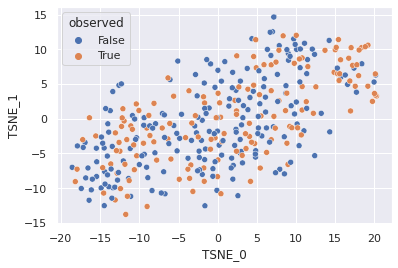

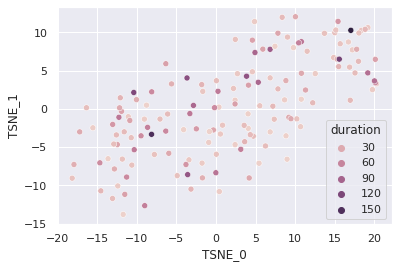

,TSNE_0,TSNE_1,observed,duration
TCGA-85-8666-01,-1.808927,3.169084,True,22.57
TCGA-34-A5IX-01,10.131946,-0.751280,False,33.87
TCGA-85-A5B5-01,-14.080572,-5.374219,False,3.65
TCGA-77-8138-01,7.817429,2.603155,True,17.71
TCGA-85-8355-01,-1.974391,-0.211010,False,2.00
...,...,...,...,...
TCGA-77-A5G8-01,-8.299124,-1.349453,False,61.89
TCGA-77-6842-01,10.026130,12.025859,True,29.53
TCGA-34-5928-01,5.261514,6.911042,False,39.29
TCGA-34-5234-01,6.621647,-3.365754,False,74.61


In [15]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(X), index=df_ae.index, columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin)
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="observed")
plt.show()
sns.scatterplot(data=df_plot[df_plot["observed"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="duration")
plt.show()
df_plot

## Train the model

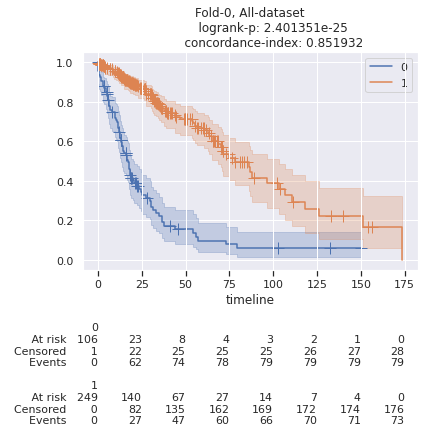

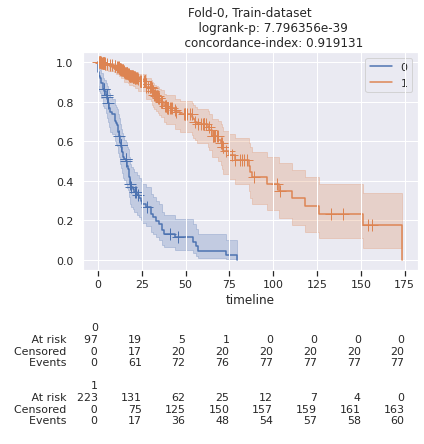

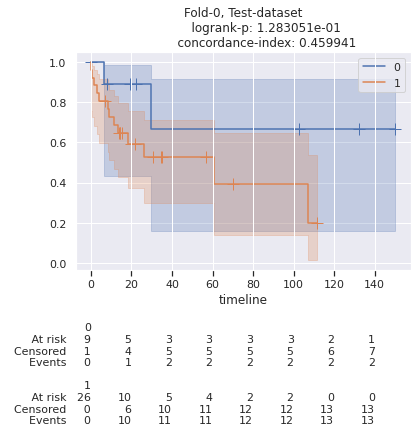

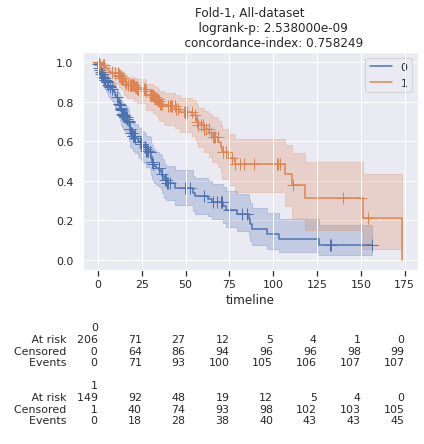

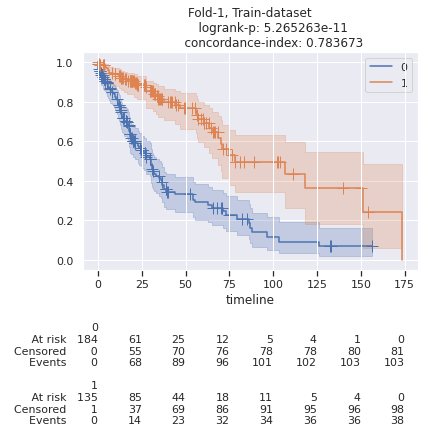

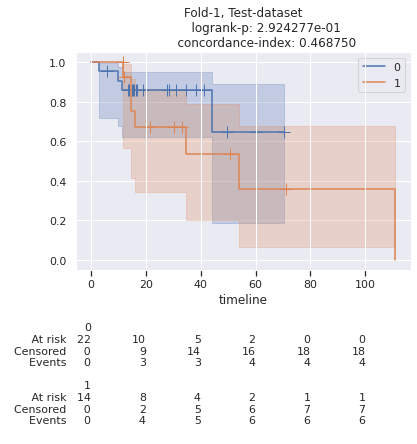

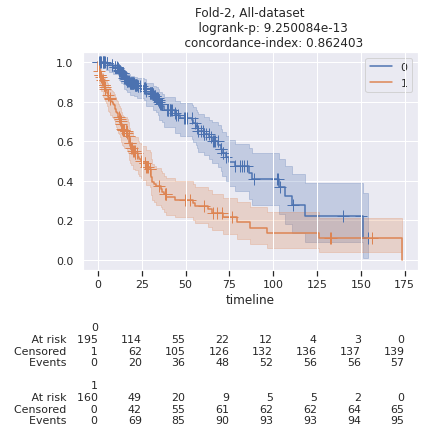

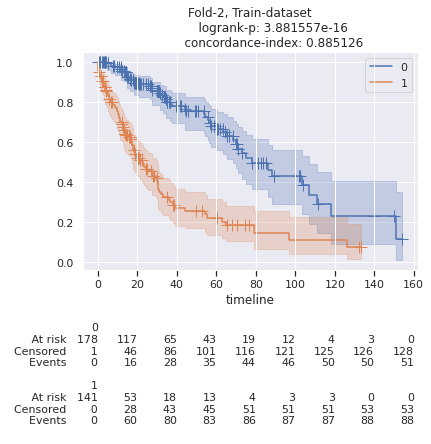

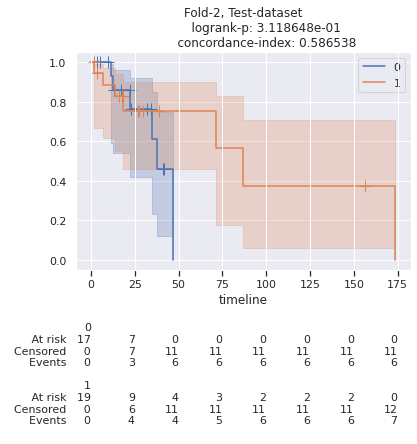

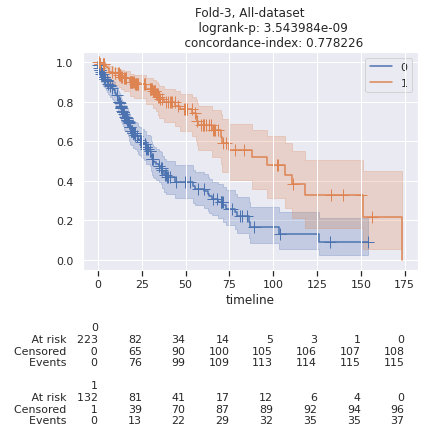

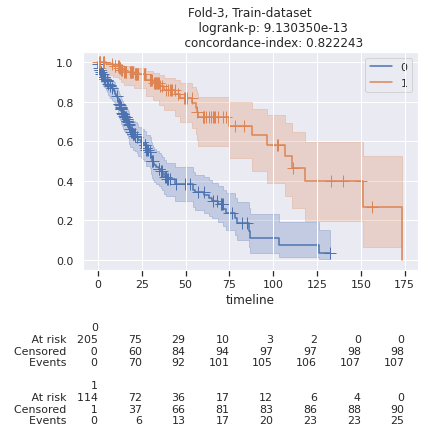

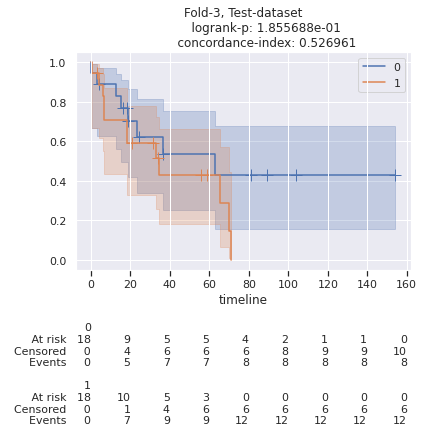

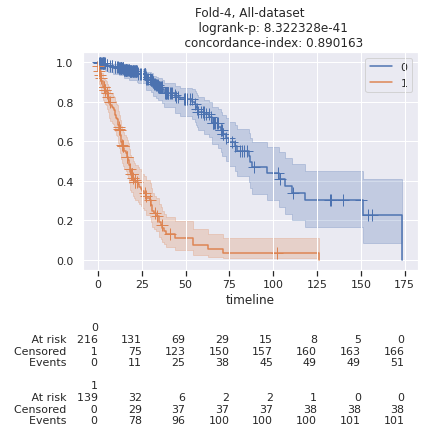

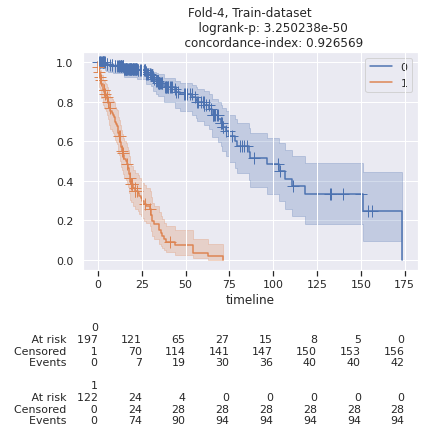

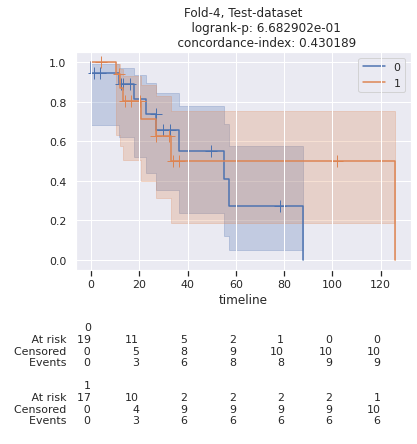

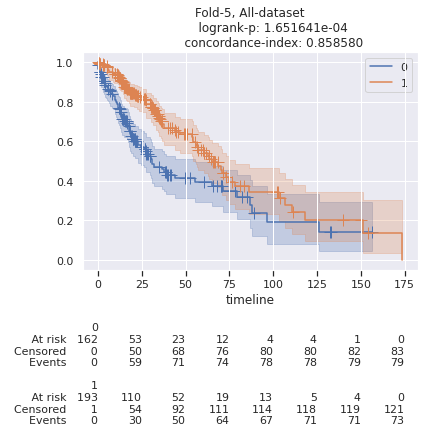

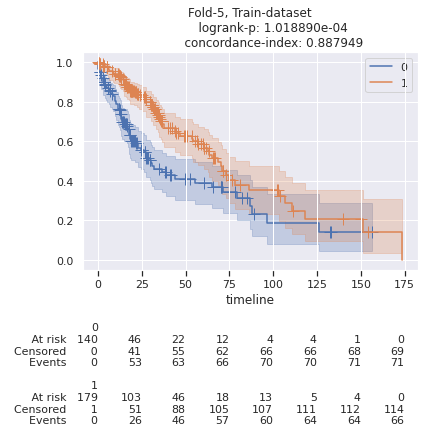

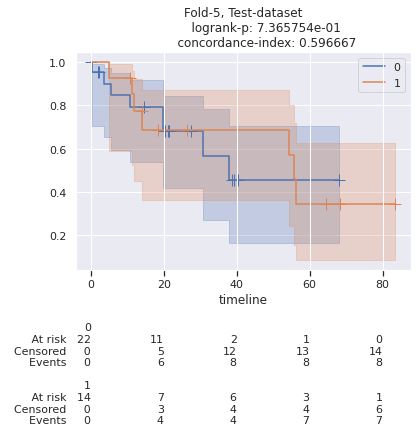

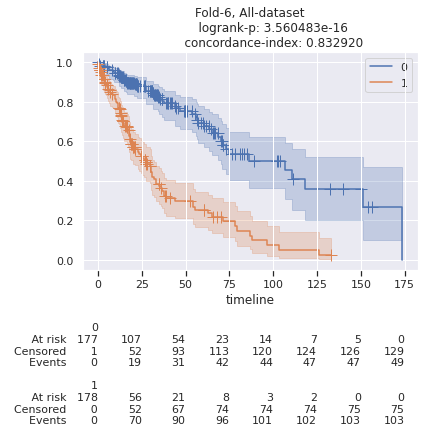

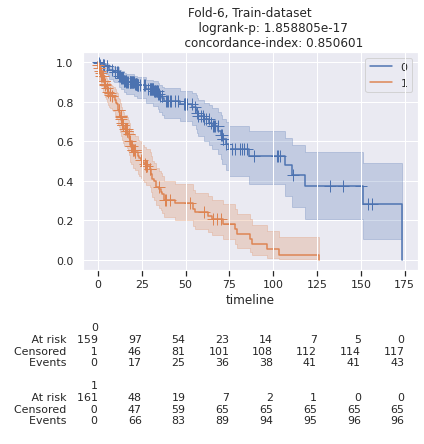

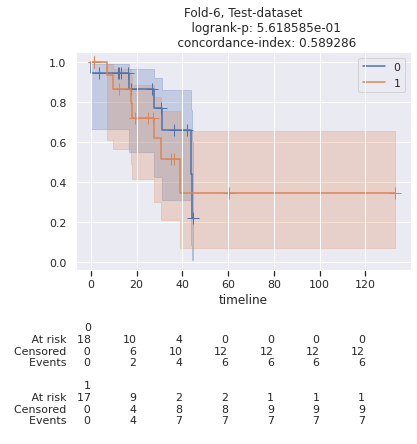

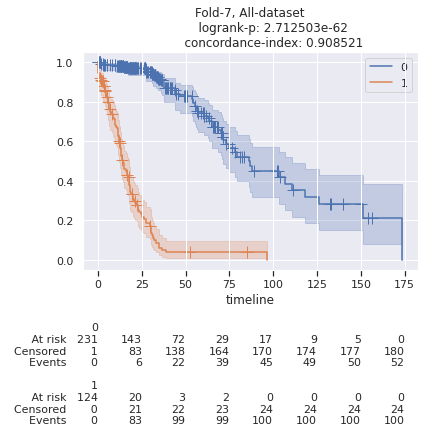

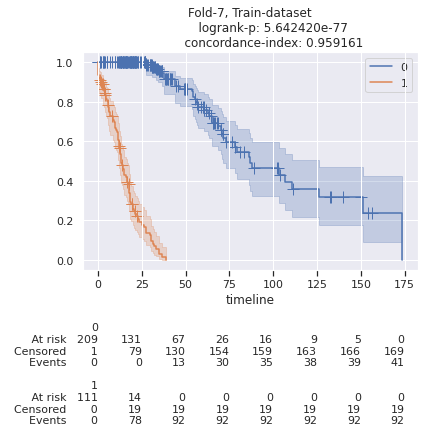

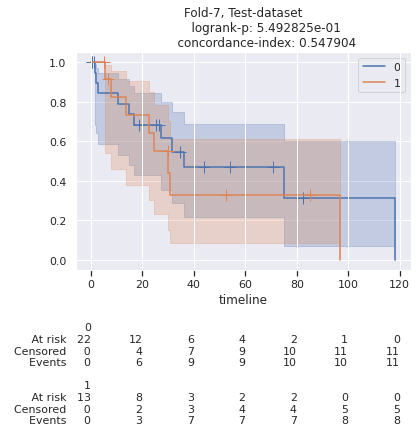

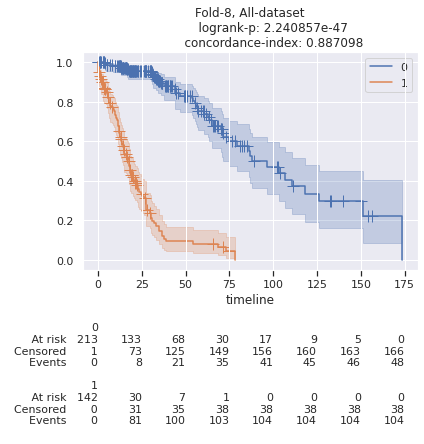

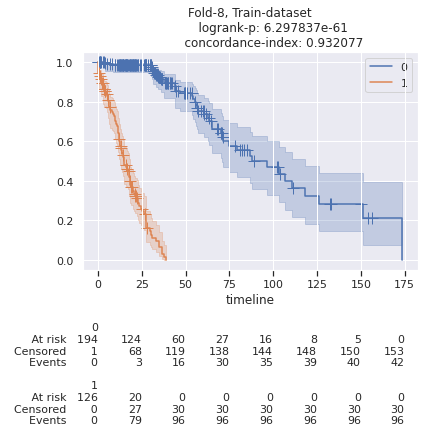

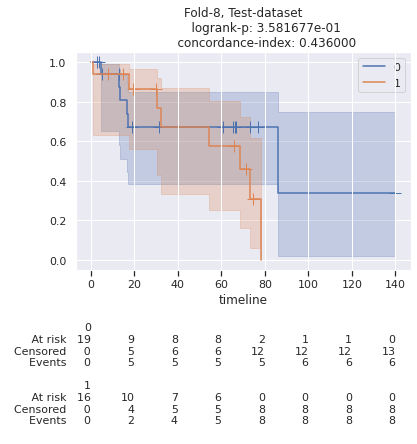

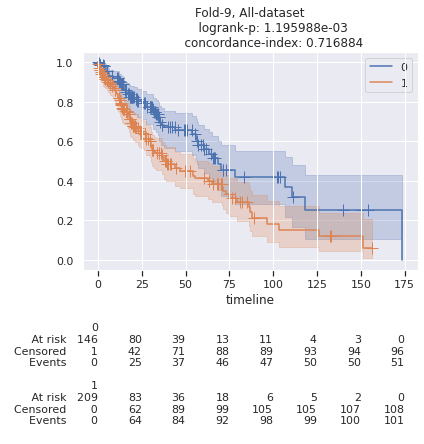

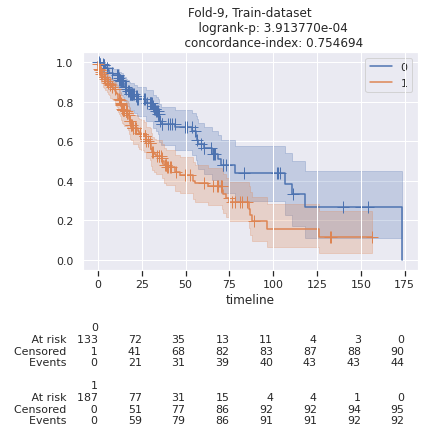

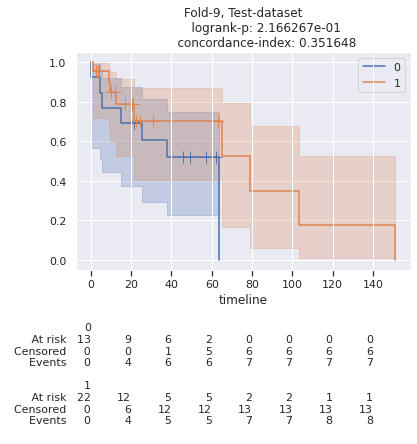

In [16]:
n_splits = 10
fold_results = []
for fold, (train_index, test_index) in enumerate(KFold(n_splits=n_splits, shuffle=True, random_state=0).split(X)):
    model = CoxAutoencoderClustering(limit_significant=20)
    model.fit(X[train_index], durations[train_index], events[train_index])
    clusters = model.predict(X)
    hazards = model.calculate_hazard(X)

    results = {}
    for name, indexes in zip(["All", "Train", "Test"], [np.concatenate([train_index, test_index]), train_index, test_index]):
        _, p_value = model.logrank_p_score(clusters[indexes], durations[indexes], events[indexes])
        c_index = model.concordance_index(hazards[indexes], durations[indexes], events[indexes])

        plt.figure()#figsize=(15,10))
        ax = plt.gca()
        kmfs, _ = get_kmfs(clusters[indexes], durations[indexes], events[indexes])
        for kmf in kmfs:
            kmf.plot(show_censors=1, ci_show=1, ax=ax)
        lifelines.plotting.add_at_risk_counts(*kmfs, ax=ax)
        plt.title(
            """Fold-{fold}, {name}-dataset
            logrank-p: {p_value:.6e}
            concordance-index: {c_index:.6f}""".format(
                fold=fold,
                name=name,
                p_value=p_value,
                c_index=c_index,
            )
        )
        plt.show()
        results[name,"p_value"] = p_value
        results[name,"c_index"] = c_index
        results[name,"inv_c_index"] = 1-c_index
        results[name,"asy_c_index"] = abs(1-2*c_index)
    
    fold_results.append(results)

In [17]:
def dropna(x):
    x = np.array(x)
    return x[~np.isnan(x)]

def print_result_table(fold_results, metrics,
        EVALUATION_SETS = ["All", "Train", "Test"],
        AGGREGATION_NAMES = ["mean", "std", "median", "iqr"],
        AGGREGATION_FUNCTIONS = [np.mean, np.std, np.median, lambda x: np.quantile(x,0.75)-np.quantile(x,0.25)],
        float_format = "f"):
    AGGREGATION_NAMES = [f.__name__ for f in AGGREGATION_FUNCTIONS] if AGGREGATION_NAMES is None else AGGREGATION_NAMES
    fold_fmt_str = "Fold-{fold}\t{All:" + float_format + "}\t{Train:" + float_format + "}\t{Test:" + float_format + "}"
    agg_fmt_str = "{agg_name}\t{All:" + float_format + "}\t{Train:" + float_format + "}\t{Test:" + float_format + "}"
    for metric in metrics:
        print("{metric}\tAll\tTrain\tTest".format(metric=metric))
        for fold, results in enumerate(fold_results):
            print(
                fold_fmt_str.format(
                    fold = fold,
                    **{t:results[t,metric] for t in EVALUATION_SETS}
                )
            )
        for agg_name, agg_func in zip(AGGREGATION_NAMES, AGGREGATION_FUNCTIONS):
            aggregated_results = {
                t: agg_func(dropna([r[t,metric] for r in fold_results])) for t in EVALUATION_SETS
            }
            print(agg_fmt_str.format(agg_name=agg_name, **aggregated_results))
        print()

In [18]:
print_result_table(fold_results, ["p_value"], float_format=".6e")

p_value	All	Train	Test
Fold-0	2.401351e-25	7.796356e-39	1.283051e-01
Fold-1	2.538000e-09	5.265263e-11	2.924277e-01
Fold-2	9.250084e-13	3.881557e-16	3.118648e-01
Fold-3	3.543984e-09	9.130350e-13	1.855688e-01
Fold-4	8.322328e-41	3.250238e-50	6.682902e-01
Fold-5	1.651641e-04	1.018890e-04	7.365754e-01
Fold-6	3.560483e-16	1.858805e-17	5.618585e-01
Fold-7	2.712503e-62	5.642420e-77	5.492825e-01
Fold-8	2.240857e-47	6.297837e-61	3.581677e-01
Fold-9	1.195988e-03	3.913770e-04	2.166267e-01
mean	1.361158e-04	4.932661e-05	4.008967e-01
std	3.567060e-04	1.179941e-04	2.020525e-01
median	4.626822e-13	2.033718e-16	3.350163e-01
iqr	3.292488e-09	3.971773e-11	3.231375e-01



In [19]:
print_result_table(fold_results, ["c_index", "asy_c_index"], float_format=".3f")

c_index	All	Train	Test
Fold-0	0.852	0.919	0.460
Fold-1	0.758	0.784	0.469
Fold-2	0.862	0.885	0.587
Fold-3	0.778	0.822	0.527
Fold-4	0.890	0.927	0.430
Fold-5	0.859	0.888	0.597
Fold-6	0.833	0.851	0.589
Fold-7	0.909	0.959	0.548
Fold-8	0.887	0.932	0.436
Fold-9	0.717	0.755	0.352
mean	0.834	0.872	0.499
std	0.060	0.064	0.078
median	0.855	0.887	0.498
iqr	0.089	0.095	0.135

asy_c_index	All	Train	Test
Fold-0	0.704	0.838	0.080
Fold-1	0.516	0.567	0.062
Fold-2	0.725	0.770	0.173
Fold-3	0.556	0.644	0.054
Fold-4	0.780	0.853	0.140
Fold-5	0.717	0.776	0.193
Fold-6	0.666	0.701	0.179
Fold-7	0.817	0.918	0.096
Fold-8	0.774	0.864	0.128
Fold-9	0.434	0.509	0.297
mean	0.669	0.744	0.140
std	0.120	0.129	0.070
median	0.711	0.773	0.134
iqr	0.178	0.191	0.093



(0.0, 1.0)

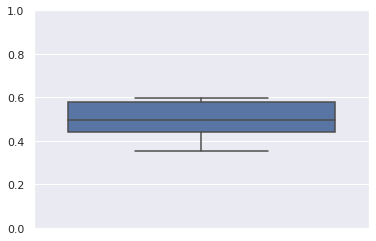

In [20]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["Test","c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

(0.0, 1.0)

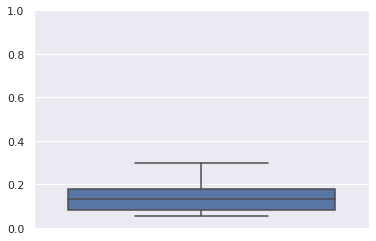

In [21]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["Test","asy_c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

(0.0, 1.0)

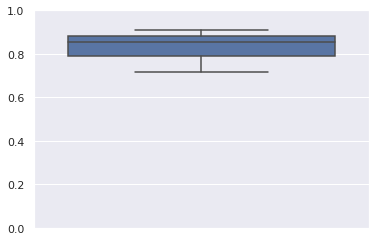

In [22]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["All","c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

(0.0, 1.0)

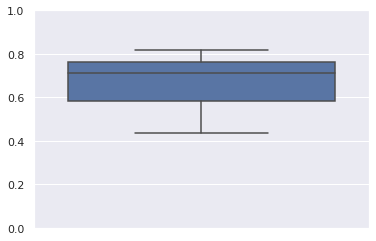

In [23]:
fig, ax = plt.subplots()
sns.boxplot(y=[r["All","asy_c_index"] for r in fold_results], ax=ax)
ax.set_ylim(0, 1)

In [24]:
[r["Test","c_index"] for r in fold_results]

[0.4599406528189911,
 0.46875,
 0.5865384615384616,
 0.5269607843137255,
 0.43018867924528303,
 0.5966666666666667,
 0.5892857142857143,
 0.5479041916167665,
 0.436,
 0.3516483516483517]

In [25]:
[r["All","c_index"] for r in fold_results]

[0.8519322174002893,
 0.758248949507474,
 0.8624027002824275,
 0.7782255286905008,
 0.8901632568712544,
 0.858579596335331,
 0.8329200247985121,
 0.9085210442928979,
 0.8870978852379968,
 0.7168836536474478]

In [26]:
[r["Test","p_value"] for r in fold_results]

[0.1283050959444713,
 0.29242766589656866,
 0.31186482502562196,
 0.18556878766413007,
 0.6682902485594542,
 0.7365754471016626,
 0.5618584706983591,
 0.5492824873128261,
 0.35816770490433825,
 0.2166267108044463]

In [27]:
[r["All","p_value"] for r in fold_results]

[2.4013506368164653e-25,
 2.537999989131682e-09,
 9.250084081732943e-13,
 3.5439835474237393e-09,
 8.322327934236558e-41,
 0.00016516405535814784,
 3.5604830651818667e-16,
 2.7125025790033917e-62,
 2.24085682062613e-47,
 0.0011959882065298094]